# Tutorial - GANs from scratch for MNIST dataset

In [2]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets

In [4]:
from utils import Logger

##### Load and preprocess MNIST dataset

In [11]:
def mnist_data():
    compose = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((.5, .5, .5), (.5, .5, .5))
        ])
    out_dir = './dataset'
    return datasets.MNIST(root=out_dir, train=True, transform=compose, download=True)
# Load data
data = mnist_data()
# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

def images_to_vectors(images):
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)

def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

##### Discriminator Network

In [12]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_features = 784
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            nn.Linear(n_features, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, n_out),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
discriminator = DiscriminatorNet()

##### Generative Network

In [13]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.hidden0 = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.LeakyReLU(0.2)
        )
        self.hidden1 = nn.Sequential(            
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2)
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2)
        )
        
        self.out = nn.Sequential(
            nn.Linear(1024, n_out),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = self.hidden2(x)
        x = self.out(x)
        return x
    
generator = GeneratorNet()

##### Training

In [15]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
loss        = nn.BCELoss()

In [16]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [17]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

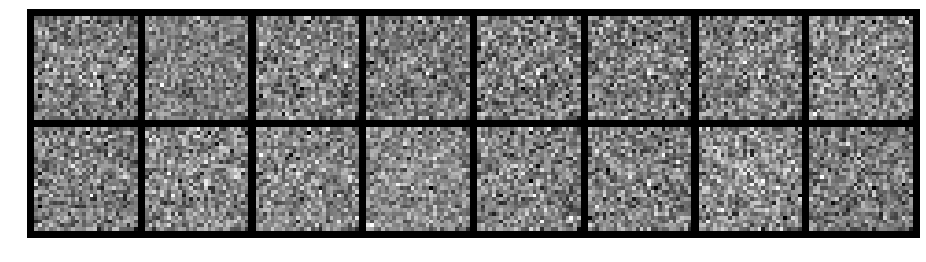

Epoch: [0/200], Batch Num: [0/600]
Discriminator Loss: 1.3935, Generator Loss: 0.6953
D(x): 0.4956, D(G(z)): 0.4990


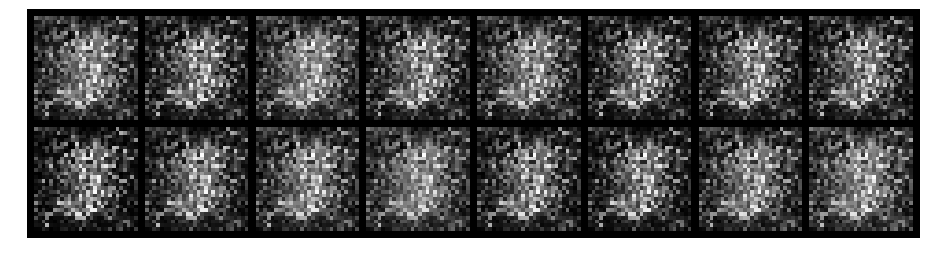

Epoch: [0/200], Batch Num: [100/600]
Discriminator Loss: 1.0200, Generator Loss: 2.7257
D(x): 0.5934, D(G(z)): 0.2728


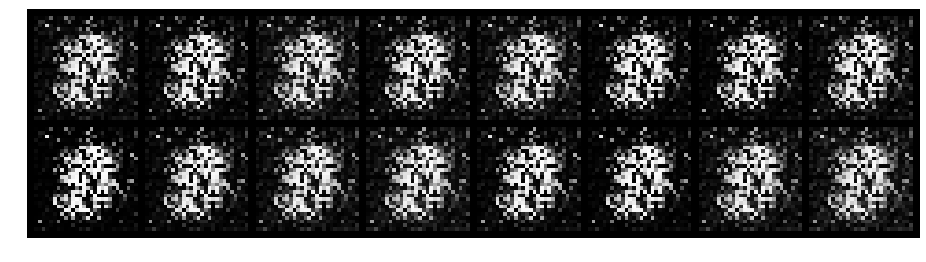

Epoch: [0/200], Batch Num: [200/600]
Discriminator Loss: 0.7351, Generator Loss: 3.2957
D(x): 0.7557, D(G(z)): 0.2568


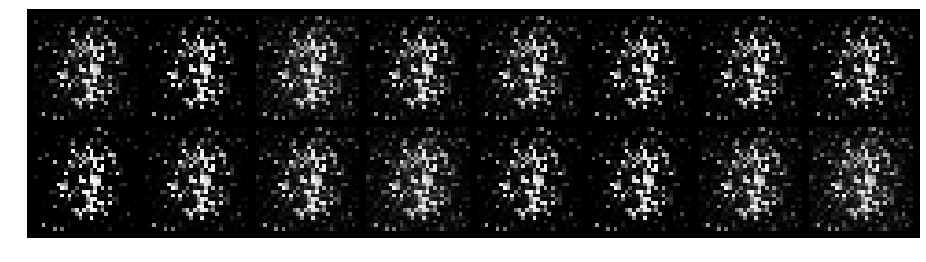

Epoch: [0/200], Batch Num: [300/600]
Discriminator Loss: 0.5248, Generator Loss: 4.3238
D(x): 0.8536, D(G(z)): 0.1775


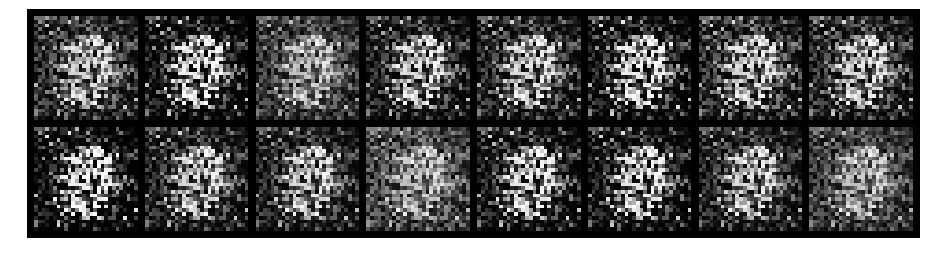

Epoch: [0/200], Batch Num: [400/600]
Discriminator Loss: 4.5990, Generator Loss: 0.4434
D(x): 0.3812, D(G(z)): 0.9322


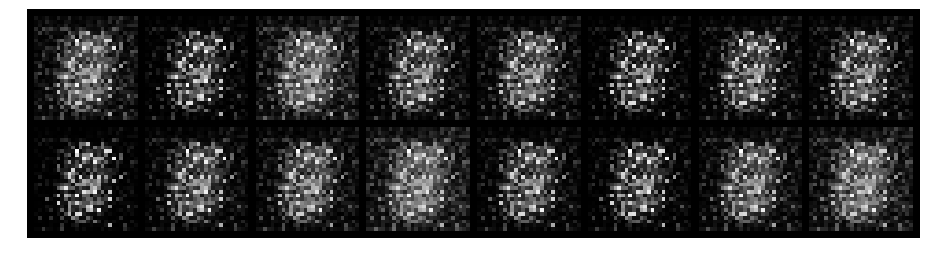

Epoch: [0/200], Batch Num: [500/600]
Discriminator Loss: 1.6959, Generator Loss: 0.6006
D(x): 0.5248, D(G(z)): 0.5915


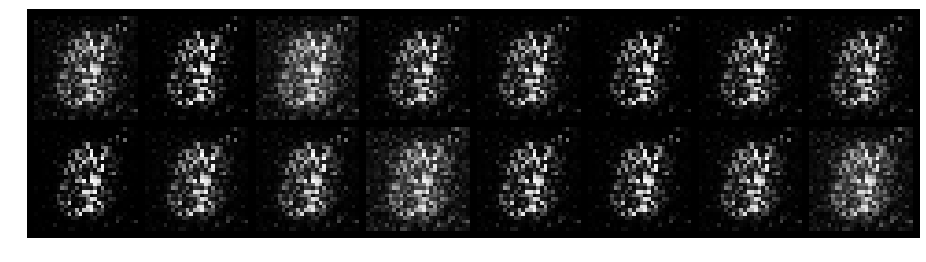

Epoch: [1/200], Batch Num: [0/600]
Discriminator Loss: 0.5250, Generator Loss: 5.4904
D(x): 0.8113, D(G(z)): 0.1757


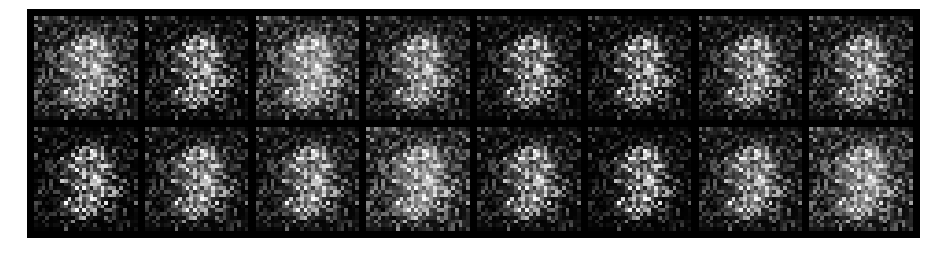

Epoch: [1/200], Batch Num: [100/600]
Discriminator Loss: 0.9631, Generator Loss: 1.1369
D(x): 0.6929, D(G(z)): 0.4096


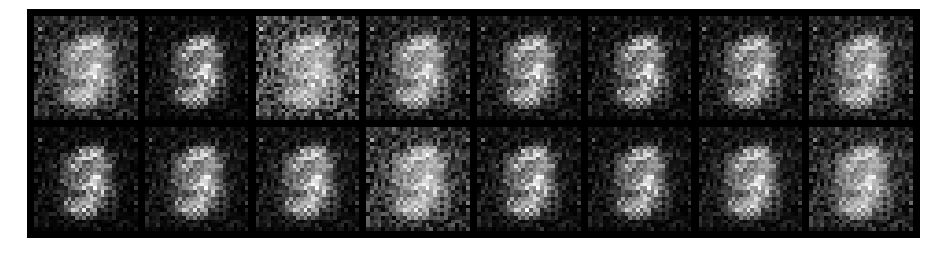

Epoch: [1/200], Batch Num: [200/600]
Discriminator Loss: 2.0294, Generator Loss: 0.5769
D(x): 0.5528, D(G(z)): 0.6823


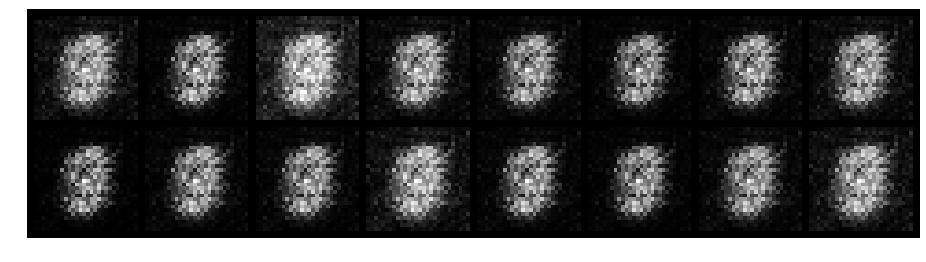

Epoch: [1/200], Batch Num: [300/600]
Discriminator Loss: 1.2599, Generator Loss: 0.8258
D(x): 0.5586, D(G(z)): 0.4660


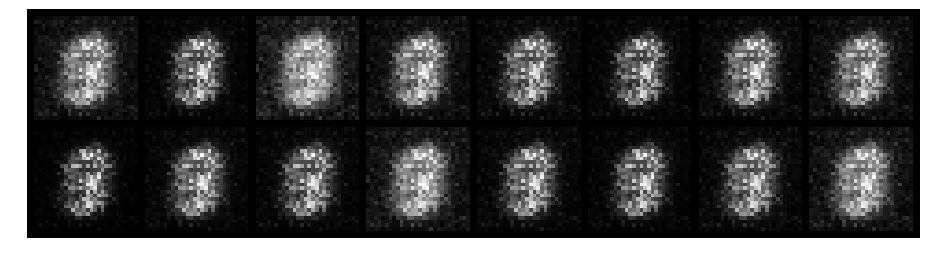

Epoch: [1/200], Batch Num: [400/600]
Discriminator Loss: 0.9349, Generator Loss: 1.4599
D(x): 0.6701, D(G(z)): 0.3672


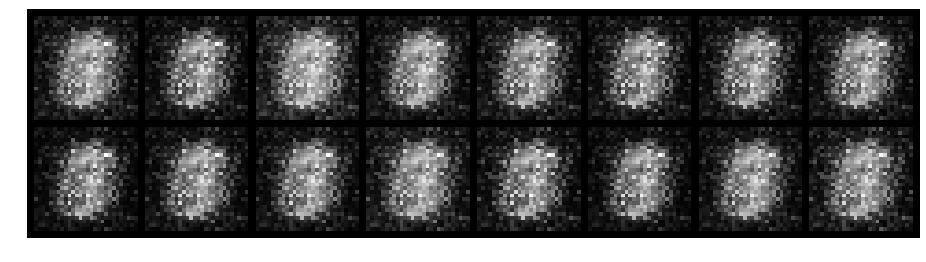

Epoch: [1/200], Batch Num: [500/600]
Discriminator Loss: 1.6549, Generator Loss: 0.9200
D(x): 0.5872, D(G(z)): 0.5209


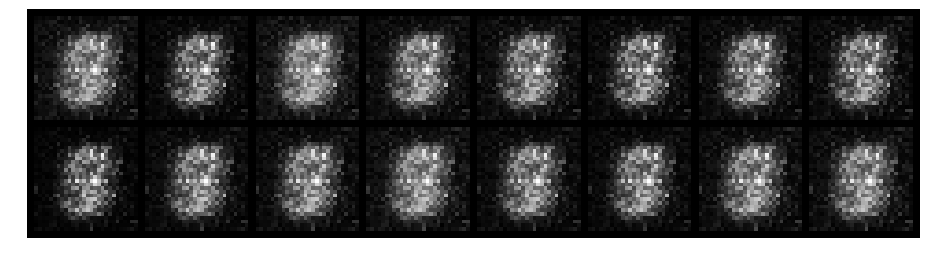

Epoch: [2/200], Batch Num: [0/600]
Discriminator Loss: 1.1439, Generator Loss: 1.1242
D(x): 0.6273, D(G(z)): 0.4095


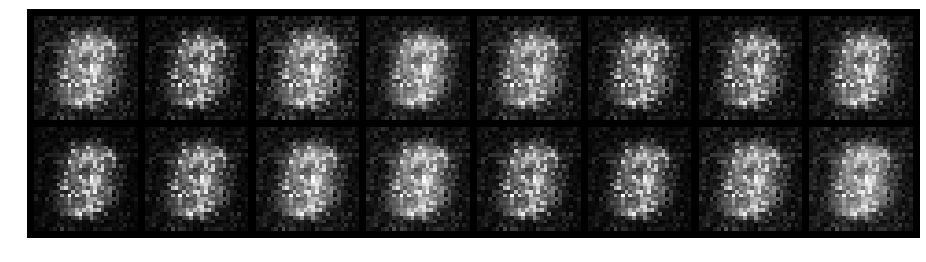

Epoch: [2/200], Batch Num: [100/600]
Discriminator Loss: 0.9845, Generator Loss: 2.0957
D(x): 0.7406, D(G(z)): 0.3540


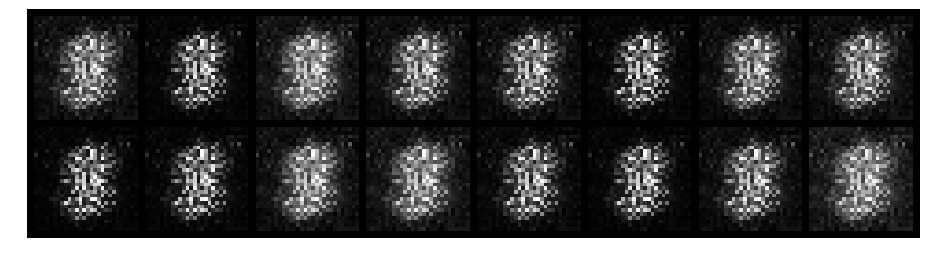

Epoch: [2/200], Batch Num: [200/600]
Discriminator Loss: 0.3014, Generator Loss: 6.1247
D(x): 0.9034, D(G(z)): 0.0976


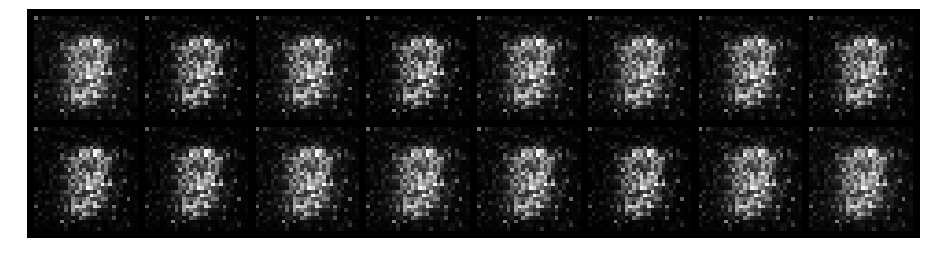

Epoch: [2/200], Batch Num: [300/600]
Discriminator Loss: 1.1499, Generator Loss: 1.7546
D(x): 0.7297, D(G(z)): 0.3236


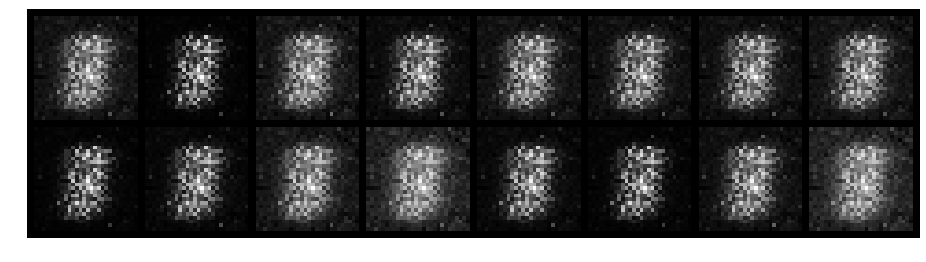

Epoch: [2/200], Batch Num: [400/600]
Discriminator Loss: 0.3195, Generator Loss: 3.2459
D(x): 0.9166, D(G(z)): 0.1599


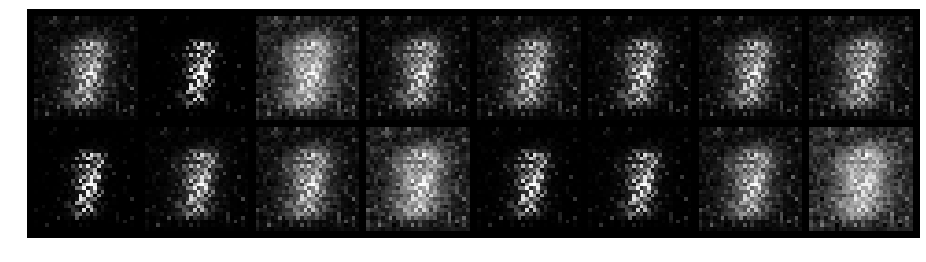

Epoch: [2/200], Batch Num: [500/600]
Discriminator Loss: 0.4887, Generator Loss: 2.0907
D(x): 0.9068, D(G(z)): 0.2163


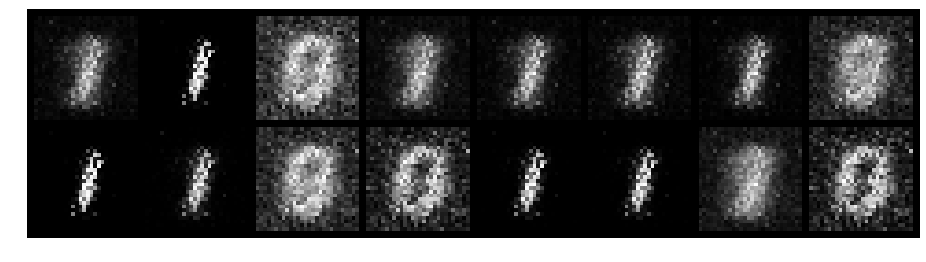

Epoch: [3/200], Batch Num: [0/600]
Discriminator Loss: 0.9199, Generator Loss: 1.5369
D(x): 0.6965, D(G(z)): 0.3445


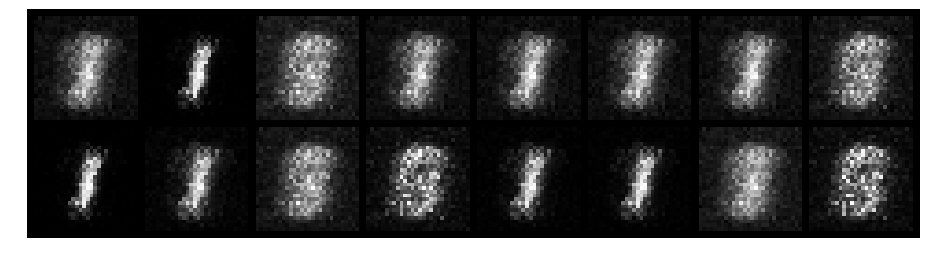

Epoch: [3/200], Batch Num: [100/600]
Discriminator Loss: 0.6501, Generator Loss: 2.8078
D(x): 0.8198, D(G(z)): 0.1832


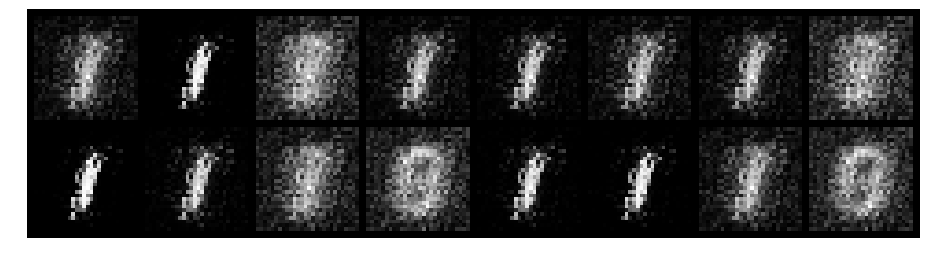

Epoch: [3/200], Batch Num: [200/600]
Discriminator Loss: 0.2520, Generator Loss: 4.5503
D(x): 0.8849, D(G(z)): 0.0576


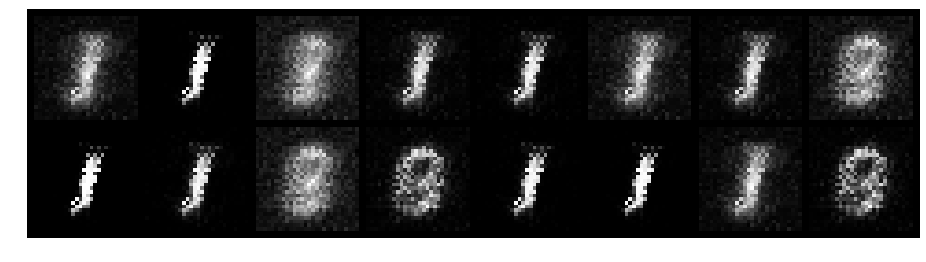

Epoch: [3/200], Batch Num: [300/600]
Discriminator Loss: 0.4255, Generator Loss: 2.7950
D(x): 0.8372, D(G(z)): 0.1294


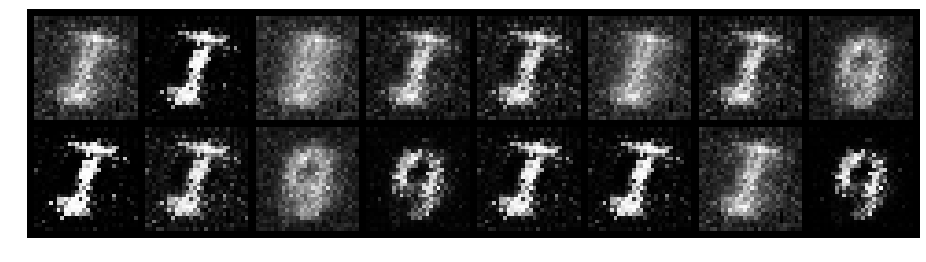

Epoch: [3/200], Batch Num: [400/600]
Discriminator Loss: 0.2225, Generator Loss: 4.2656
D(x): 0.9282, D(G(z)): 0.0927


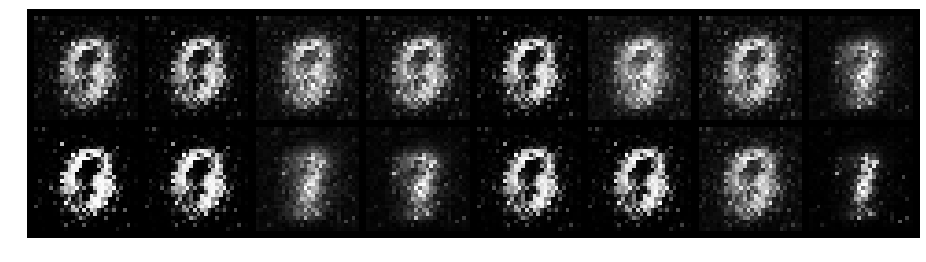

Epoch: [3/200], Batch Num: [500/600]
Discriminator Loss: 0.9834, Generator Loss: 2.2346
D(x): 0.7246, D(G(z)): 0.2230


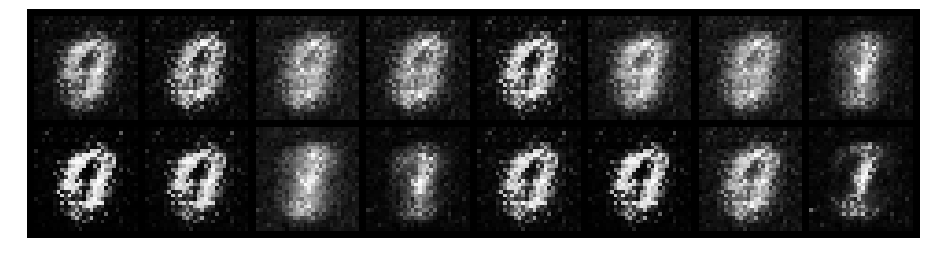

Epoch: [4/200], Batch Num: [0/600]
Discriminator Loss: 0.3067, Generator Loss: 3.6187
D(x): 0.9162, D(G(z)): 0.1413


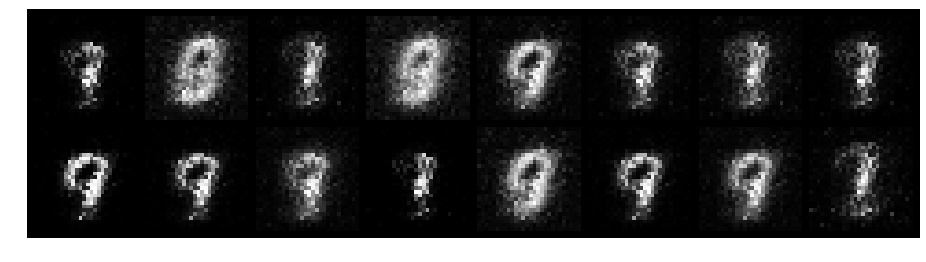

Epoch: [4/200], Batch Num: [100/600]
Discriminator Loss: 0.6738, Generator Loss: 2.4606
D(x): 0.7773, D(G(z)): 0.1849


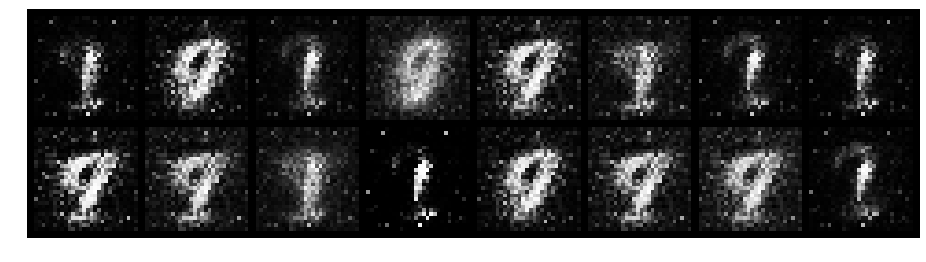

Epoch: [4/200], Batch Num: [200/600]
Discriminator Loss: 0.5294, Generator Loss: 2.8274
D(x): 0.8297, D(G(z)): 0.1677


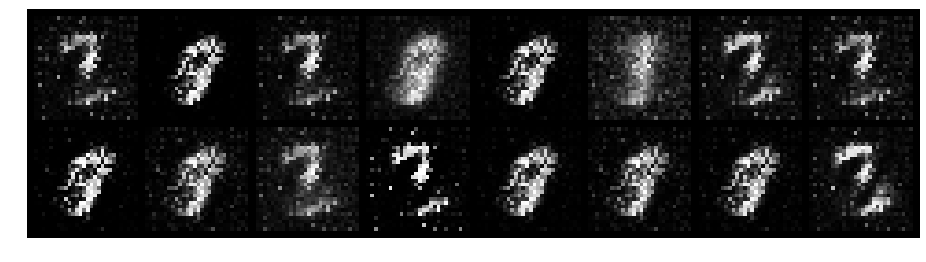

Epoch: [4/200], Batch Num: [300/600]
Discriminator Loss: 0.5049, Generator Loss: 4.4569
D(x): 0.7986, D(G(z)): 0.0430


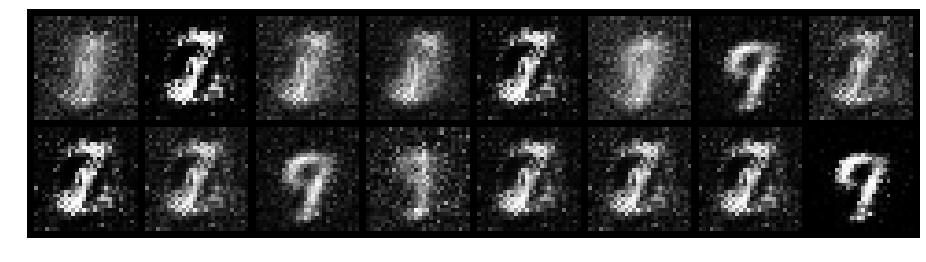

Epoch: [4/200], Batch Num: [400/600]
Discriminator Loss: 0.6009, Generator Loss: 4.1392
D(x): 0.8744, D(G(z)): 0.2000


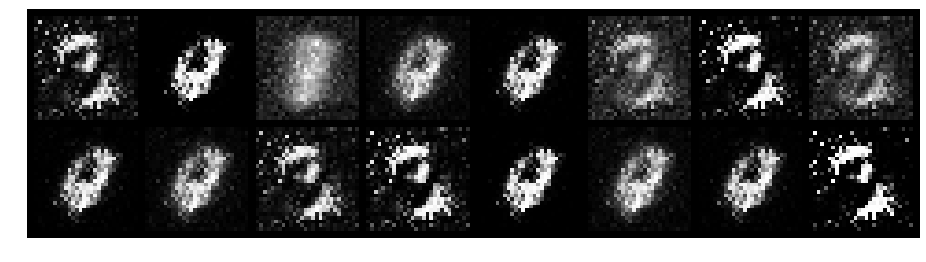

Epoch: [4/200], Batch Num: [500/600]
Discriminator Loss: 0.3351, Generator Loss: 3.4844
D(x): 0.9066, D(G(z)): 0.1210


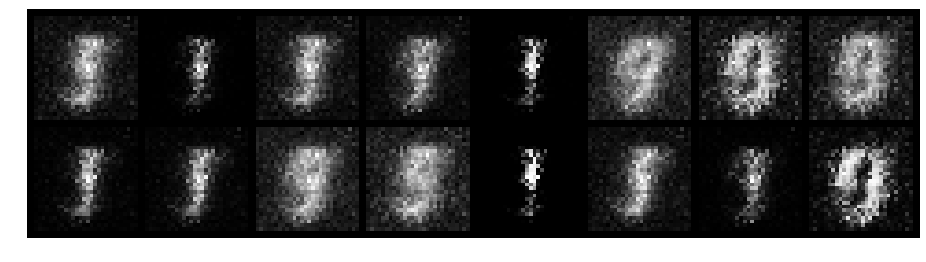

Epoch: [5/200], Batch Num: [0/600]
Discriminator Loss: 0.4663, Generator Loss: 3.8538
D(x): 0.8592, D(G(z)): 0.1291


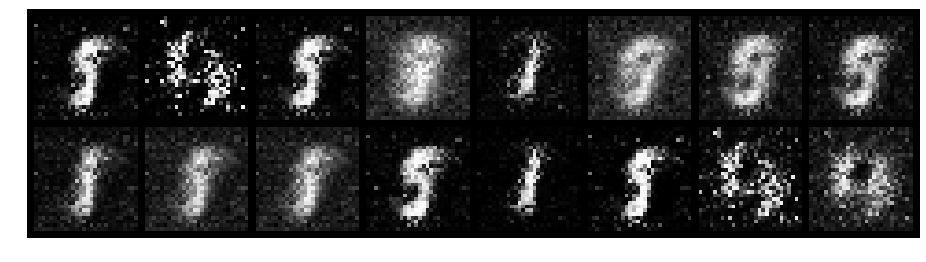

Epoch: [5/200], Batch Num: [100/600]
Discriminator Loss: 0.7251, Generator Loss: 2.6711
D(x): 0.8509, D(G(z)): 0.2641


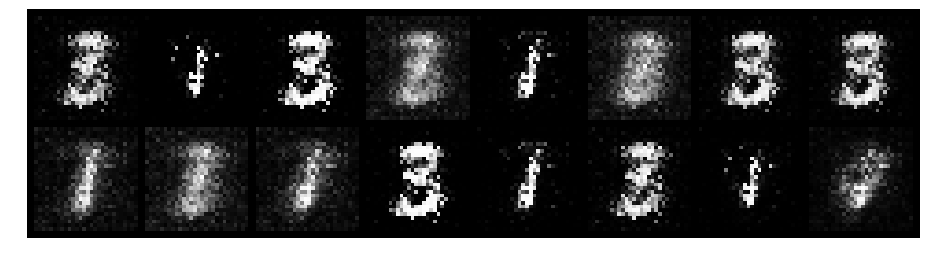

Epoch: [5/200], Batch Num: [200/600]
Discriminator Loss: 0.3779, Generator Loss: 3.8556
D(x): 0.9352, D(G(z)): 0.1377


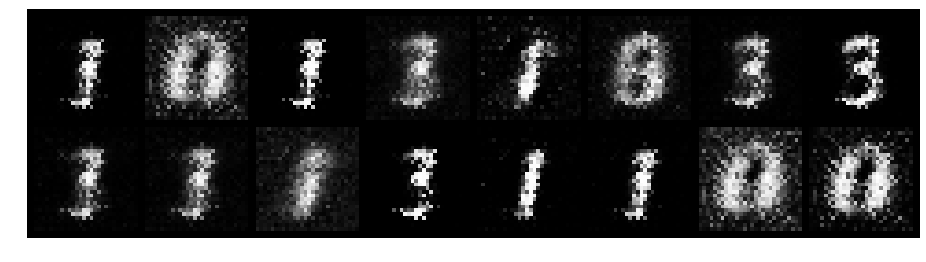

Epoch: [5/200], Batch Num: [300/600]
Discriminator Loss: 0.5534, Generator Loss: 2.3721
D(x): 0.9149, D(G(z)): 0.2555


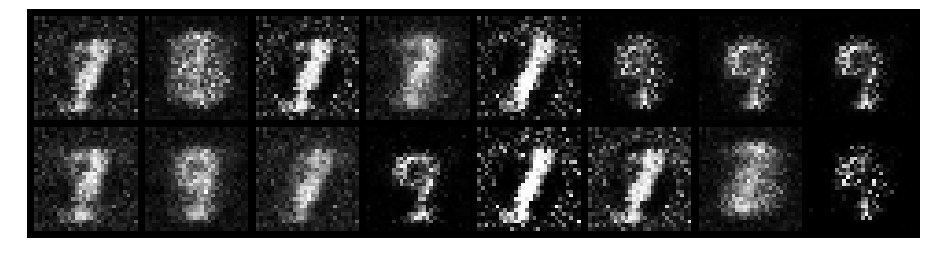

Epoch: [5/200], Batch Num: [400/600]
Discriminator Loss: 0.4739, Generator Loss: 3.3143
D(x): 0.8444, D(G(z)): 0.0823


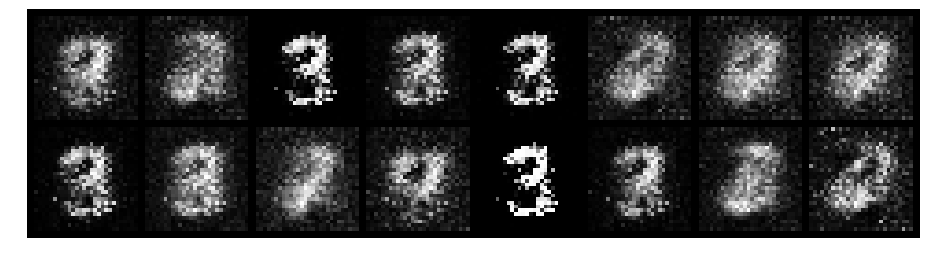

Epoch: [5/200], Batch Num: [500/600]
Discriminator Loss: 0.5672, Generator Loss: 2.7483
D(x): 0.8065, D(G(z)): 0.1525


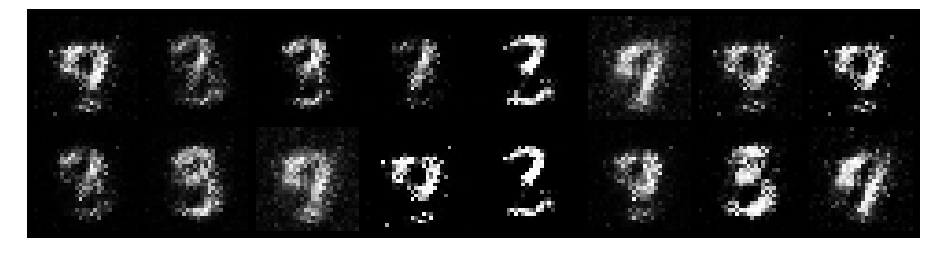

Epoch: [6/200], Batch Num: [0/600]
Discriminator Loss: 0.3814, Generator Loss: 2.8107
D(x): 0.9248, D(G(z)): 0.1818


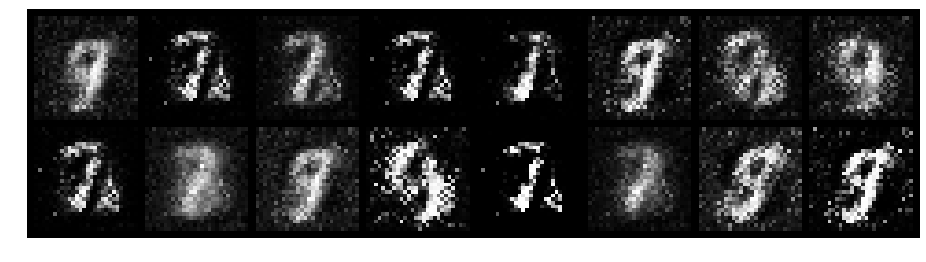

Epoch: [6/200], Batch Num: [100/600]
Discriminator Loss: 0.6084, Generator Loss: 2.5637
D(x): 0.8126, D(G(z)): 0.1672


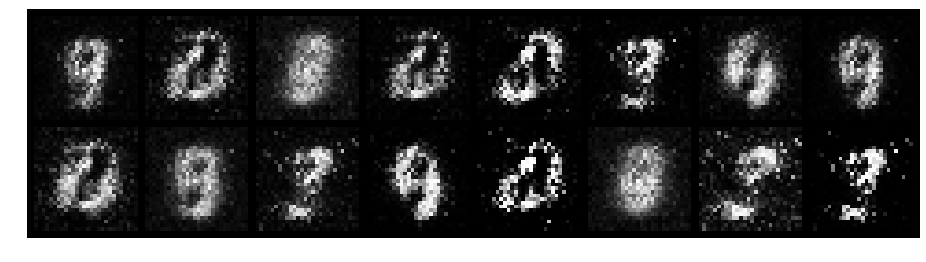

Epoch: [6/200], Batch Num: [200/600]
Discriminator Loss: 0.3994, Generator Loss: 2.8234
D(x): 0.8787, D(G(z)): 0.1418


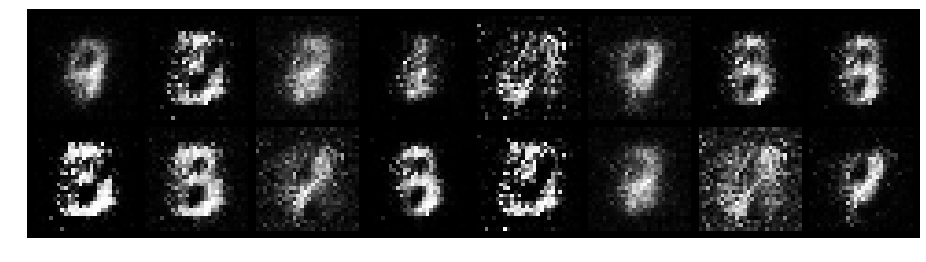

Epoch: [6/200], Batch Num: [300/600]
Discriminator Loss: 0.7327, Generator Loss: 2.5086
D(x): 0.7598, D(G(z)): 0.1829


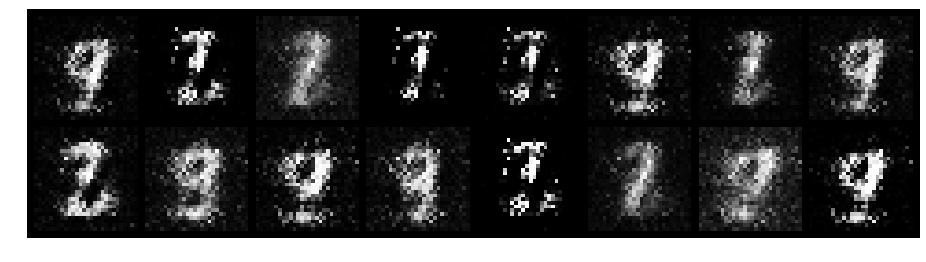

Epoch: [6/200], Batch Num: [400/600]
Discriminator Loss: 0.4751, Generator Loss: 2.2115
D(x): 0.8547, D(G(z)): 0.1852


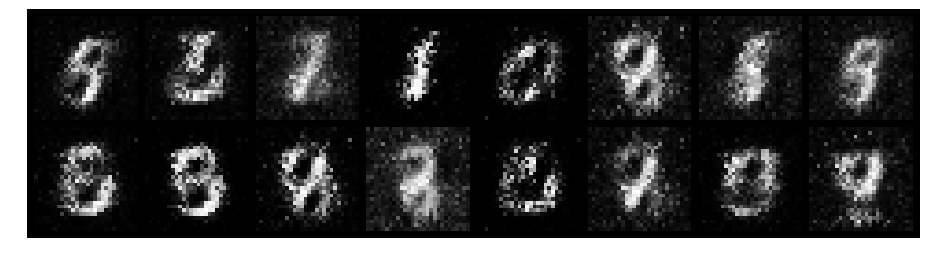

Epoch: [6/200], Batch Num: [500/600]
Discriminator Loss: 0.9338, Generator Loss: 2.8488
D(x): 0.6789, D(G(z)): 0.1252


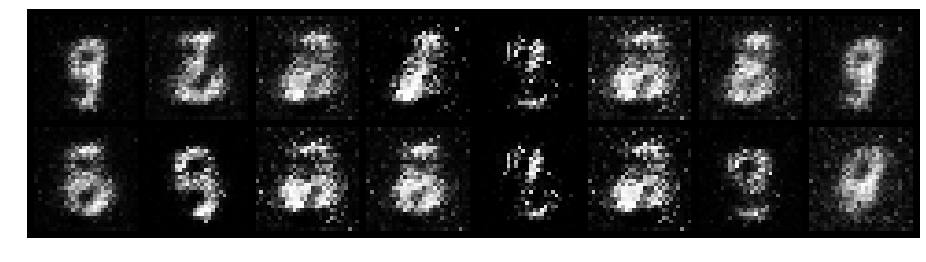

Epoch: [7/200], Batch Num: [0/600]
Discriminator Loss: 1.1755, Generator Loss: 1.6229
D(x): 0.6101, D(G(z)): 0.1838


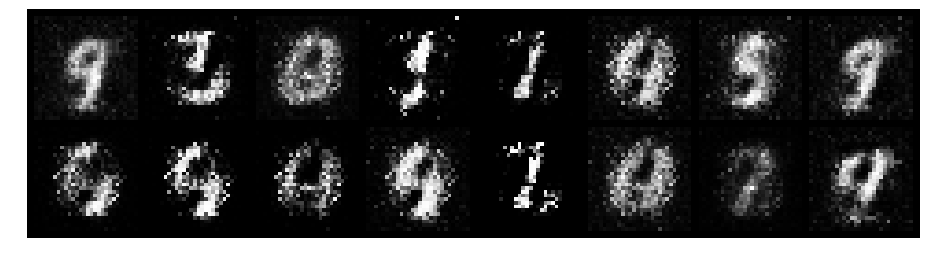

Epoch: [7/200], Batch Num: [100/600]
Discriminator Loss: 0.8082, Generator Loss: 1.8918
D(x): 0.7879, D(G(z)): 0.2787


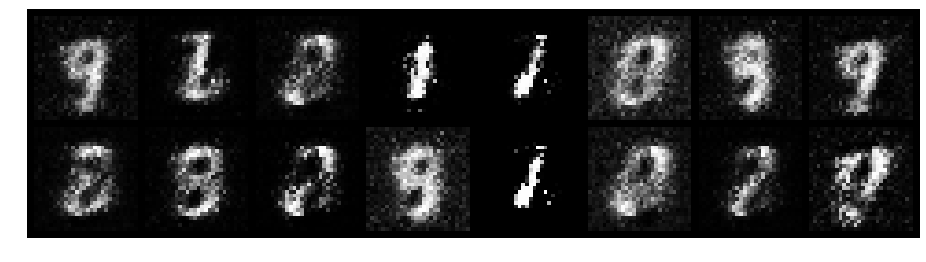

Epoch: [7/200], Batch Num: [200/600]
Discriminator Loss: 0.4003, Generator Loss: 2.4600
D(x): 0.8509, D(G(z)): 0.1324


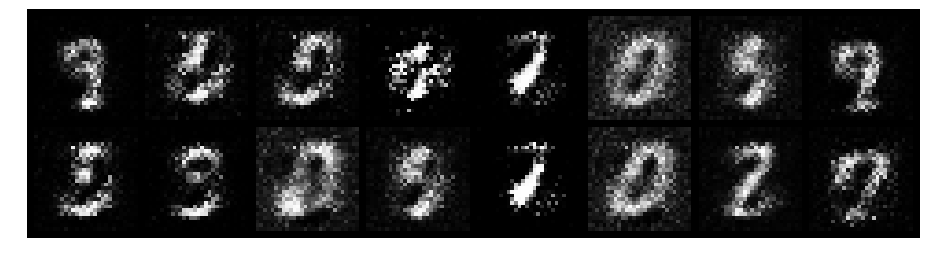

Epoch: [7/200], Batch Num: [300/600]
Discriminator Loss: 0.2926, Generator Loss: 3.0752
D(x): 0.9237, D(G(z)): 0.1565


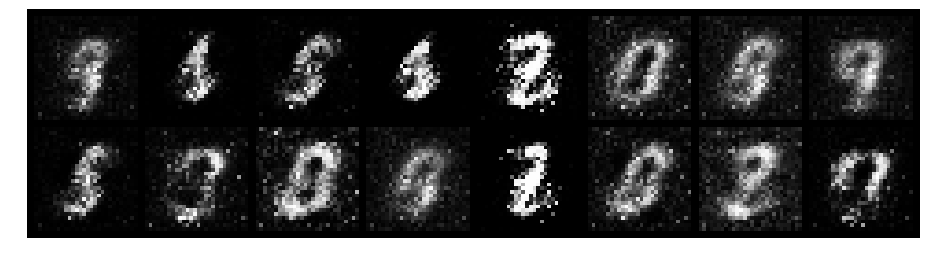

Epoch: [7/200], Batch Num: [400/600]
Discriminator Loss: 0.5230, Generator Loss: 2.5421
D(x): 0.8167, D(G(z)): 0.1631


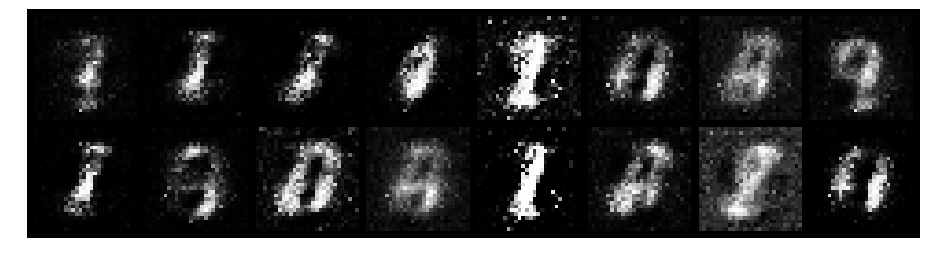

Epoch: [7/200], Batch Num: [500/600]
Discriminator Loss: 0.4922, Generator Loss: 2.5239
D(x): 0.8253, D(G(z)): 0.1751


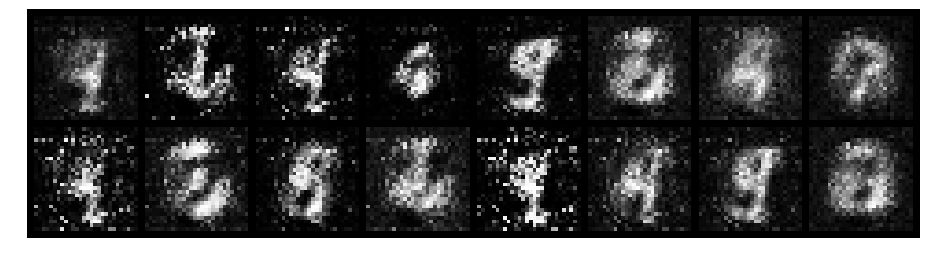

Epoch: [8/200], Batch Num: [0/600]
Discriminator Loss: 0.5980, Generator Loss: 2.4029
D(x): 0.8185, D(G(z)): 0.1942


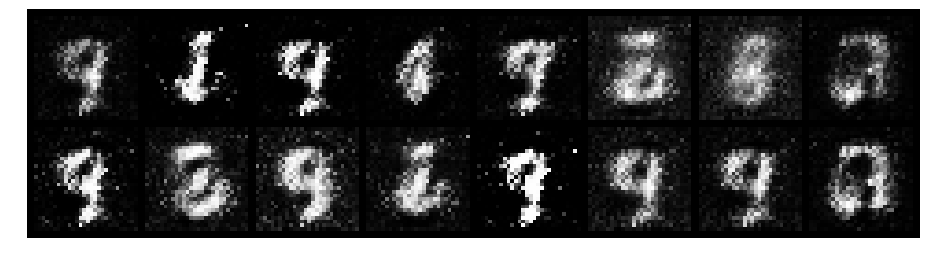

Epoch: [8/200], Batch Num: [100/600]
Discriminator Loss: 0.3282, Generator Loss: 3.0308
D(x): 0.8730, D(G(z)): 0.1173


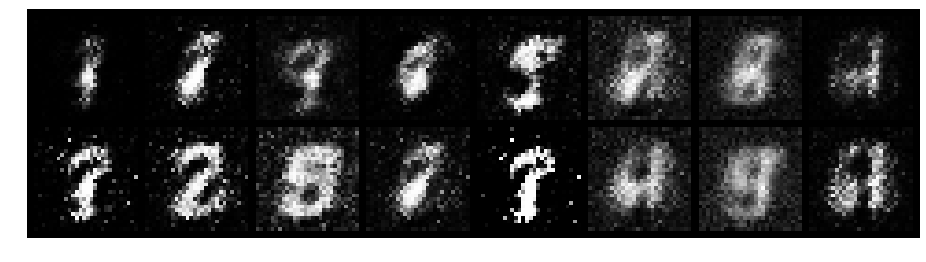

Epoch: [8/200], Batch Num: [200/600]
Discriminator Loss: 0.5023, Generator Loss: 2.8346
D(x): 0.8018, D(G(z)): 0.1382


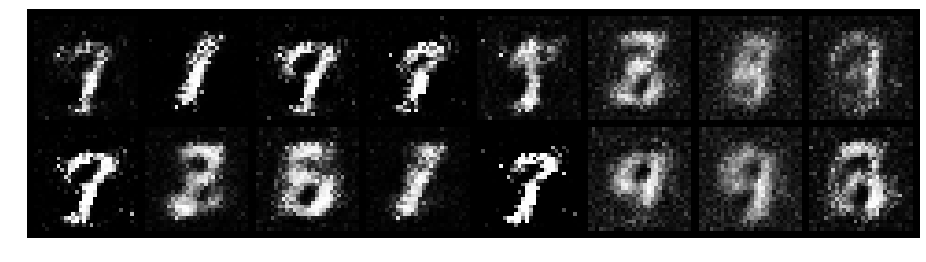

Epoch: [8/200], Batch Num: [300/600]
Discriminator Loss: 0.8407, Generator Loss: 1.8939
D(x): 0.6996, D(G(z)): 0.1985


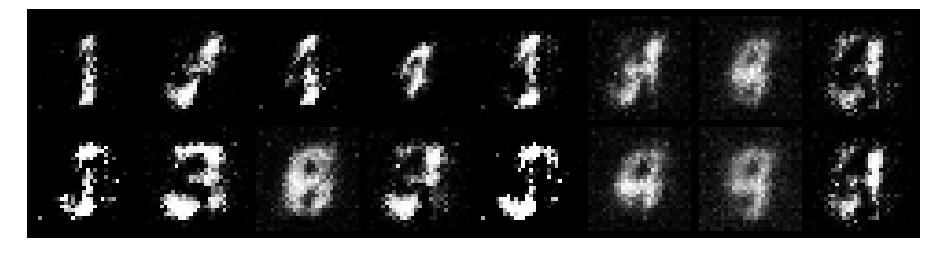

Epoch: [8/200], Batch Num: [400/600]
Discriminator Loss: 0.8620, Generator Loss: 2.0078
D(x): 0.7735, D(G(z)): 0.2628


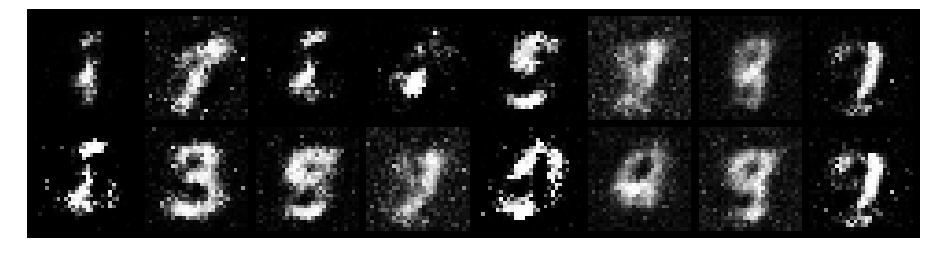

Epoch: [8/200], Batch Num: [500/600]
Discriminator Loss: 0.6085, Generator Loss: 3.6704
D(x): 0.7957, D(G(z)): 0.1173


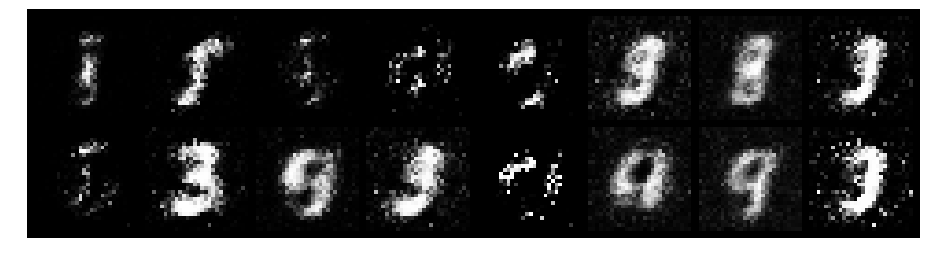

Epoch: [9/200], Batch Num: [0/600]
Discriminator Loss: 0.5804, Generator Loss: 2.1637
D(x): 0.7838, D(G(z)): 0.1394


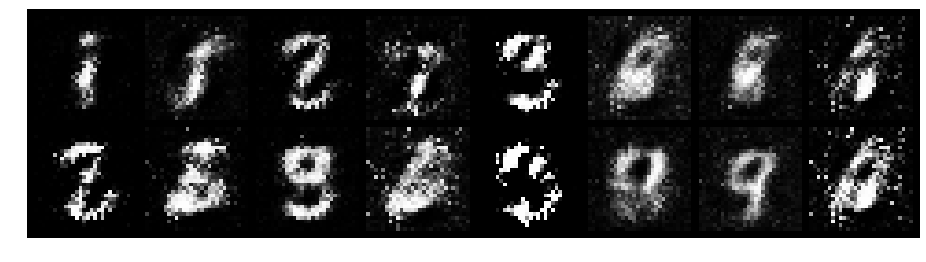

Epoch: [9/200], Batch Num: [100/600]
Discriminator Loss: 0.5348, Generator Loss: 2.4507
D(x): 0.8753, D(G(z)): 0.2244


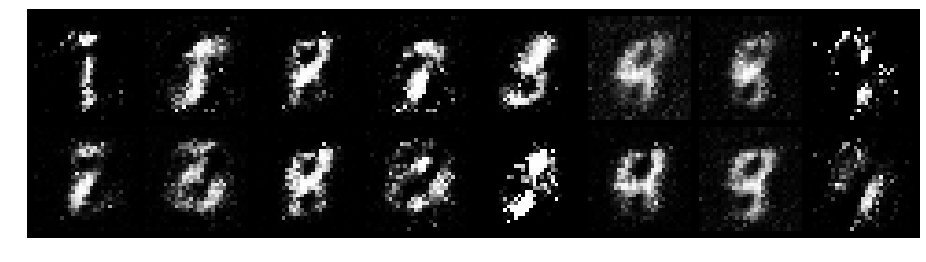

Epoch: [9/200], Batch Num: [200/600]
Discriminator Loss: 0.5009, Generator Loss: 3.0736
D(x): 0.8402, D(G(z)): 0.1476


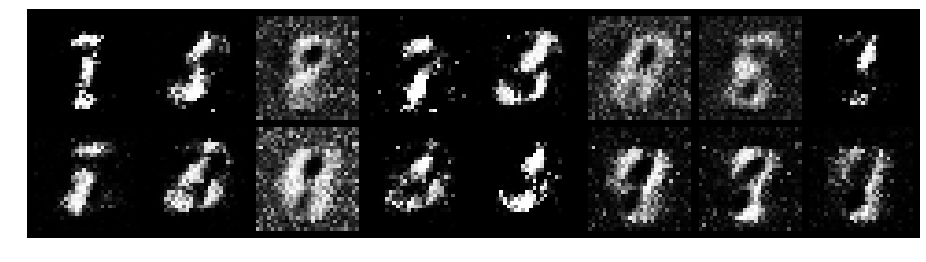

Epoch: [9/200], Batch Num: [300/600]
Discriminator Loss: 0.8098, Generator Loss: 2.6989
D(x): 0.7532, D(G(z)): 0.2267


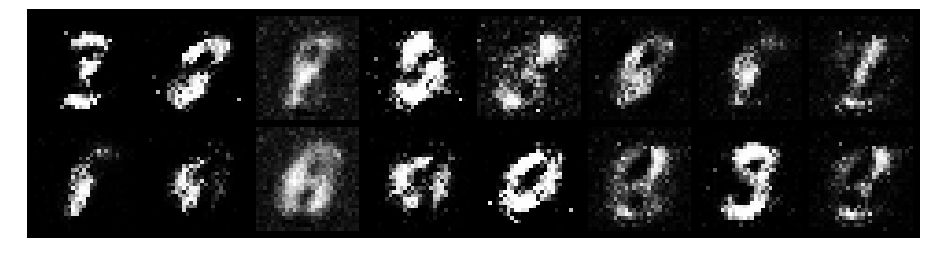

Epoch: [9/200], Batch Num: [400/600]
Discriminator Loss: 0.5788, Generator Loss: 2.9307
D(x): 0.7789, D(G(z)): 0.1373


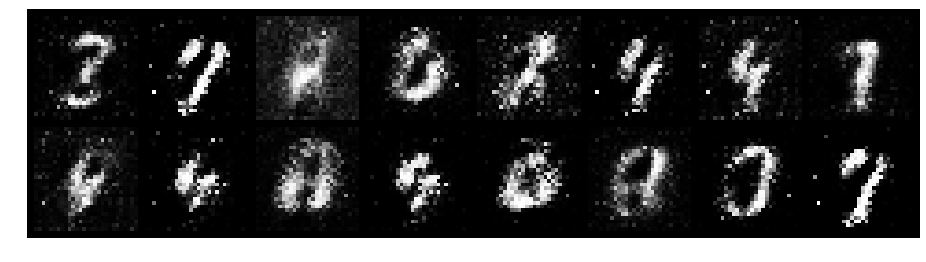

Epoch: [9/200], Batch Num: [500/600]
Discriminator Loss: 0.6391, Generator Loss: 2.0465
D(x): 0.7687, D(G(z)): 0.1974


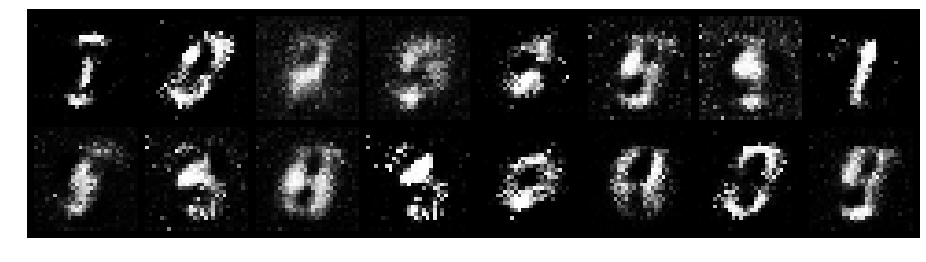

Epoch: [10/200], Batch Num: [0/600]
Discriminator Loss: 0.8662, Generator Loss: 1.7904
D(x): 0.8043, D(G(z)): 0.2853


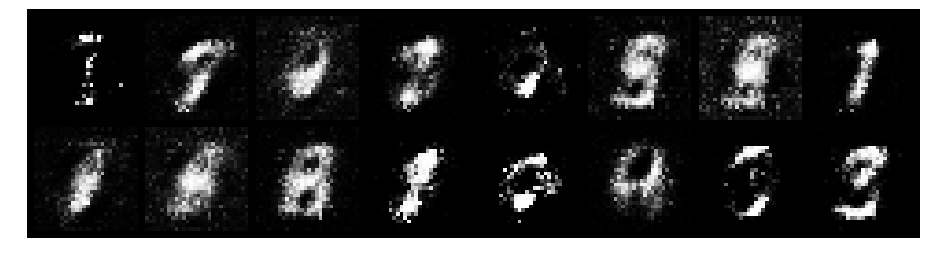

Epoch: [10/200], Batch Num: [100/600]
Discriminator Loss: 0.6976, Generator Loss: 2.8291
D(x): 0.8322, D(G(z)): 0.2418


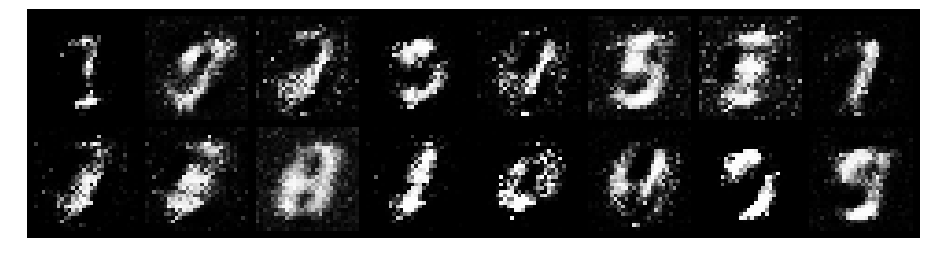

Epoch: [10/200], Batch Num: [200/600]
Discriminator Loss: 0.6036, Generator Loss: 2.6615
D(x): 0.8209, D(G(z)): 0.1881


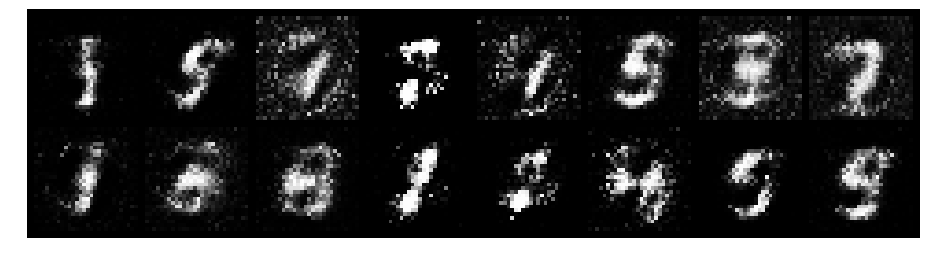

Epoch: [10/200], Batch Num: [300/600]
Discriminator Loss: 0.7014, Generator Loss: 2.0322
D(x): 0.7330, D(G(z)): 0.1932


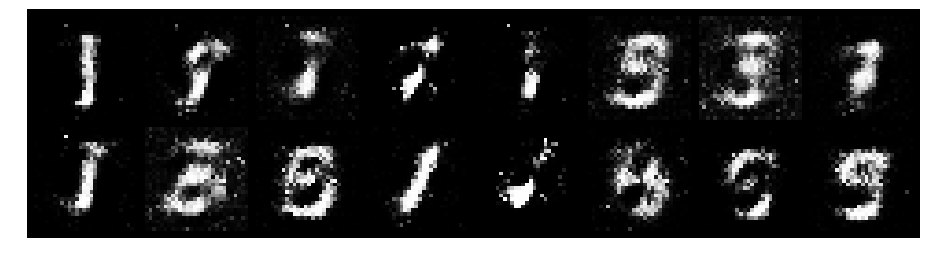

Epoch: [10/200], Batch Num: [400/600]
Discriminator Loss: 0.6784, Generator Loss: 2.8428
D(x): 0.8501, D(G(z)): 0.2572


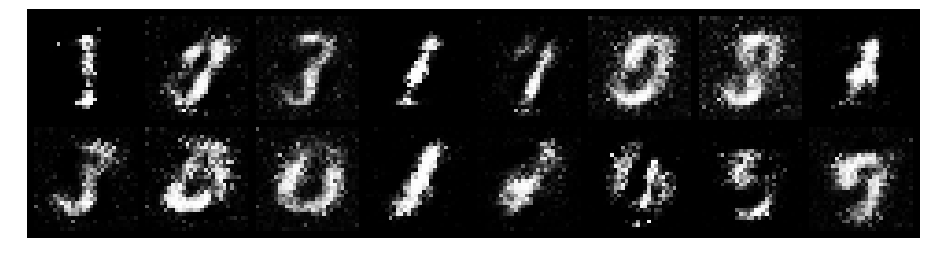

Epoch: [10/200], Batch Num: [500/600]
Discriminator Loss: 0.6461, Generator Loss: 2.6314
D(x): 0.8038, D(G(z)): 0.2489


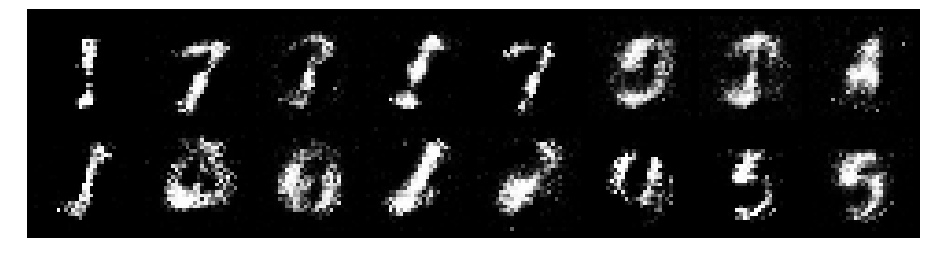

Epoch: [11/200], Batch Num: [0/600]
Discriminator Loss: 0.6244, Generator Loss: 2.8529
D(x): 0.7672, D(G(z)): 0.1438


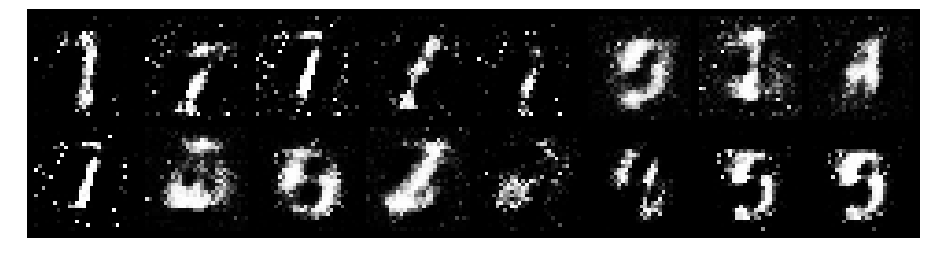

Epoch: [11/200], Batch Num: [100/600]
Discriminator Loss: 0.5399, Generator Loss: 2.7312
D(x): 0.8029, D(G(z)): 0.1695


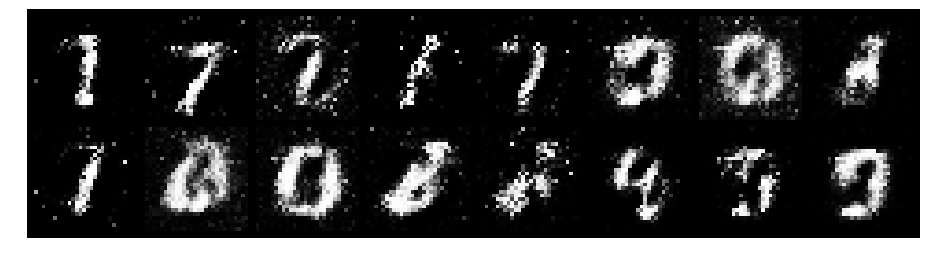

Epoch: [11/200], Batch Num: [200/600]
Discriminator Loss: 0.5031, Generator Loss: 1.8110
D(x): 0.8530, D(G(z)): 0.2061


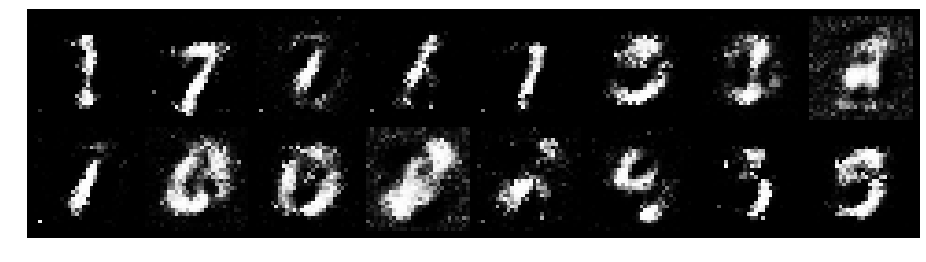

Epoch: [11/200], Batch Num: [300/600]
Discriminator Loss: 0.9412, Generator Loss: 1.4009
D(x): 0.7834, D(G(z)): 0.3570


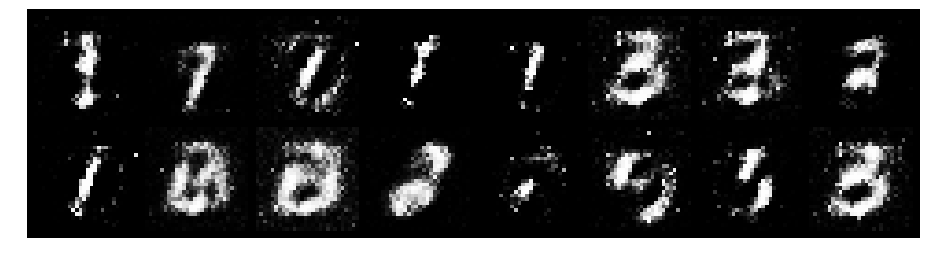

Epoch: [11/200], Batch Num: [400/600]
Discriminator Loss: 0.6452, Generator Loss: 1.5784
D(x): 0.8383, D(G(z)): 0.2710


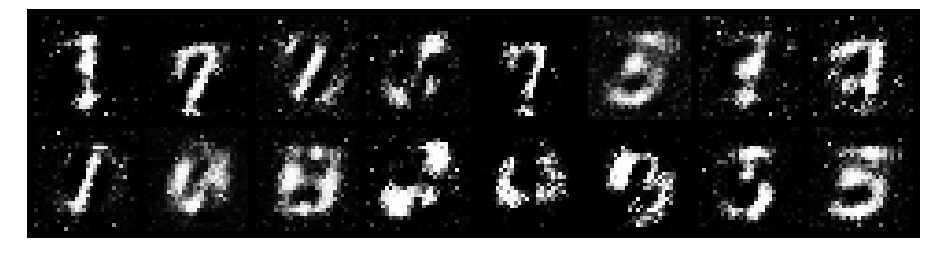

Epoch: [11/200], Batch Num: [500/600]
Discriminator Loss: 0.6352, Generator Loss: 2.3374
D(x): 0.8623, D(G(z)): 0.2833


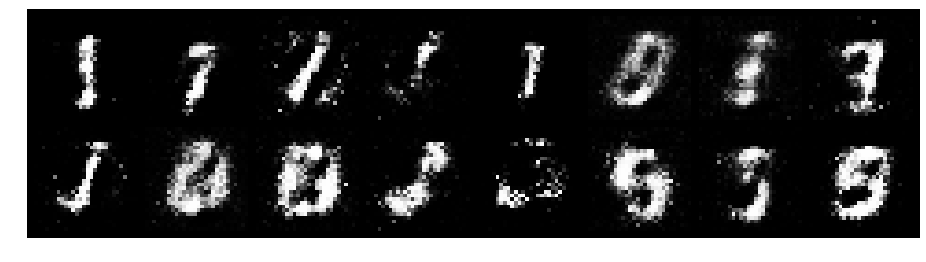

Epoch: [12/200], Batch Num: [0/600]
Discriminator Loss: 0.8360, Generator Loss: 1.9234
D(x): 0.8497, D(G(z)): 0.3712


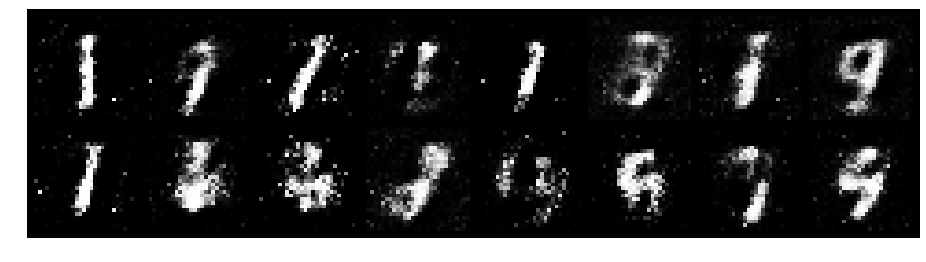

Epoch: [12/200], Batch Num: [100/600]
Discriminator Loss: 0.9137, Generator Loss: 2.4392
D(x): 0.6568, D(G(z)): 0.1798


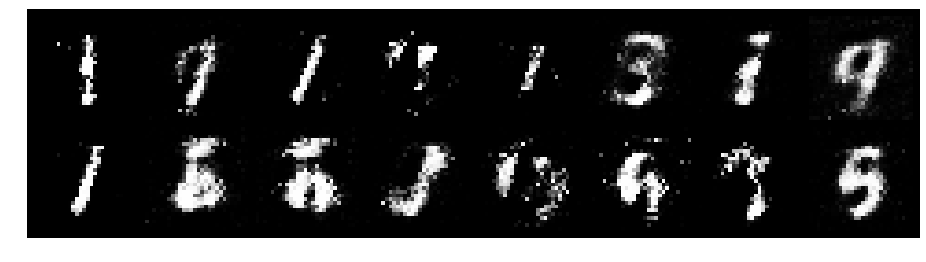

Epoch: [12/200], Batch Num: [200/600]
Discriminator Loss: 0.8493, Generator Loss: 2.3236
D(x): 0.7722, D(G(z)): 0.2598


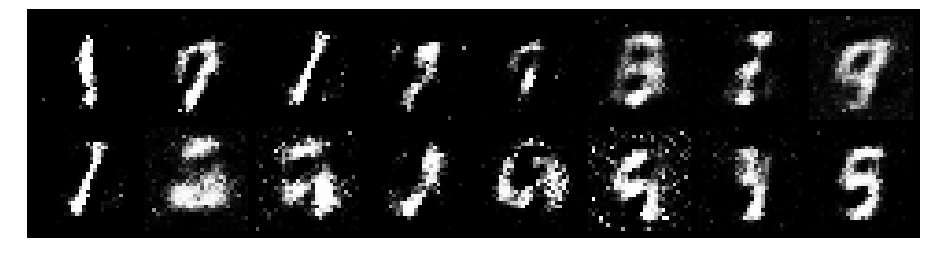

Epoch: [12/200], Batch Num: [300/600]
Discriminator Loss: 0.6071, Generator Loss: 2.1488
D(x): 0.8743, D(G(z)): 0.2854


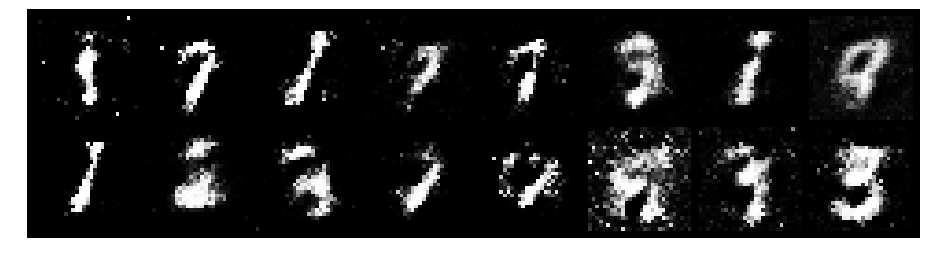

Epoch: [12/200], Batch Num: [400/600]
Discriminator Loss: 0.9688, Generator Loss: 2.4437
D(x): 0.6449, D(G(z)): 0.1509


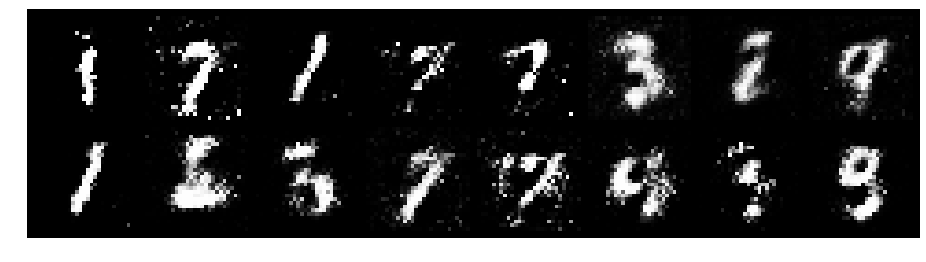

Epoch: [12/200], Batch Num: [500/600]
Discriminator Loss: 0.6322, Generator Loss: 2.1658
D(x): 0.8175, D(G(z)): 0.2445


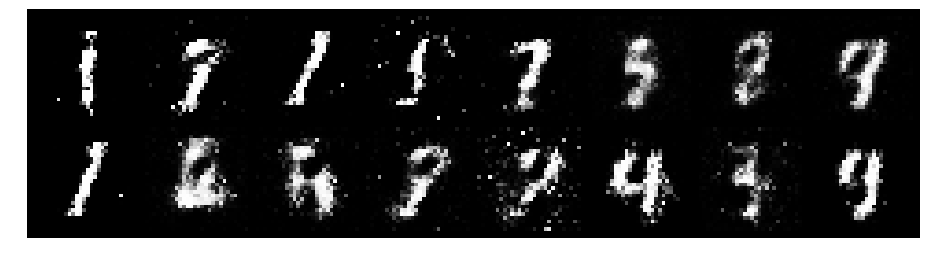

Epoch: [13/200], Batch Num: [0/600]
Discriminator Loss: 0.9082, Generator Loss: 2.4170
D(x): 0.7245, D(G(z)): 0.2206


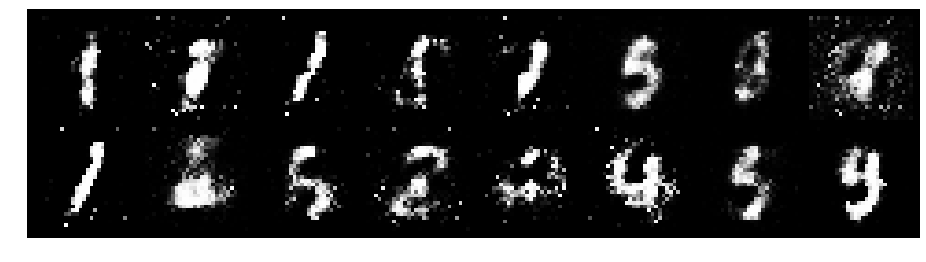

Epoch: [13/200], Batch Num: [100/600]
Discriminator Loss: 0.8657, Generator Loss: 2.0567
D(x): 0.6834, D(G(z)): 0.2317


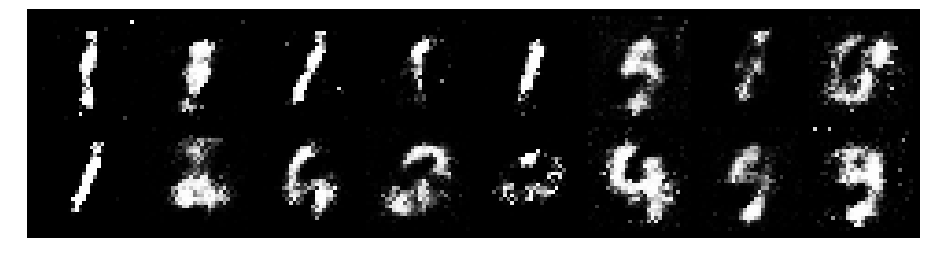

Epoch: [13/200], Batch Num: [200/600]
Discriminator Loss: 0.7827, Generator Loss: 1.9570
D(x): 0.7440, D(G(z)): 0.2421


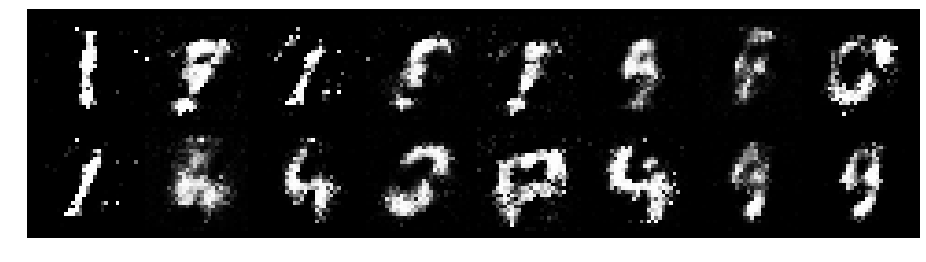

Epoch: [13/200], Batch Num: [300/600]
Discriminator Loss: 0.7225, Generator Loss: 2.2912
D(x): 0.7941, D(G(z)): 0.2353


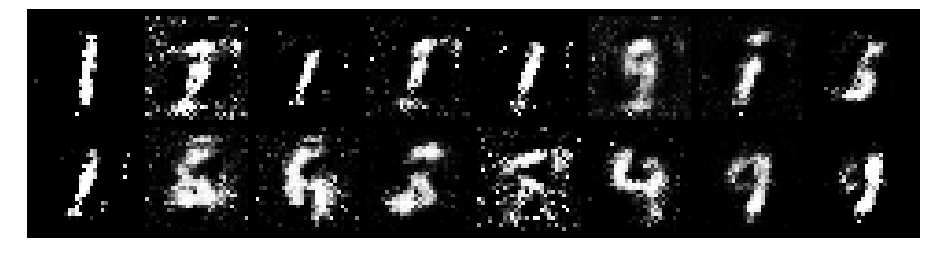

Epoch: [13/200], Batch Num: [400/600]
Discriminator Loss: 0.5353, Generator Loss: 2.9914
D(x): 0.8179, D(G(z)): 0.1785


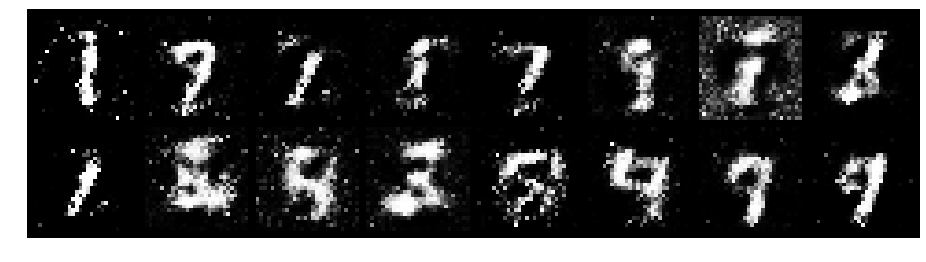

Epoch: [13/200], Batch Num: [500/600]
Discriminator Loss: 0.5979, Generator Loss: 2.4260
D(x): 0.8285, D(G(z)): 0.1961


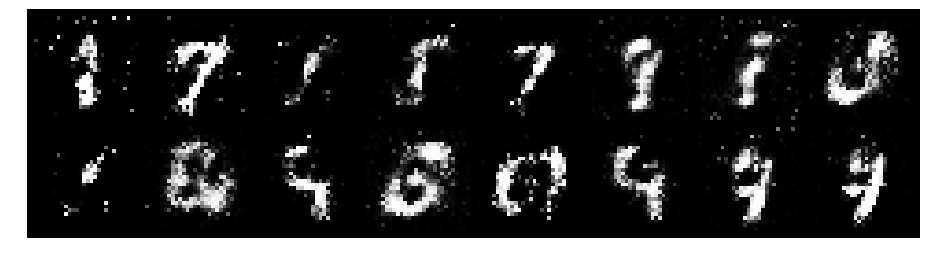

Epoch: [14/200], Batch Num: [0/600]
Discriminator Loss: 0.7906, Generator Loss: 2.0471
D(x): 0.7217, D(G(z)): 0.2196


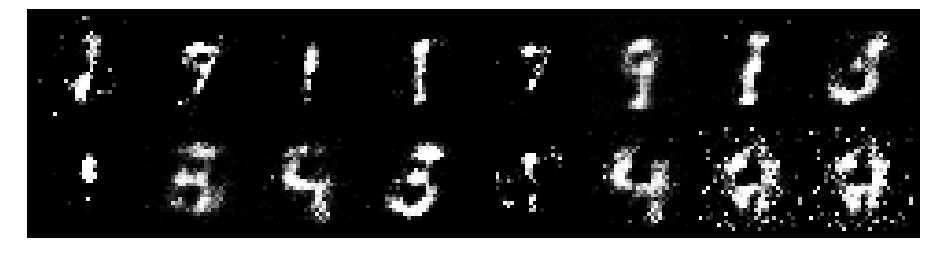

Epoch: [14/200], Batch Num: [100/600]
Discriminator Loss: 0.7193, Generator Loss: 2.0146
D(x): 0.7876, D(G(z)): 0.2727


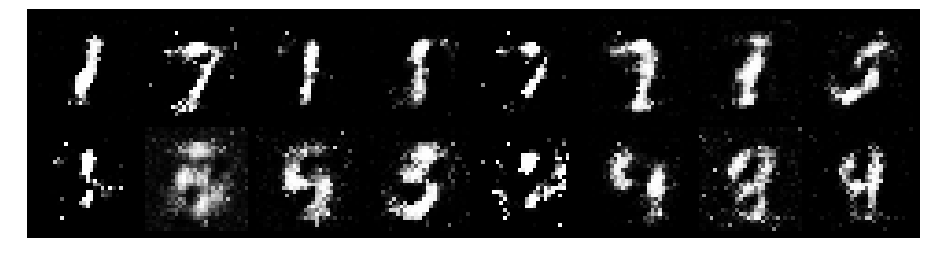

Epoch: [14/200], Batch Num: [200/600]
Discriminator Loss: 0.6511, Generator Loss: 2.3508
D(x): 0.7219, D(G(z)): 0.1354


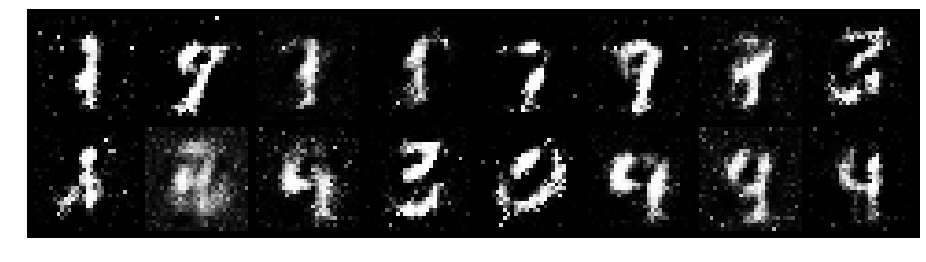

Epoch: [14/200], Batch Num: [300/600]
Discriminator Loss: 0.6368, Generator Loss: 1.8402
D(x): 0.7771, D(G(z)): 0.2341


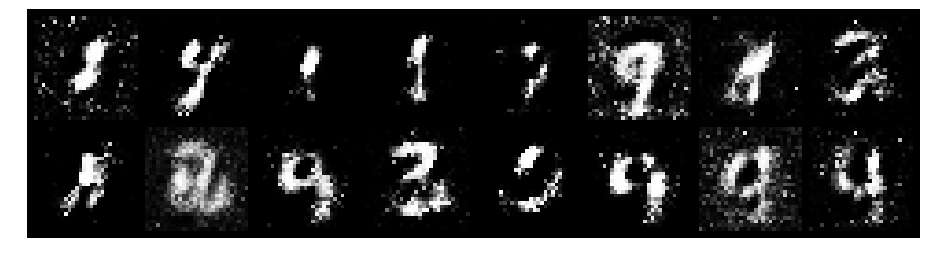

Epoch: [14/200], Batch Num: [400/600]
Discriminator Loss: 0.8446, Generator Loss: 1.7501
D(x): 0.7094, D(G(z)): 0.2706


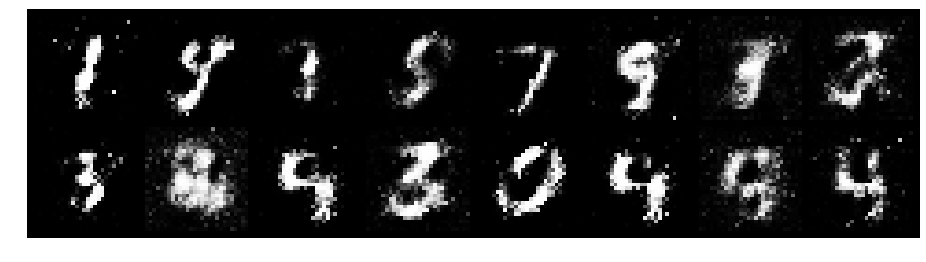

Epoch: [14/200], Batch Num: [500/600]
Discriminator Loss: 0.7475, Generator Loss: 1.8276
D(x): 0.7184, D(G(z)): 0.1990


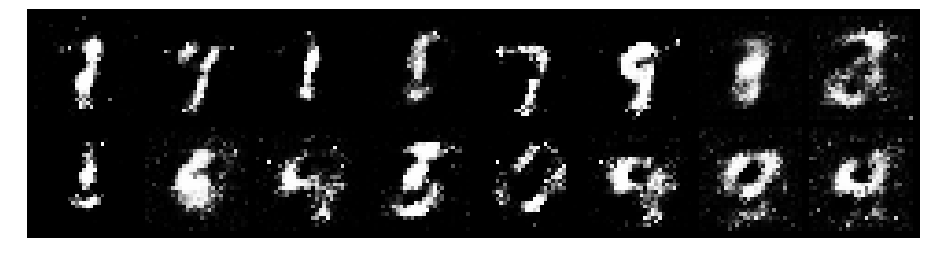

Epoch: [15/200], Batch Num: [0/600]
Discriminator Loss: 0.8738, Generator Loss: 2.5579
D(x): 0.7140, D(G(z)): 0.1809


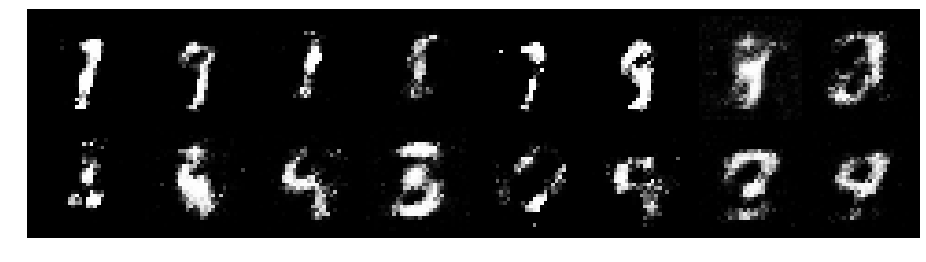

Epoch: [15/200], Batch Num: [100/600]
Discriminator Loss: 0.7742, Generator Loss: 2.0173
D(x): 0.7642, D(G(z)): 0.2574


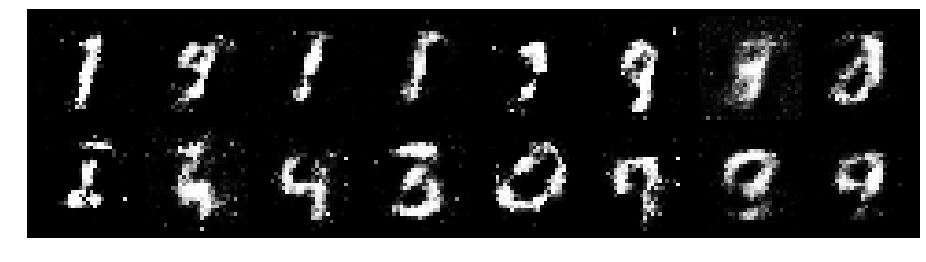

Epoch: [15/200], Batch Num: [200/600]
Discriminator Loss: 0.9212, Generator Loss: 1.7841
D(x): 0.6971, D(G(z)): 0.2364


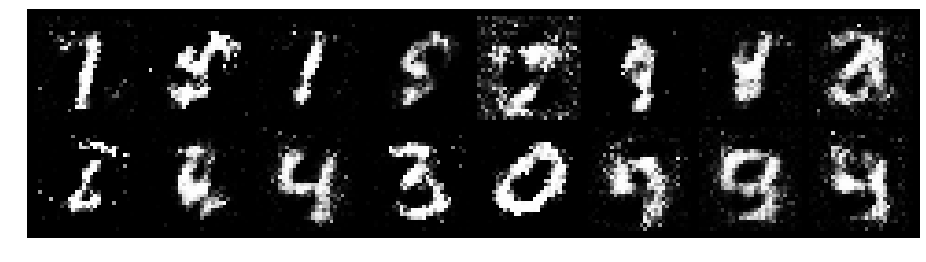

Epoch: [15/200], Batch Num: [300/600]
Discriminator Loss: 0.7661, Generator Loss: 2.1146
D(x): 0.6766, D(G(z)): 0.1728


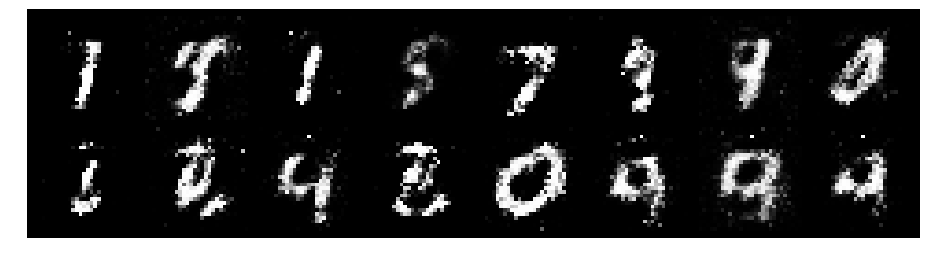

Epoch: [15/200], Batch Num: [400/600]
Discriminator Loss: 0.7143, Generator Loss: 1.9550
D(x): 0.7629, D(G(z)): 0.2410


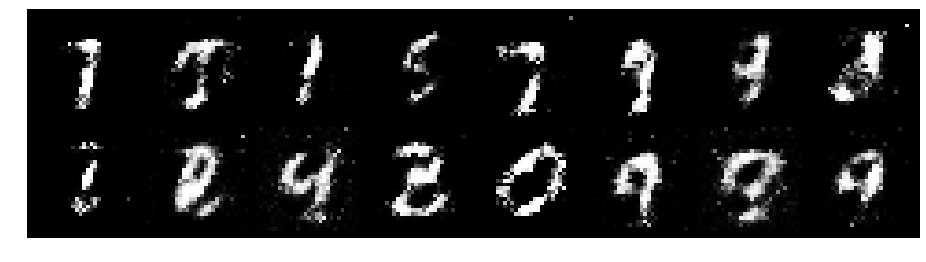

Epoch: [15/200], Batch Num: [500/600]
Discriminator Loss: 0.9374, Generator Loss: 1.6258
D(x): 0.6433, D(G(z)): 0.2210


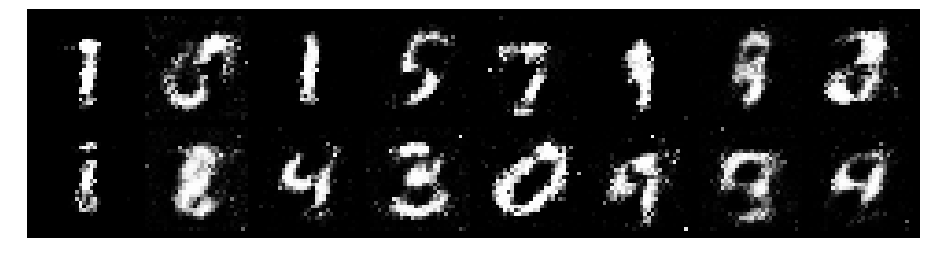

Epoch: [16/200], Batch Num: [0/600]
Discriminator Loss: 0.7505, Generator Loss: 1.6113
D(x): 0.7957, D(G(z)): 0.2799


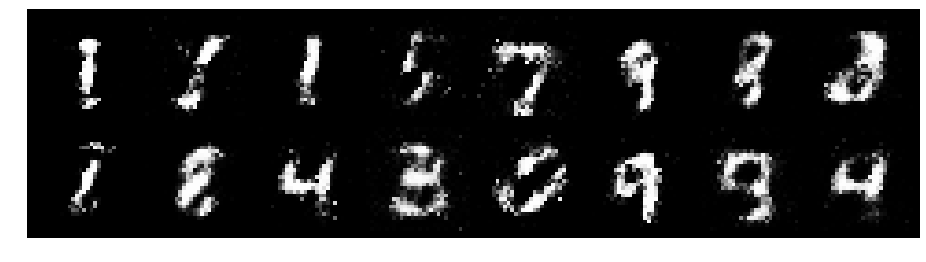

Epoch: [16/200], Batch Num: [100/600]
Discriminator Loss: 0.9794, Generator Loss: 2.1956
D(x): 0.8190, D(G(z)): 0.4096


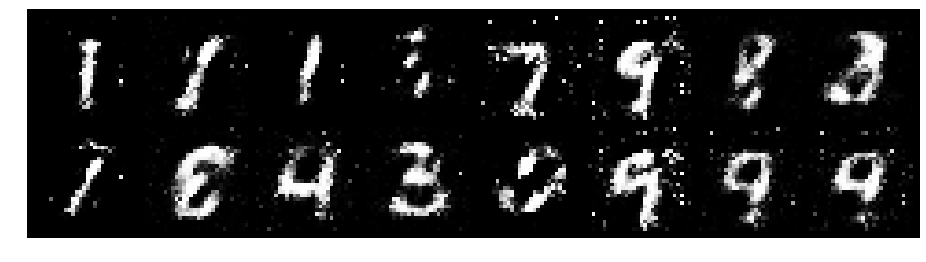

Epoch: [16/200], Batch Num: [200/600]
Discriminator Loss: 0.7847, Generator Loss: 1.5559
D(x): 0.7673, D(G(z)): 0.2873


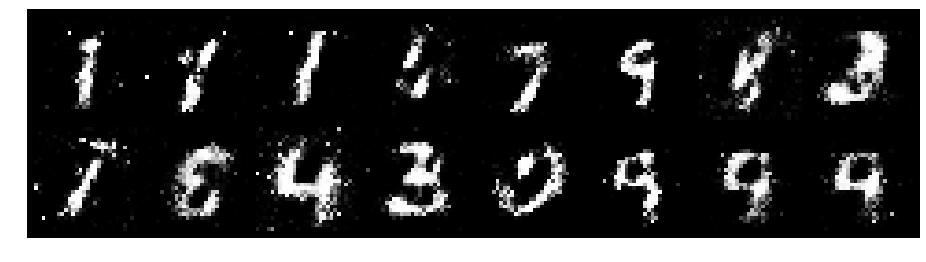

Epoch: [16/200], Batch Num: [300/600]
Discriminator Loss: 0.7022, Generator Loss: 2.3041
D(x): 0.7804, D(G(z)): 0.2282


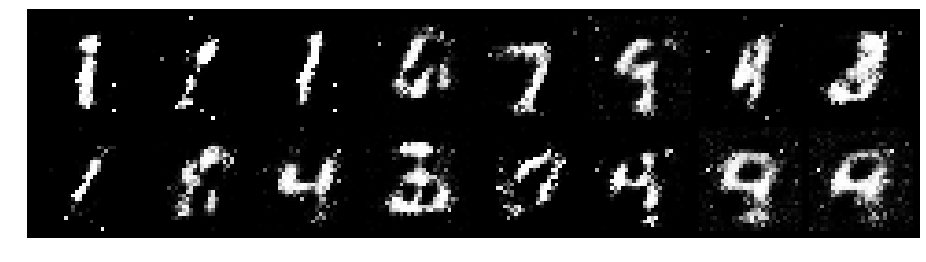

Epoch: [16/200], Batch Num: [400/600]
Discriminator Loss: 0.8744, Generator Loss: 2.0384
D(x): 0.7081, D(G(z)): 0.2447


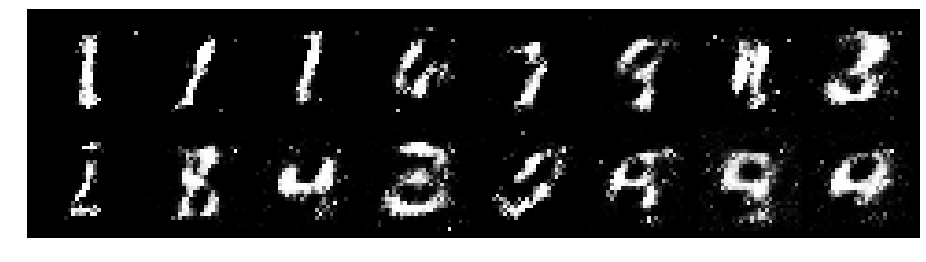

Epoch: [16/200], Batch Num: [500/600]
Discriminator Loss: 0.6620, Generator Loss: 1.9708
D(x): 0.7467, D(G(z)): 0.2157


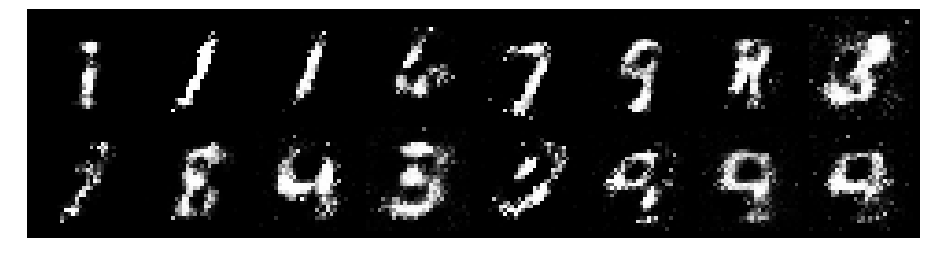

Epoch: [17/200], Batch Num: [0/600]
Discriminator Loss: 0.7869, Generator Loss: 1.6128
D(x): 0.8159, D(G(z)): 0.3402


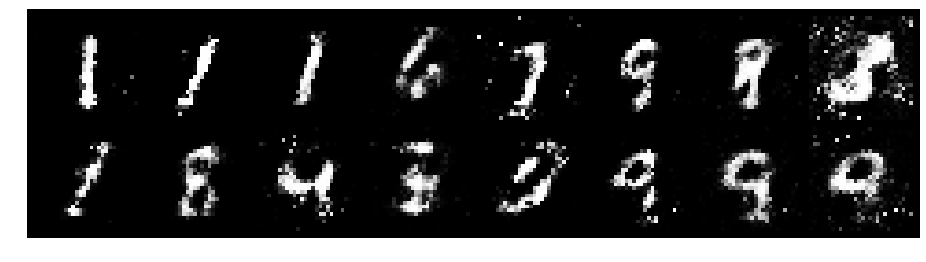

Epoch: [17/200], Batch Num: [100/600]
Discriminator Loss: 0.7994, Generator Loss: 1.7858
D(x): 0.7871, D(G(z)): 0.2948


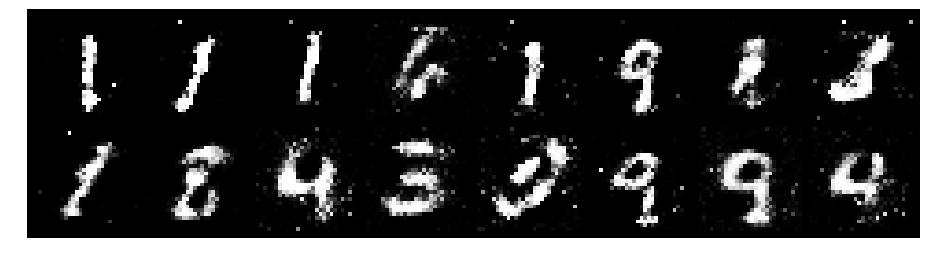

Epoch: [17/200], Batch Num: [200/600]
Discriminator Loss: 0.9228, Generator Loss: 1.6442
D(x): 0.7278, D(G(z)): 0.3150


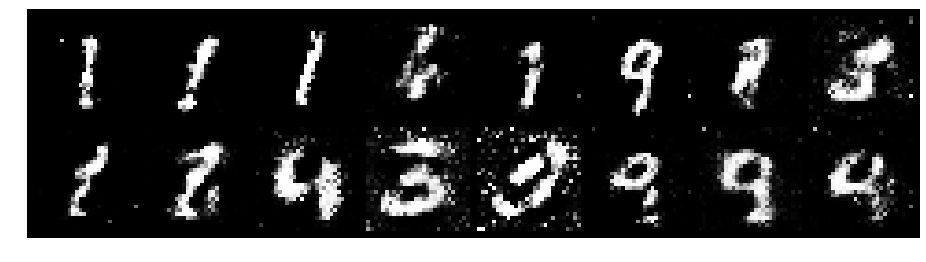

Epoch: [17/200], Batch Num: [300/600]
Discriminator Loss: 0.8571, Generator Loss: 2.2481
D(x): 0.7873, D(G(z)): 0.2879


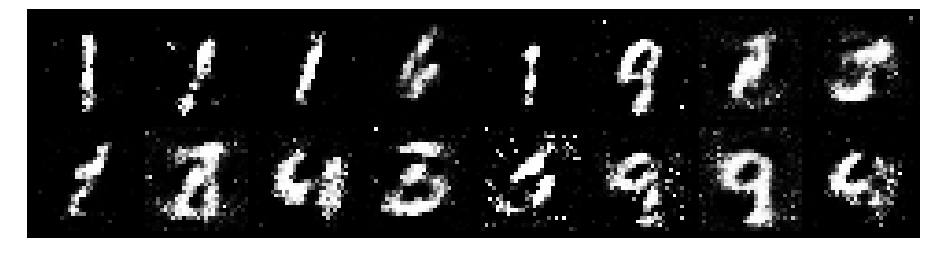

Epoch: [17/200], Batch Num: [400/600]
Discriminator Loss: 0.8145, Generator Loss: 1.8910
D(x): 0.8244, D(G(z)): 0.3118


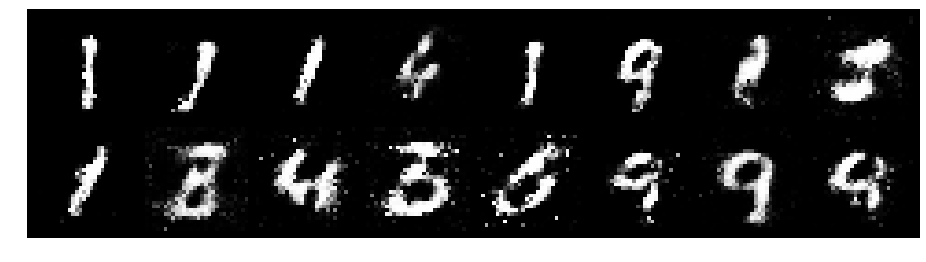

Epoch: [17/200], Batch Num: [500/600]
Discriminator Loss: 0.9050, Generator Loss: 2.3767
D(x): 0.6743, D(G(z)): 0.1760


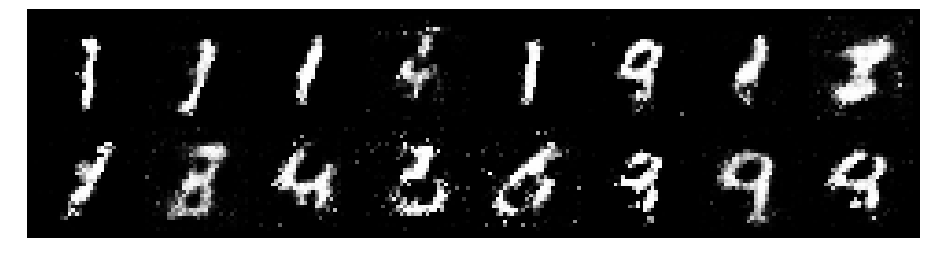

Epoch: [18/200], Batch Num: [0/600]
Discriminator Loss: 0.7363, Generator Loss: 1.7473
D(x): 0.7901, D(G(z)): 0.2527


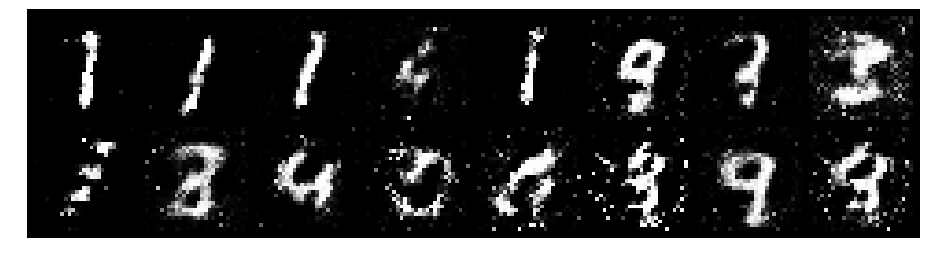

Epoch: [18/200], Batch Num: [100/600]
Discriminator Loss: 0.7466, Generator Loss: 1.9826
D(x): 0.7674, D(G(z)): 0.2759


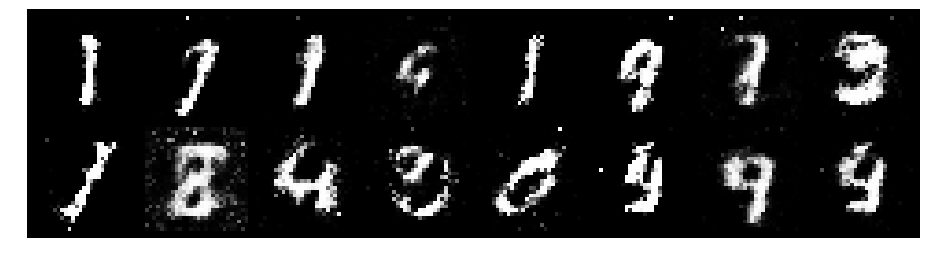

Epoch: [18/200], Batch Num: [200/600]
Discriminator Loss: 0.8880, Generator Loss: 1.6658
D(x): 0.7302, D(G(z)): 0.3396


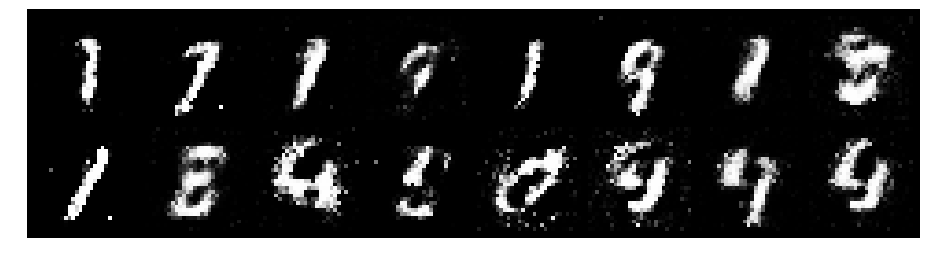

Epoch: [18/200], Batch Num: [300/600]
Discriminator Loss: 0.8351, Generator Loss: 1.9508
D(x): 0.7063, D(G(z)): 0.2257


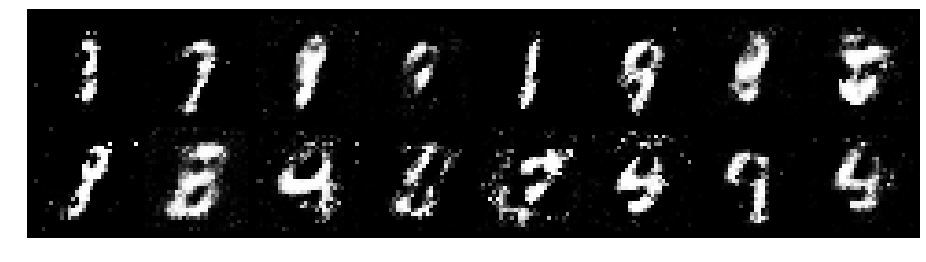

Epoch: [18/200], Batch Num: [400/600]
Discriminator Loss: 0.9909, Generator Loss: 1.0859
D(x): 0.7224, D(G(z)): 0.3596


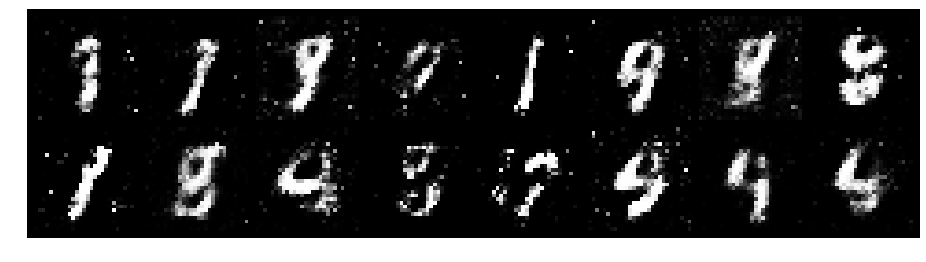

Epoch: [18/200], Batch Num: [500/600]
Discriminator Loss: 0.8326, Generator Loss: 1.6595
D(x): 0.6772, D(G(z)): 0.2115


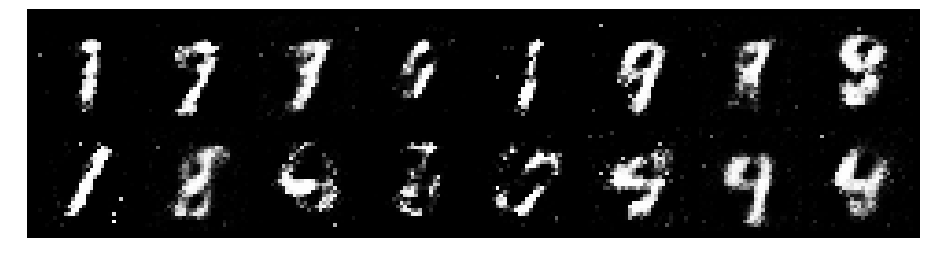

Epoch: [19/200], Batch Num: [0/600]
Discriminator Loss: 0.8632, Generator Loss: 1.9603
D(x): 0.7784, D(G(z)): 0.3234


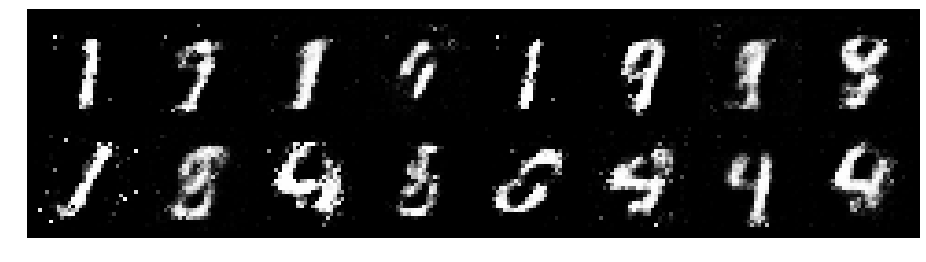

Epoch: [19/200], Batch Num: [100/600]
Discriminator Loss: 1.0562, Generator Loss: 1.5973
D(x): 0.6800, D(G(z)): 0.3059


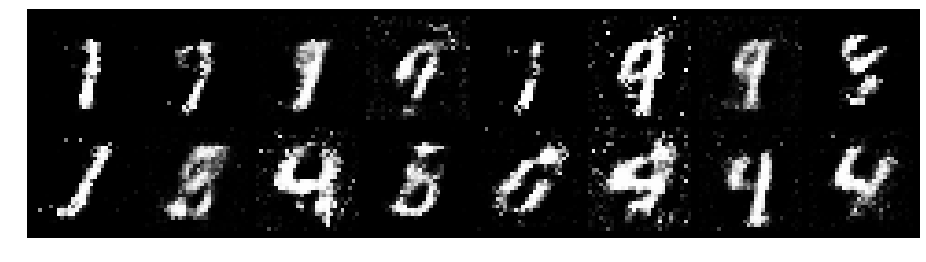

Epoch: [19/200], Batch Num: [200/600]
Discriminator Loss: 0.9333, Generator Loss: 1.9521
D(x): 0.7436, D(G(z)): 0.3085


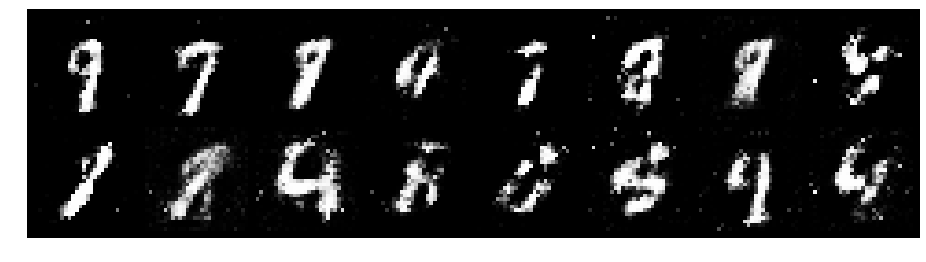

Epoch: [19/200], Batch Num: [300/600]
Discriminator Loss: 0.8052, Generator Loss: 2.2321
D(x): 0.8012, D(G(z)): 0.3095


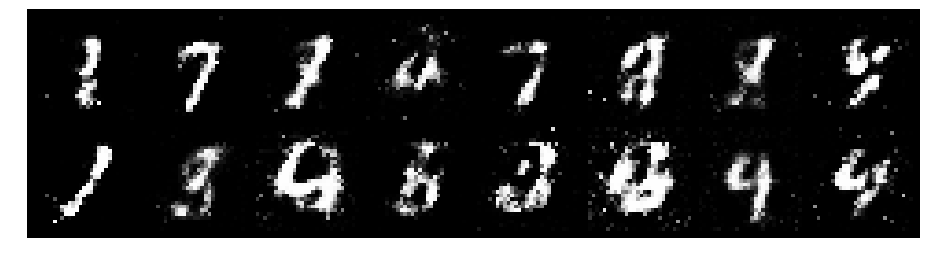

Epoch: [19/200], Batch Num: [400/600]
Discriminator Loss: 0.6384, Generator Loss: 2.0308
D(x): 0.8122, D(G(z)): 0.2484


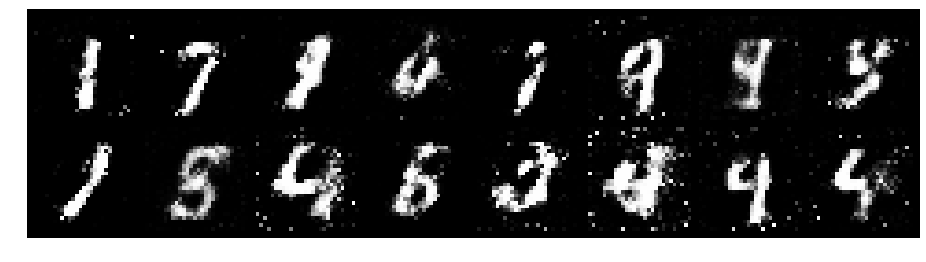

Epoch: [19/200], Batch Num: [500/600]
Discriminator Loss: 0.7183, Generator Loss: 1.7211
D(x): 0.7705, D(G(z)): 0.2344


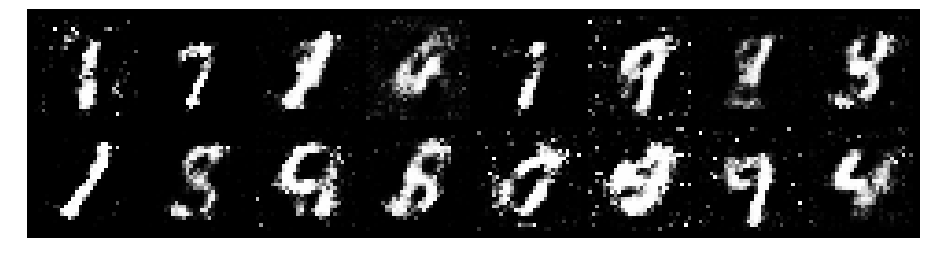

Epoch: [20/200], Batch Num: [0/600]
Discriminator Loss: 0.8861, Generator Loss: 1.3890
D(x): 0.7467, D(G(z)): 0.3268


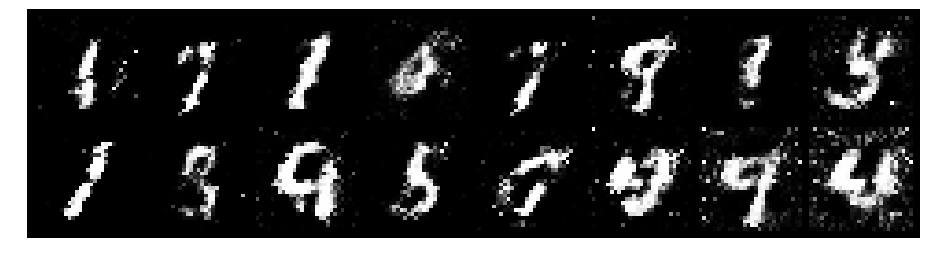

Epoch: [20/200], Batch Num: [100/600]
Discriminator Loss: 0.9992, Generator Loss: 1.5264
D(x): 0.6787, D(G(z)): 0.3098


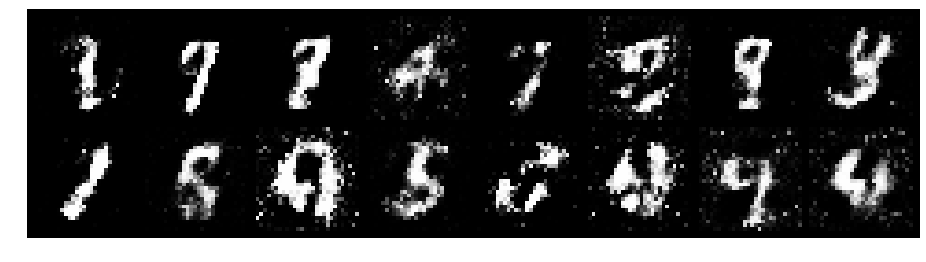

Epoch: [20/200], Batch Num: [200/600]
Discriminator Loss: 1.0610, Generator Loss: 1.0292
D(x): 0.6800, D(G(z)): 0.4321


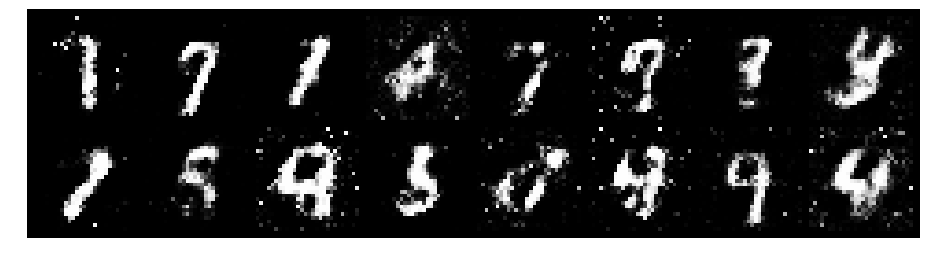

Epoch: [20/200], Batch Num: [300/600]
Discriminator Loss: 0.9500, Generator Loss: 1.6456
D(x): 0.6722, D(G(z)): 0.2929


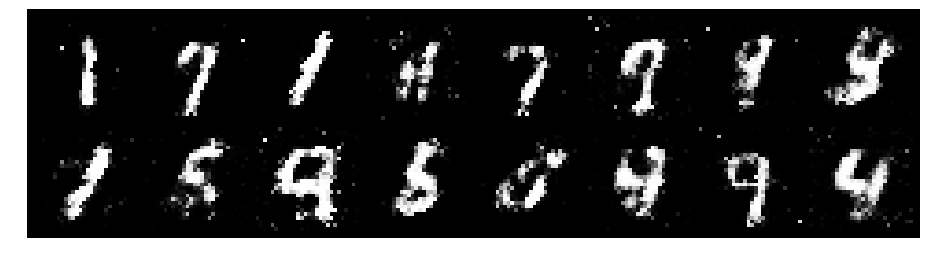

Epoch: [20/200], Batch Num: [400/600]
Discriminator Loss: 0.9950, Generator Loss: 1.8769
D(x): 0.6729, D(G(z)): 0.2991


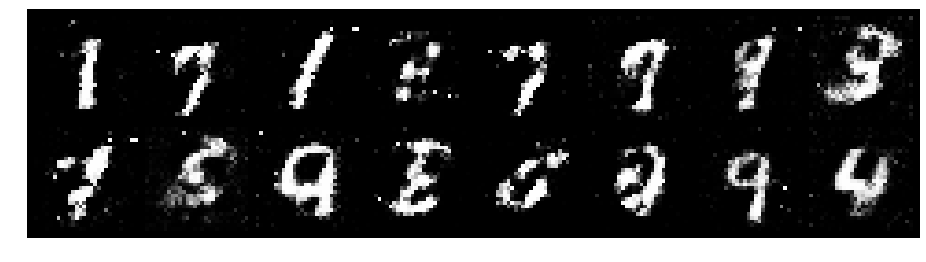

Epoch: [20/200], Batch Num: [500/600]
Discriminator Loss: 0.9338, Generator Loss: 1.8219
D(x): 0.6725, D(G(z)): 0.2506


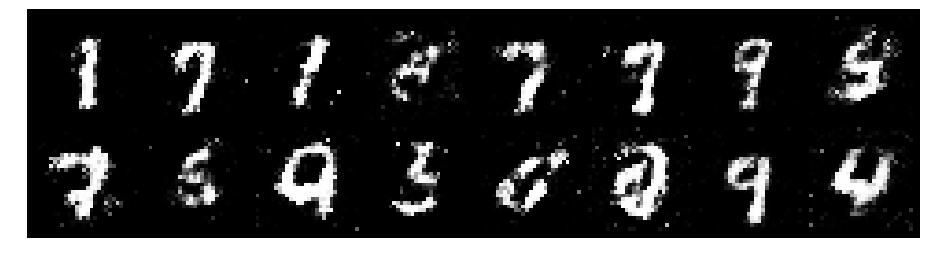

Epoch: [21/200], Batch Num: [0/600]
Discriminator Loss: 0.7261, Generator Loss: 1.8980
D(x): 0.7186, D(G(z)): 0.1908


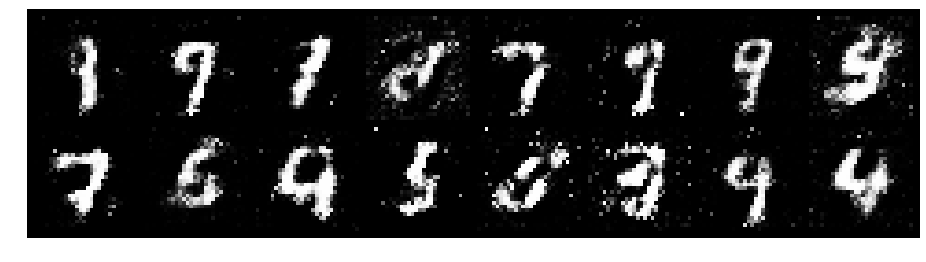

Epoch: [21/200], Batch Num: [100/600]
Discriminator Loss: 0.7693, Generator Loss: 2.1212
D(x): 0.6811, D(G(z)): 0.2077


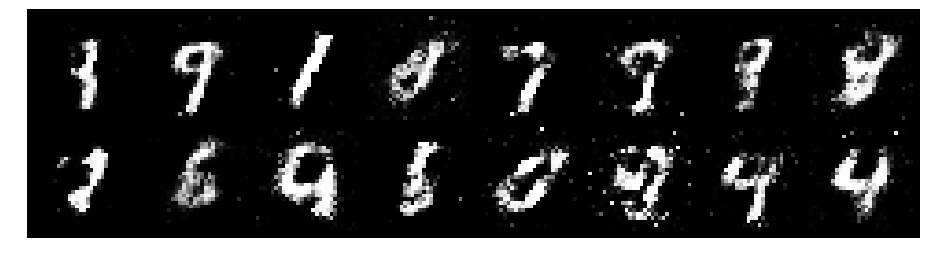

Epoch: [21/200], Batch Num: [200/600]
Discriminator Loss: 0.9653, Generator Loss: 1.6450
D(x): 0.6647, D(G(z)): 0.2930


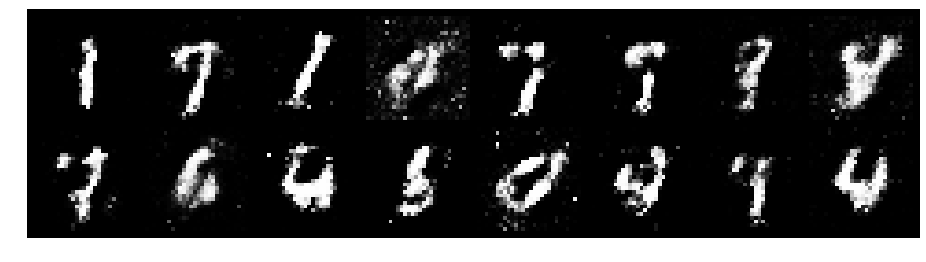

Epoch: [21/200], Batch Num: [300/600]
Discriminator Loss: 0.8047, Generator Loss: 1.6572
D(x): 0.7439, D(G(z)): 0.2979


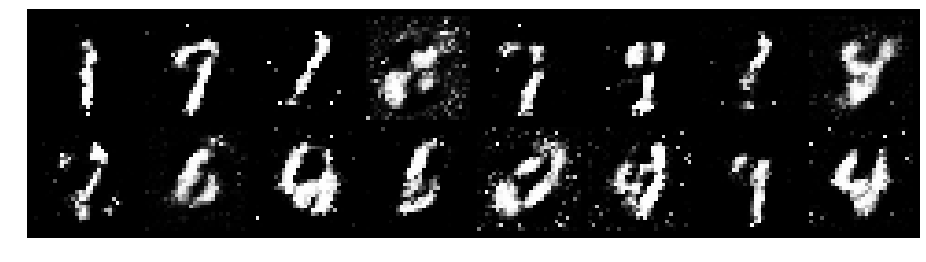

Epoch: [21/200], Batch Num: [400/600]
Discriminator Loss: 0.9916, Generator Loss: 1.3180
D(x): 0.6712, D(G(z)): 0.3065


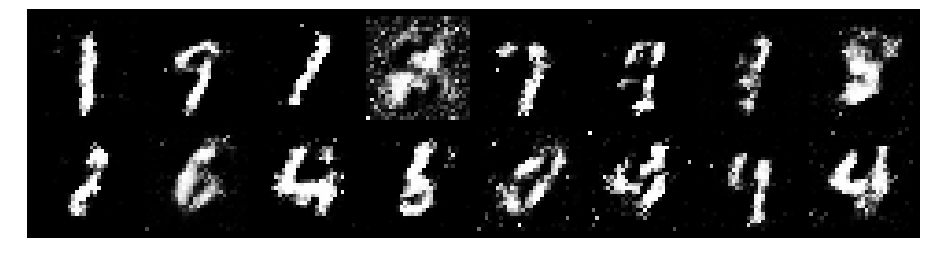

Epoch: [21/200], Batch Num: [500/600]
Discriminator Loss: 0.8514, Generator Loss: 1.5556
D(x): 0.6841, D(G(z)): 0.2591


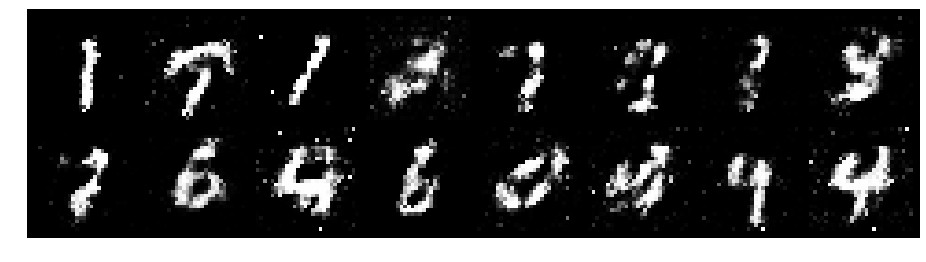

Epoch: [22/200], Batch Num: [0/600]
Discriminator Loss: 1.0165, Generator Loss: 1.3641
D(x): 0.6502, D(G(z)): 0.3035


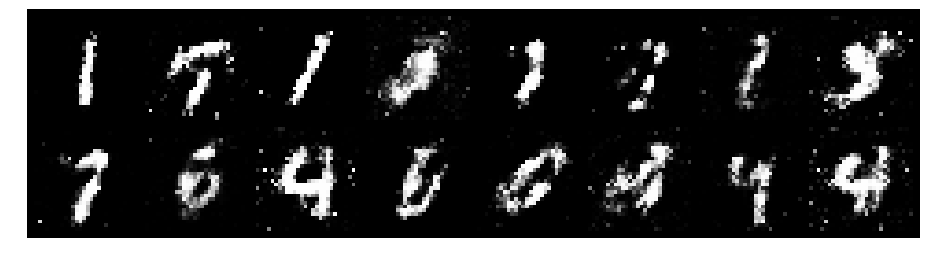

Epoch: [22/200], Batch Num: [100/600]
Discriminator Loss: 0.8877, Generator Loss: 1.4268
D(x): 0.7596, D(G(z)): 0.3312


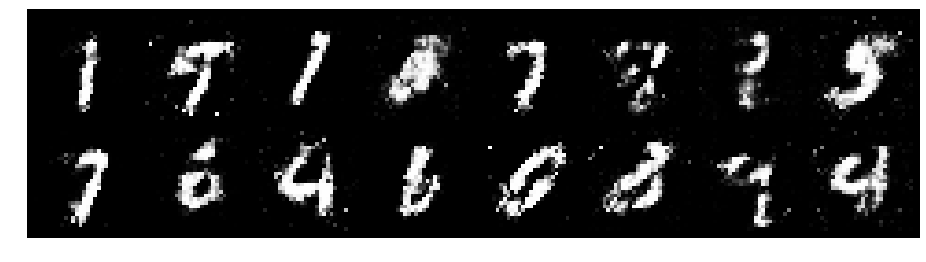

Epoch: [22/200], Batch Num: [200/600]
Discriminator Loss: 0.9347, Generator Loss: 1.5251
D(x): 0.7468, D(G(z)): 0.3467


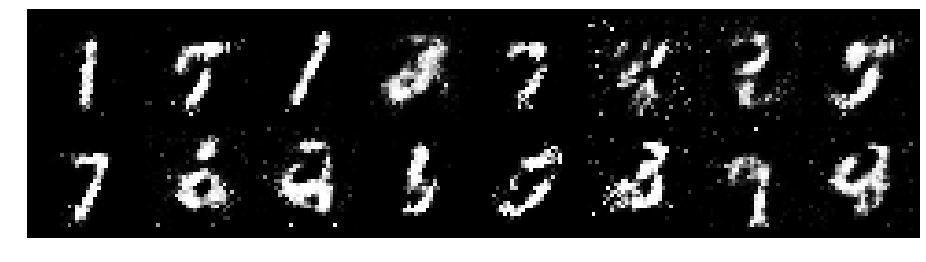

Epoch: [22/200], Batch Num: [300/600]
Discriminator Loss: 0.8029, Generator Loss: 1.3965
D(x): 0.7460, D(G(z)): 0.2981


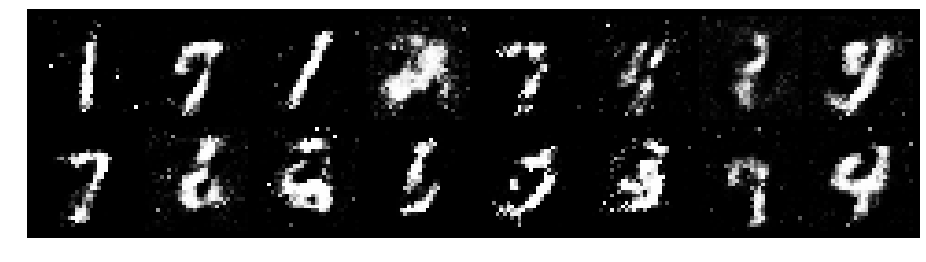

Epoch: [22/200], Batch Num: [400/600]
Discriminator Loss: 0.9175, Generator Loss: 1.3308
D(x): 0.7081, D(G(z)): 0.3309


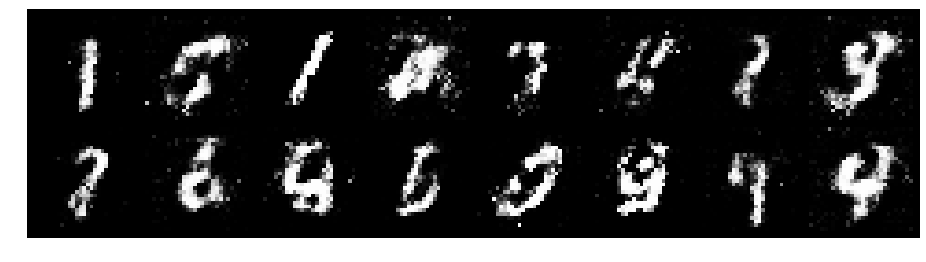

Epoch: [22/200], Batch Num: [500/600]
Discriminator Loss: 0.9192, Generator Loss: 1.5685
D(x): 0.7016, D(G(z)): 0.2991


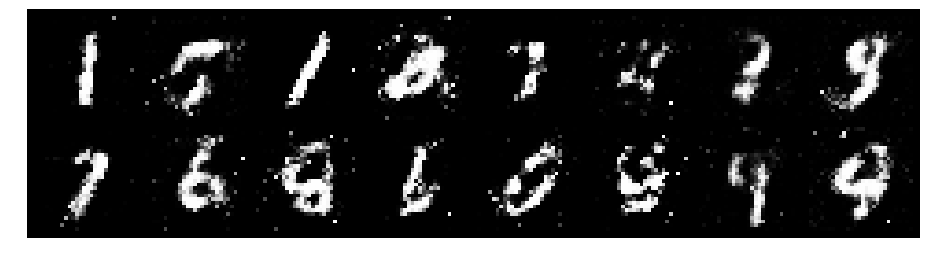

Epoch: [23/200], Batch Num: [0/600]
Discriminator Loss: 0.9810, Generator Loss: 1.3189
D(x): 0.6823, D(G(z)): 0.3428


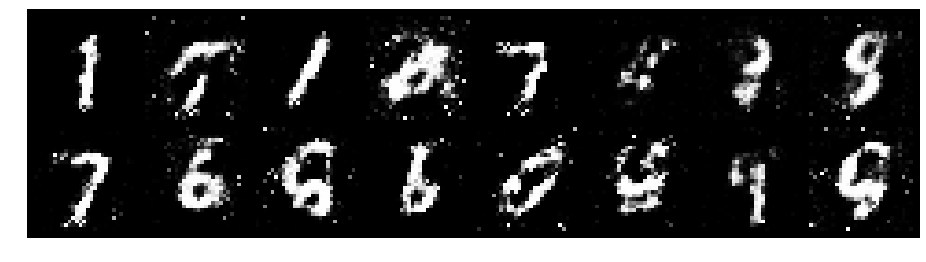

Epoch: [23/200], Batch Num: [100/600]
Discriminator Loss: 0.9488, Generator Loss: 1.4072
D(x): 0.6669, D(G(z)): 0.2875


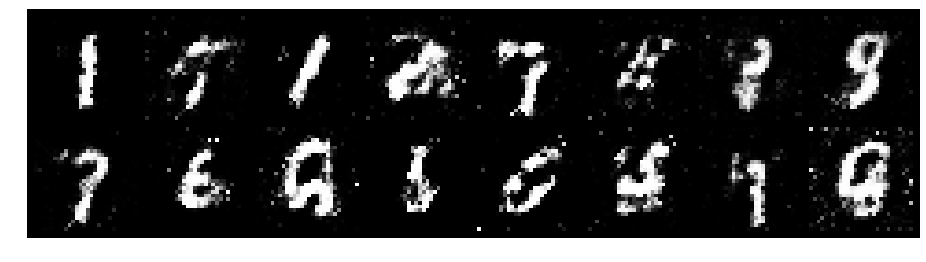

Epoch: [23/200], Batch Num: [200/600]
Discriminator Loss: 1.0333, Generator Loss: 1.1017
D(x): 0.6767, D(G(z)): 0.3744


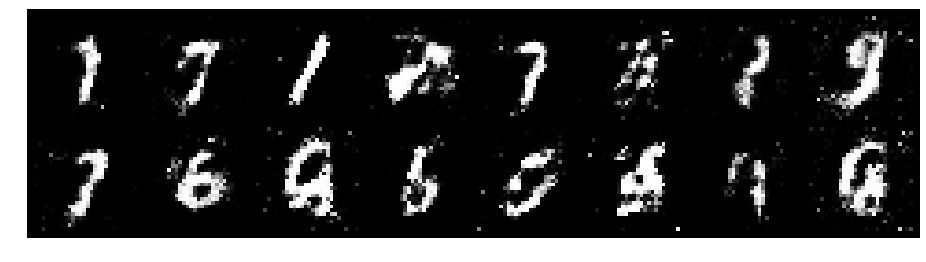

Epoch: [23/200], Batch Num: [300/600]
Discriminator Loss: 1.0514, Generator Loss: 1.4262
D(x): 0.7433, D(G(z)): 0.4180


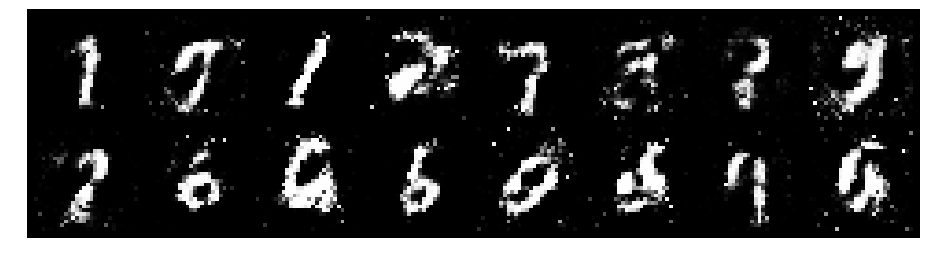

Epoch: [23/200], Batch Num: [400/600]
Discriminator Loss: 0.8073, Generator Loss: 1.6602
D(x): 0.7331, D(G(z)): 0.2893


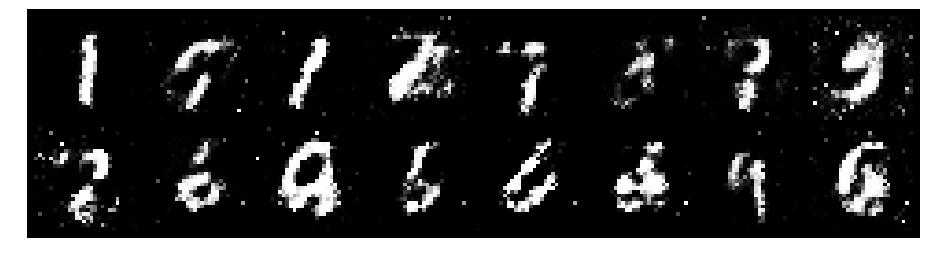

Epoch: [23/200], Batch Num: [500/600]
Discriminator Loss: 1.0556, Generator Loss: 1.5400
D(x): 0.6031, D(G(z)): 0.2760


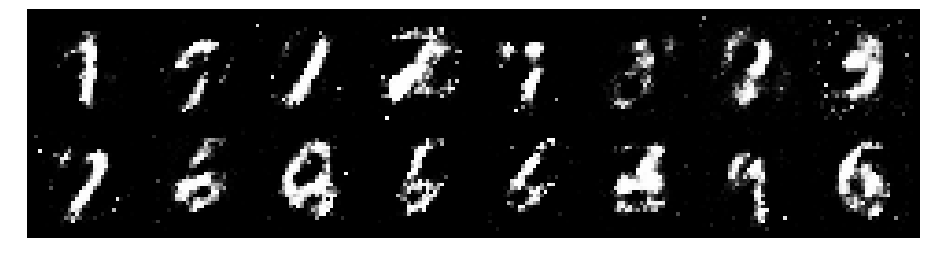

Epoch: [24/200], Batch Num: [0/600]
Discriminator Loss: 0.8195, Generator Loss: 1.6514
D(x): 0.7532, D(G(z)): 0.3069


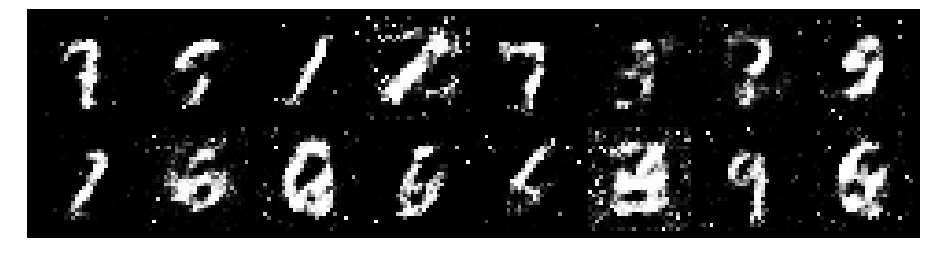

Epoch: [24/200], Batch Num: [100/600]
Discriminator Loss: 0.9009, Generator Loss: 1.3916
D(x): 0.6615, D(G(z)): 0.2806


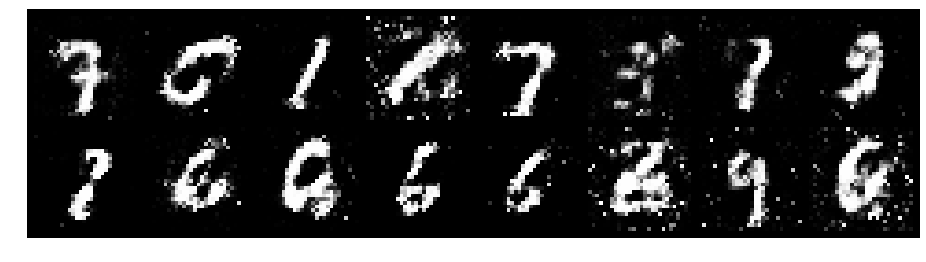

Epoch: [24/200], Batch Num: [200/600]
Discriminator Loss: 0.8270, Generator Loss: 1.3967
D(x): 0.7743, D(G(z)): 0.3095


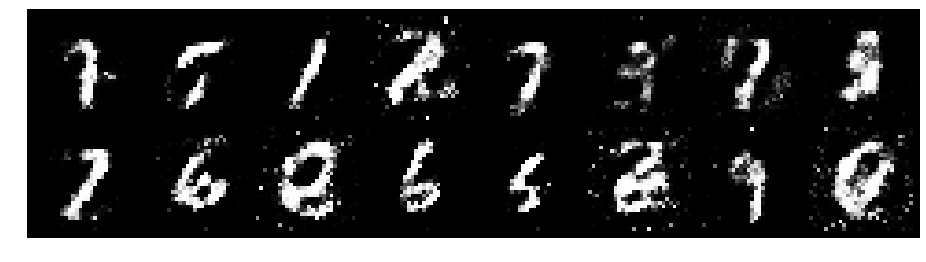

Epoch: [24/200], Batch Num: [300/600]
Discriminator Loss: 0.8518, Generator Loss: 2.0927
D(x): 0.6807, D(G(z)): 0.2622


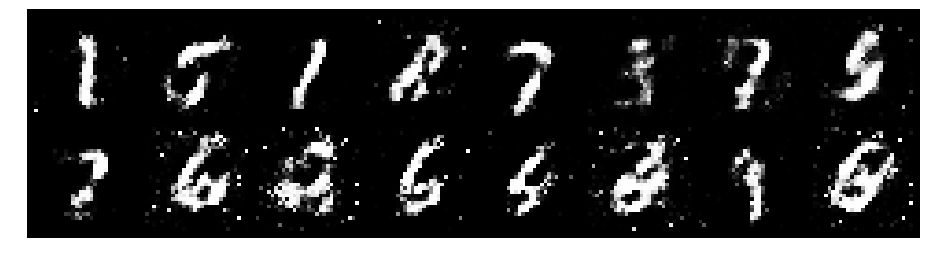

Epoch: [24/200], Batch Num: [400/600]
Discriminator Loss: 0.9081, Generator Loss: 1.5516
D(x): 0.7067, D(G(z)): 0.2976


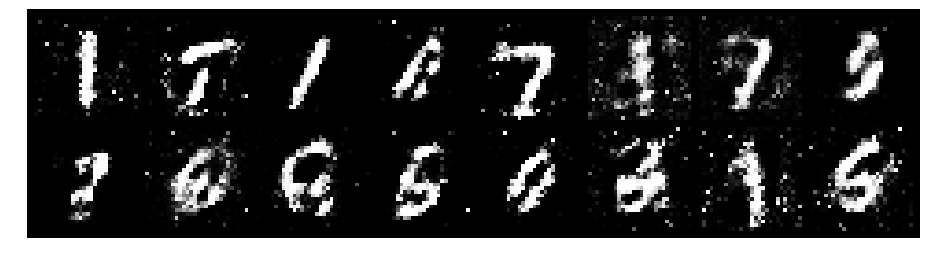

Epoch: [24/200], Batch Num: [500/600]
Discriminator Loss: 1.0792, Generator Loss: 1.1295
D(x): 0.6850, D(G(z)): 0.3896


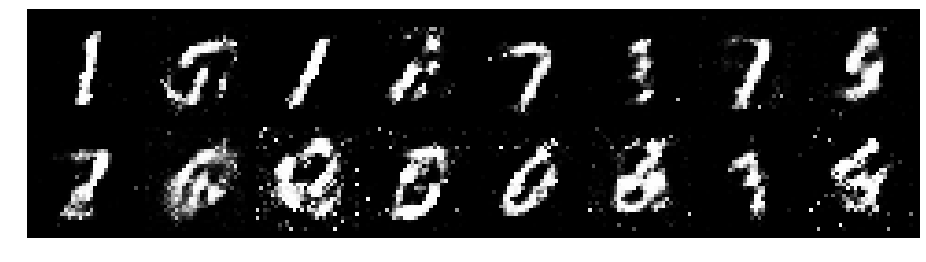

Epoch: [25/200], Batch Num: [0/600]
Discriminator Loss: 0.9961, Generator Loss: 1.2569
D(x): 0.6884, D(G(z)): 0.3840


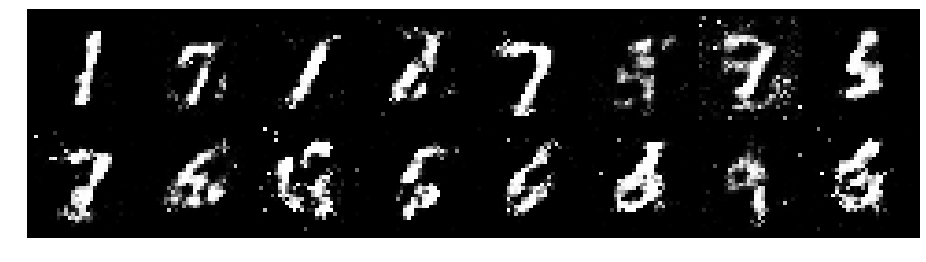

Epoch: [25/200], Batch Num: [100/600]
Discriminator Loss: 1.1452, Generator Loss: 1.1491
D(x): 0.7363, D(G(z)): 0.4408


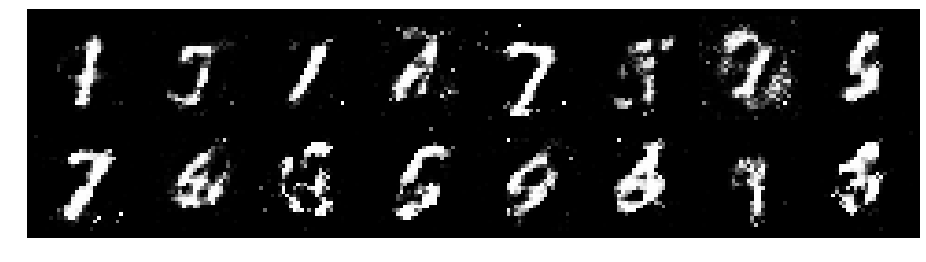

Epoch: [25/200], Batch Num: [200/600]
Discriminator Loss: 1.0134, Generator Loss: 1.3220
D(x): 0.7126, D(G(z)): 0.3704


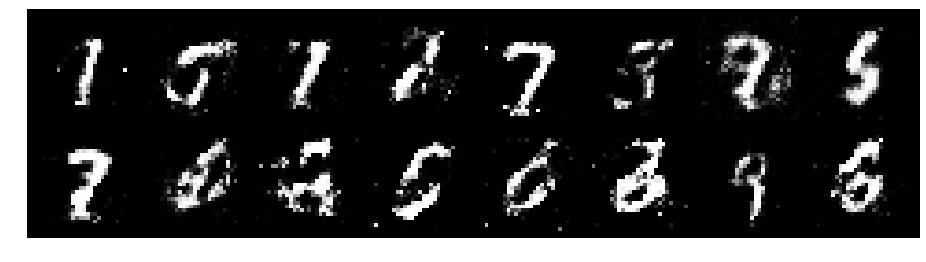

Epoch: [25/200], Batch Num: [300/600]
Discriminator Loss: 0.9608, Generator Loss: 1.5980
D(x): 0.7006, D(G(z)): 0.3315


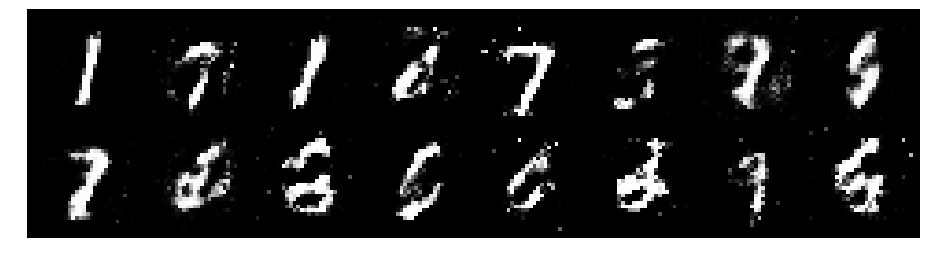

Epoch: [25/200], Batch Num: [400/600]
Discriminator Loss: 0.8843, Generator Loss: 1.4547
D(x): 0.7224, D(G(z)): 0.3344


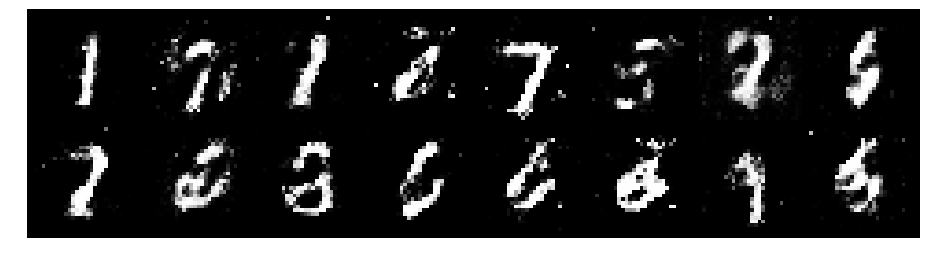

Epoch: [25/200], Batch Num: [500/600]
Discriminator Loss: 0.9529, Generator Loss: 1.6229
D(x): 0.5914, D(G(z)): 0.2135


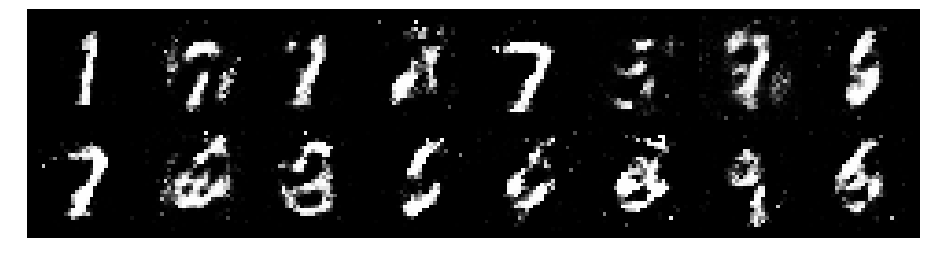

Epoch: [26/200], Batch Num: [0/600]
Discriminator Loss: 0.7580, Generator Loss: 1.5600
D(x): 0.7833, D(G(z)): 0.3174


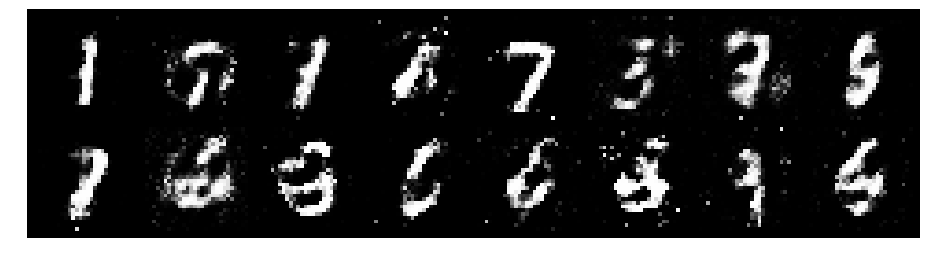

Epoch: [26/200], Batch Num: [100/600]
Discriminator Loss: 0.9438, Generator Loss: 1.4528
D(x): 0.6628, D(G(z)): 0.3158


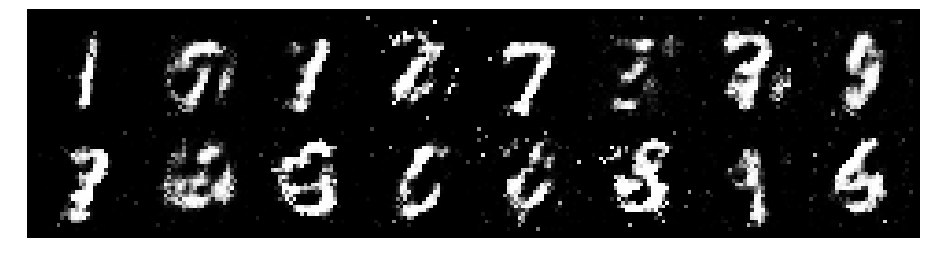

Epoch: [26/200], Batch Num: [200/600]
Discriminator Loss: 1.1218, Generator Loss: 1.3679
D(x): 0.5890, D(G(z)): 0.3250


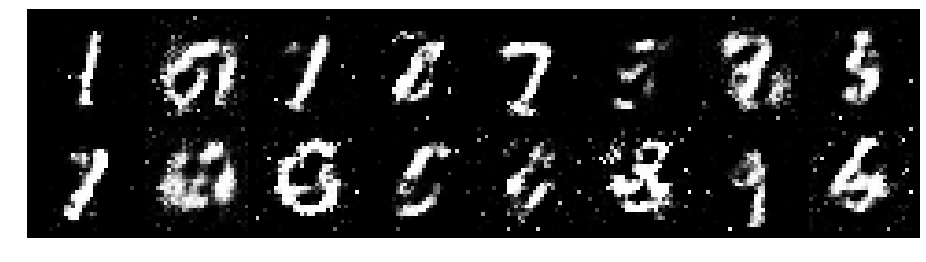

Epoch: [26/200], Batch Num: [300/600]
Discriminator Loss: 0.8628, Generator Loss: 1.0824
D(x): 0.7597, D(G(z)): 0.3581


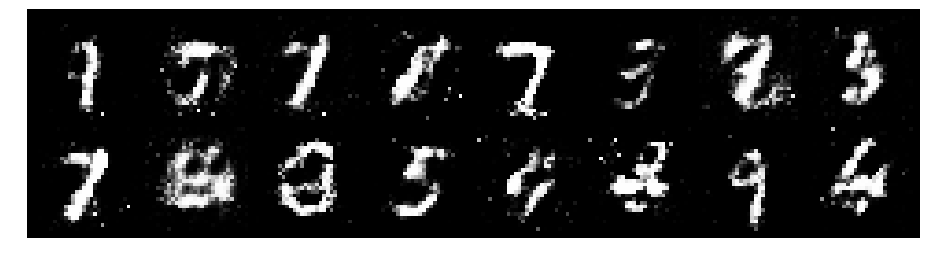

Epoch: [26/200], Batch Num: [400/600]
Discriminator Loss: 0.9077, Generator Loss: 1.5753
D(x): 0.6509, D(G(z)): 0.2305


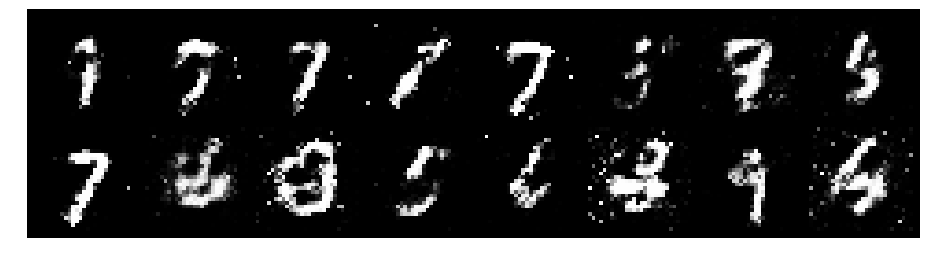

Epoch: [26/200], Batch Num: [500/600]
Discriminator Loss: 1.0118, Generator Loss: 1.4591
D(x): 0.7429, D(G(z)): 0.3779


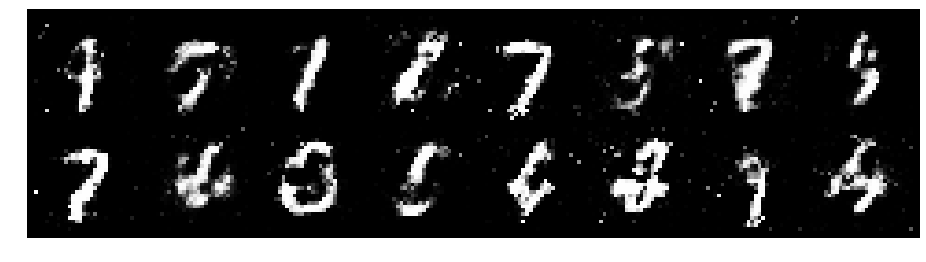

Epoch: [27/200], Batch Num: [0/600]
Discriminator Loss: 1.0382, Generator Loss: 1.5078
D(x): 0.7084, D(G(z)): 0.3810


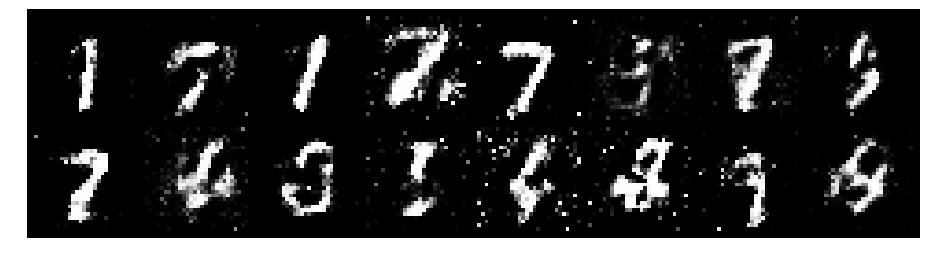

Epoch: [27/200], Batch Num: [100/600]
Discriminator Loss: 0.8929, Generator Loss: 1.6628
D(x): 0.7037, D(G(z)): 0.2821


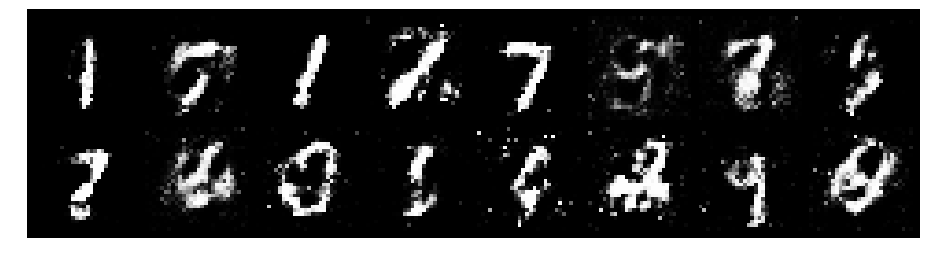

Epoch: [27/200], Batch Num: [200/600]
Discriminator Loss: 0.8861, Generator Loss: 1.1860
D(x): 0.7628, D(G(z)): 0.3373


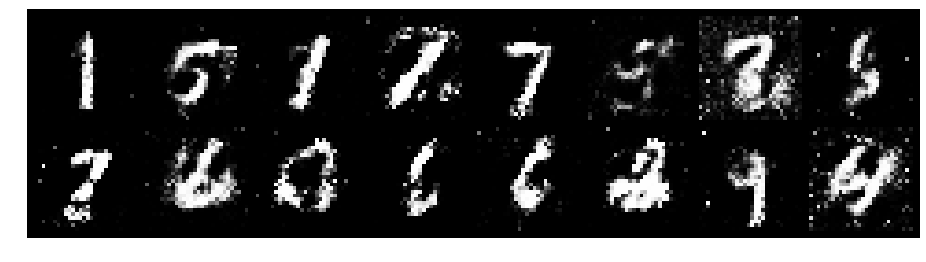

Epoch: [27/200], Batch Num: [300/600]
Discriminator Loss: 0.8717, Generator Loss: 1.5152
D(x): 0.6455, D(G(z)): 0.2528


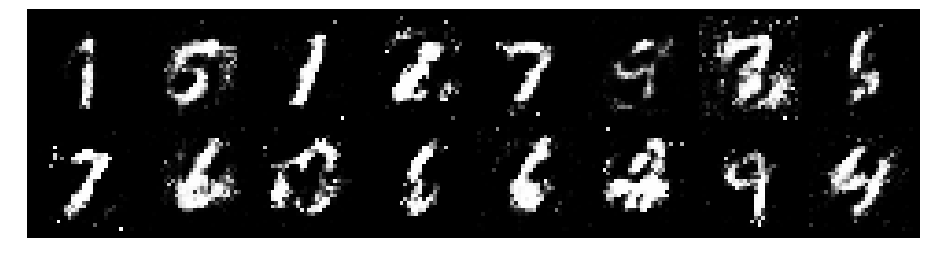

Epoch: [27/200], Batch Num: [400/600]
Discriminator Loss: 0.9998, Generator Loss: 1.4967
D(x): 0.6492, D(G(z)): 0.2932


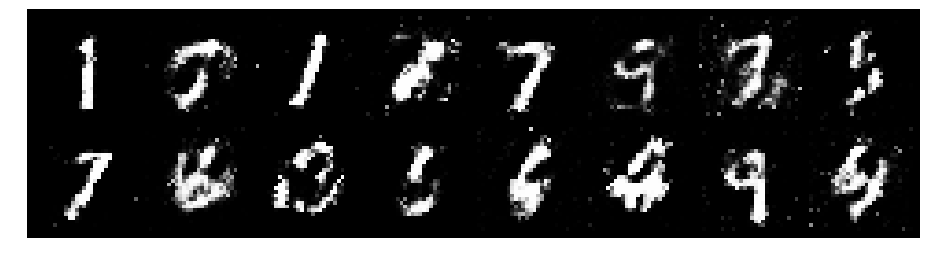

Epoch: [27/200], Batch Num: [500/600]
Discriminator Loss: 0.9925, Generator Loss: 1.2313
D(x): 0.7036, D(G(z)): 0.3826


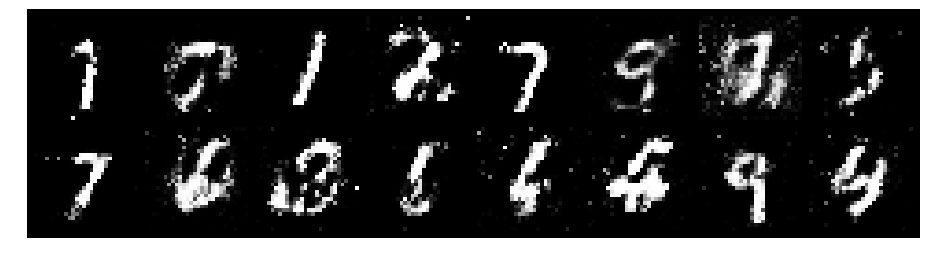

Epoch: [28/200], Batch Num: [0/600]
Discriminator Loss: 0.9289, Generator Loss: 1.4682
D(x): 0.6503, D(G(z)): 0.3094


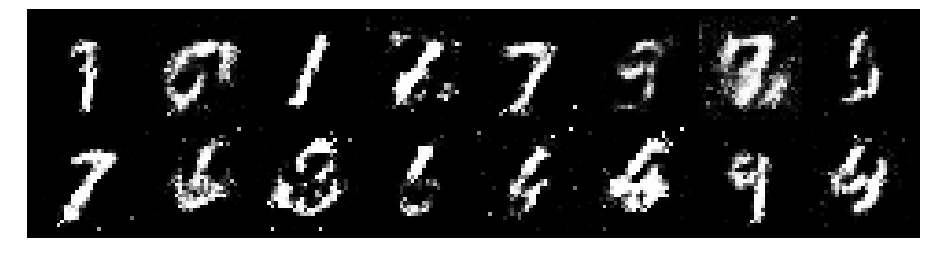

Epoch: [28/200], Batch Num: [100/600]
Discriminator Loss: 0.8862, Generator Loss: 1.2994
D(x): 0.7215, D(G(z)): 0.3430


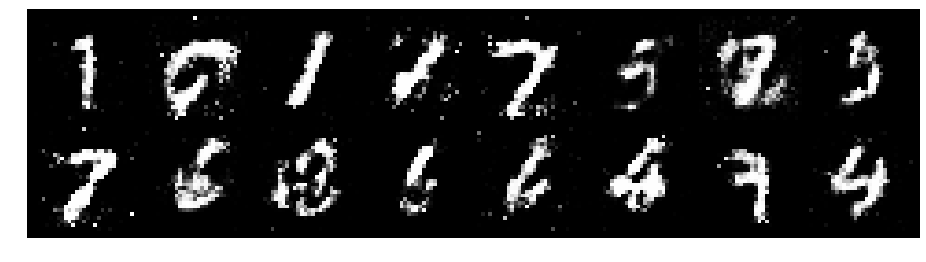

Epoch: [28/200], Batch Num: [200/600]
Discriminator Loss: 1.2482, Generator Loss: 1.2543
D(x): 0.5842, D(G(z)): 0.3771


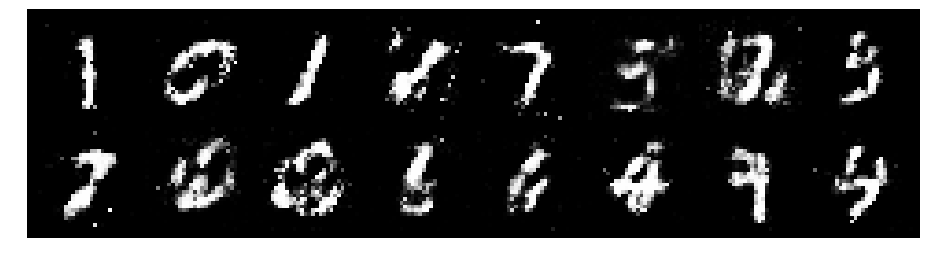

Epoch: [28/200], Batch Num: [300/600]
Discriminator Loss: 1.1183, Generator Loss: 1.1788
D(x): 0.6654, D(G(z)): 0.4105


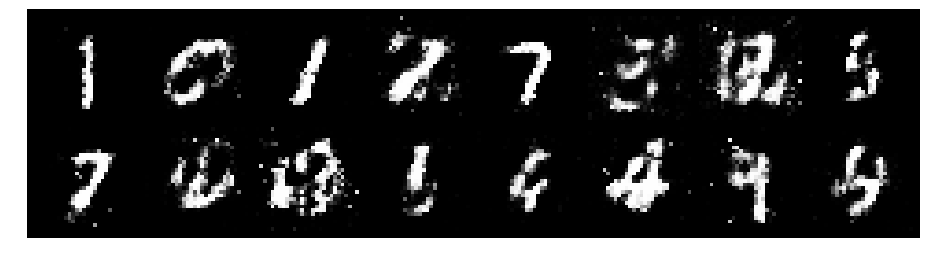

Epoch: [28/200], Batch Num: [400/600]
Discriminator Loss: 1.0142, Generator Loss: 1.2372
D(x): 0.7573, D(G(z)): 0.3944


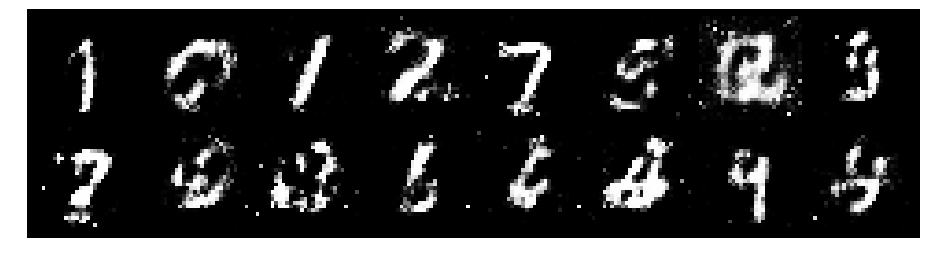

Epoch: [28/200], Batch Num: [500/600]
Discriminator Loss: 1.2405, Generator Loss: 1.2141
D(x): 0.5692, D(G(z)): 0.3870


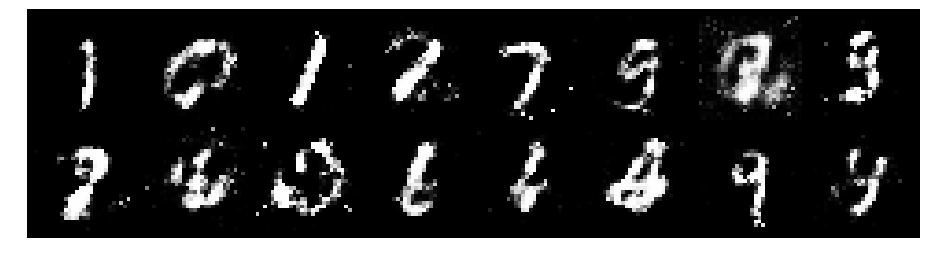

Epoch: [29/200], Batch Num: [0/600]
Discriminator Loss: 1.3618, Generator Loss: 0.9796
D(x): 0.5583, D(G(z)): 0.4409


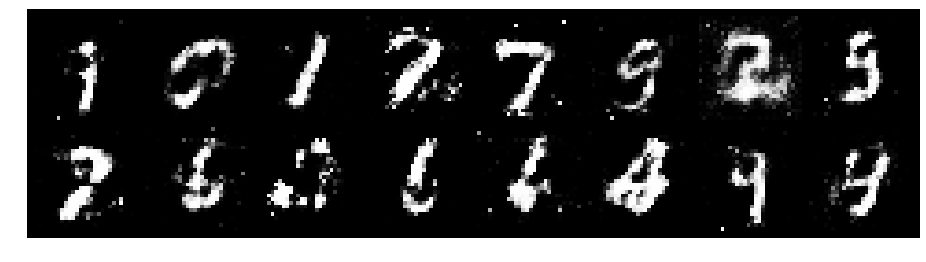

Epoch: [29/200], Batch Num: [100/600]
Discriminator Loss: 1.0943, Generator Loss: 1.2135
D(x): 0.6192, D(G(z)): 0.3548


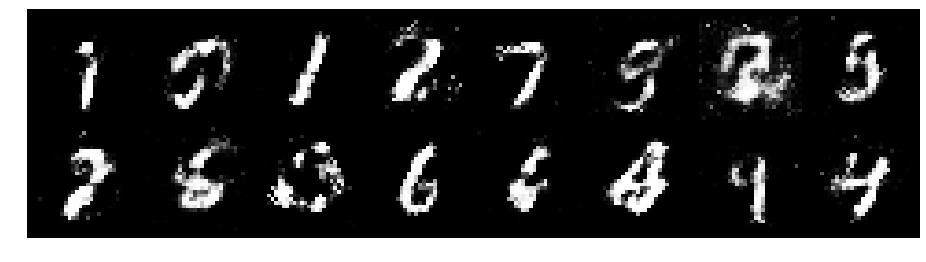

Epoch: [29/200], Batch Num: [200/600]
Discriminator Loss: 1.1990, Generator Loss: 1.1264
D(x): 0.5567, D(G(z)): 0.3159


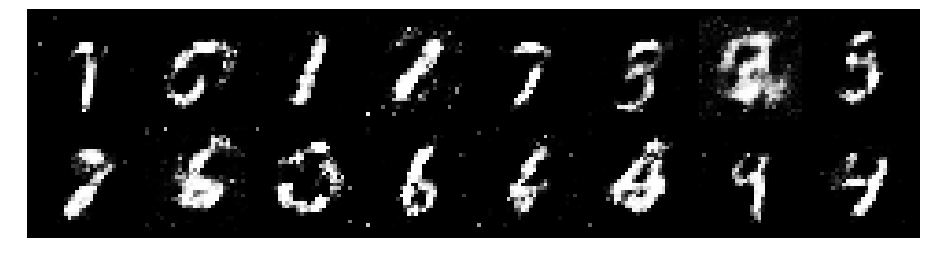

Epoch: [29/200], Batch Num: [300/600]
Discriminator Loss: 1.0896, Generator Loss: 1.1152
D(x): 0.6567, D(G(z)): 0.4030


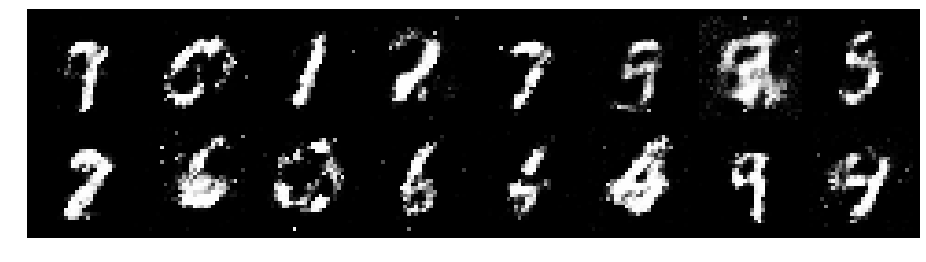

Epoch: [29/200], Batch Num: [400/600]
Discriminator Loss: 0.9721, Generator Loss: 1.5025
D(x): 0.6794, D(G(z)): 0.3389


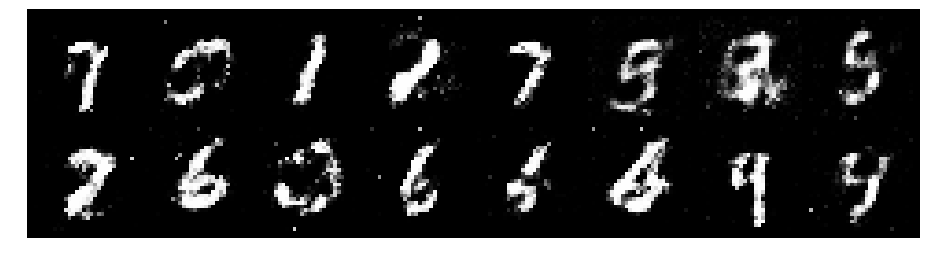

Epoch: [29/200], Batch Num: [500/600]
Discriminator Loss: 0.9351, Generator Loss: 1.5054
D(x): 0.7226, D(G(z)): 0.3441


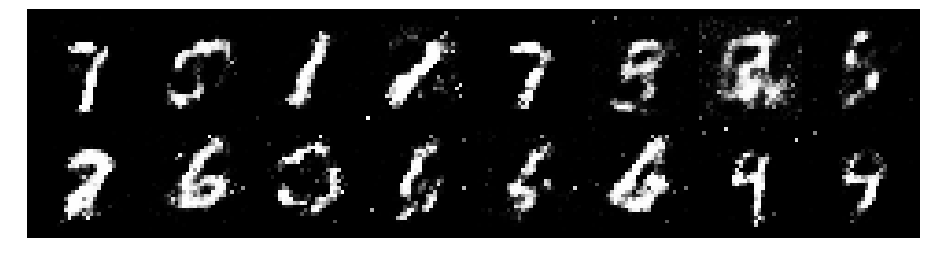

Epoch: [30/200], Batch Num: [0/600]
Discriminator Loss: 1.0868, Generator Loss: 1.1960
D(x): 0.6211, D(G(z)): 0.3913


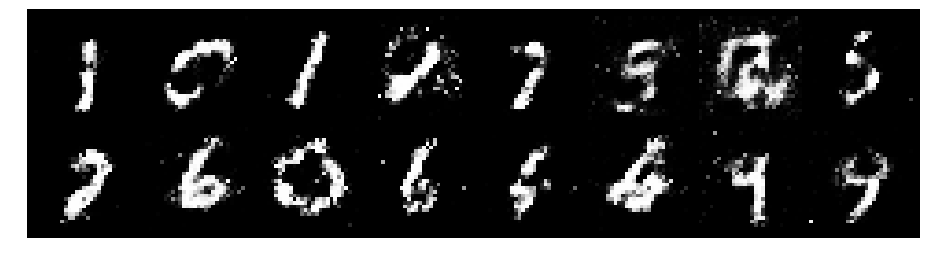

Epoch: [30/200], Batch Num: [100/600]
Discriminator Loss: 0.9389, Generator Loss: 1.3000
D(x): 0.6674, D(G(z)): 0.3362


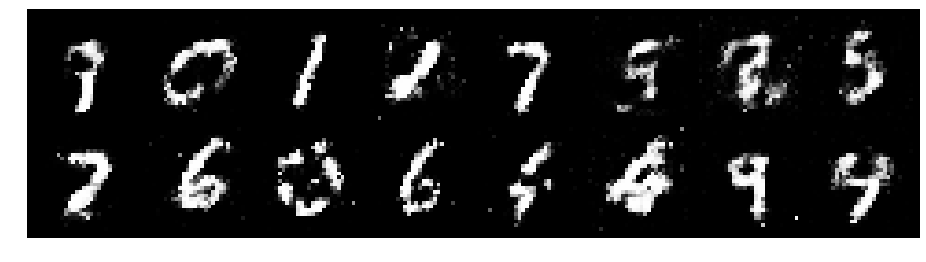

Epoch: [30/200], Batch Num: [200/600]
Discriminator Loss: 0.9123, Generator Loss: 1.5009
D(x): 0.7258, D(G(z)): 0.3191


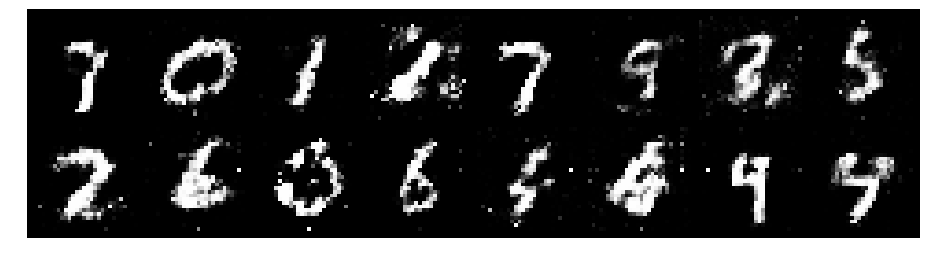

Epoch: [30/200], Batch Num: [300/600]
Discriminator Loss: 1.0603, Generator Loss: 1.6104
D(x): 0.6485, D(G(z)): 0.3357


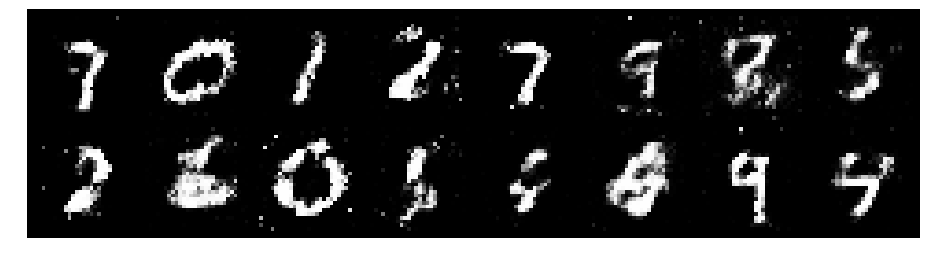

Epoch: [30/200], Batch Num: [400/600]
Discriminator Loss: 0.9883, Generator Loss: 1.2497
D(x): 0.6971, D(G(z)): 0.4014


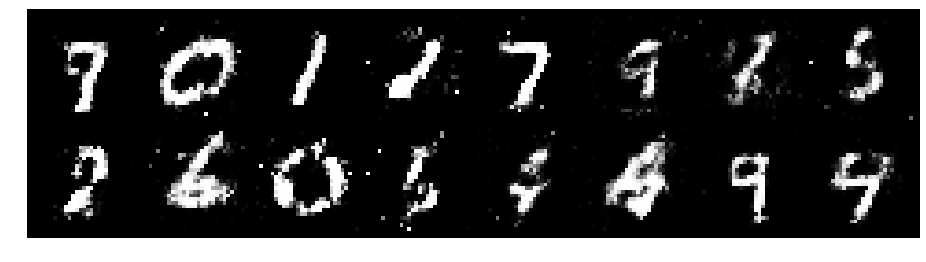

Epoch: [30/200], Batch Num: [500/600]
Discriminator Loss: 1.0615, Generator Loss: 1.2591
D(x): 0.6248, D(G(z)): 0.3526


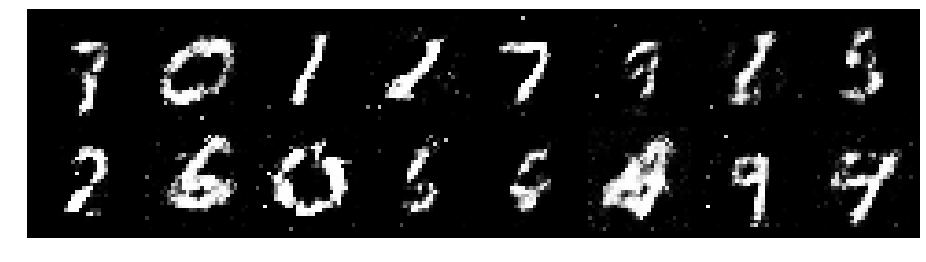

Epoch: [31/200], Batch Num: [0/600]
Discriminator Loss: 1.0771, Generator Loss: 1.1071
D(x): 0.6330, D(G(z)): 0.3699


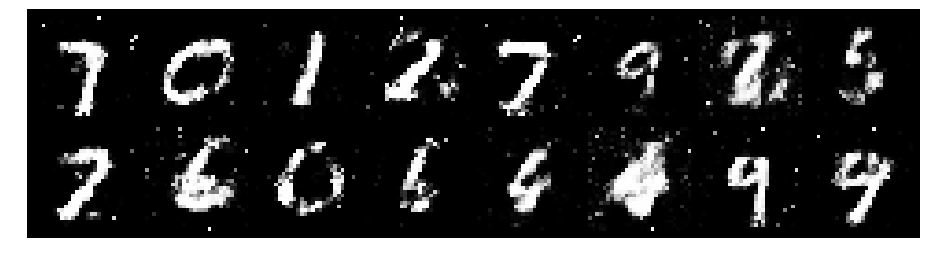

Epoch: [31/200], Batch Num: [100/600]
Discriminator Loss: 1.1183, Generator Loss: 1.0781
D(x): 0.7180, D(G(z)): 0.4538


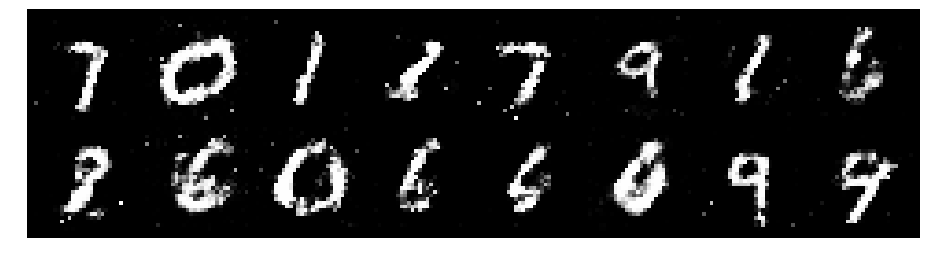

Epoch: [31/200], Batch Num: [200/600]
Discriminator Loss: 0.9207, Generator Loss: 1.4321
D(x): 0.6719, D(G(z)): 0.3242


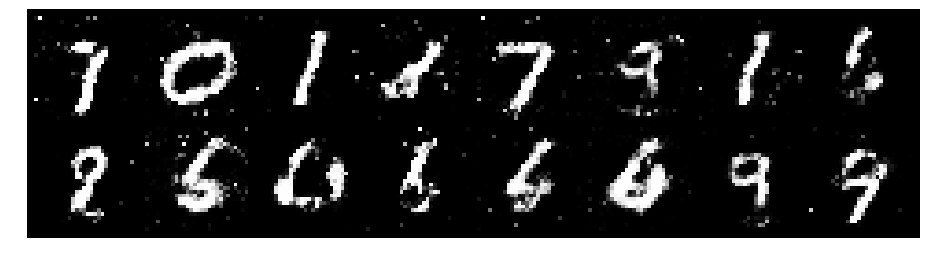

Epoch: [31/200], Batch Num: [300/600]
Discriminator Loss: 1.0589, Generator Loss: 1.2745
D(x): 0.6464, D(G(z)): 0.3485


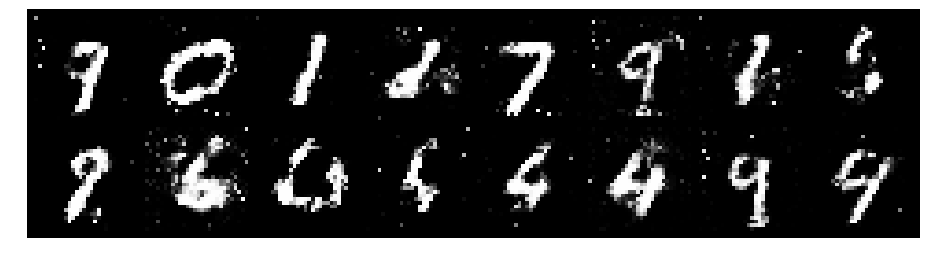

Epoch: [31/200], Batch Num: [400/600]
Discriminator Loss: 0.9796, Generator Loss: 1.3702
D(x): 0.6388, D(G(z)): 0.3319


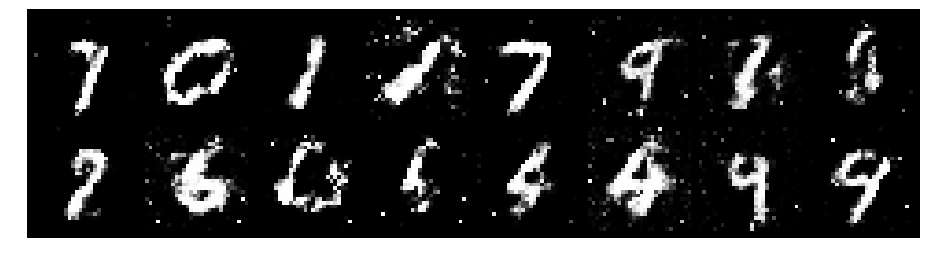

Epoch: [31/200], Batch Num: [500/600]
Discriminator Loss: 0.9146, Generator Loss: 1.4807
D(x): 0.6770, D(G(z)): 0.3016


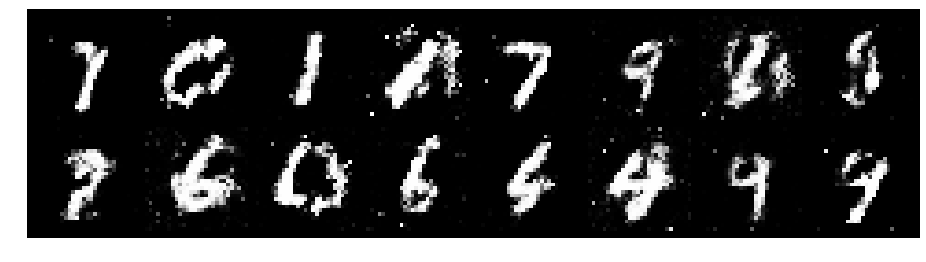

Epoch: [32/200], Batch Num: [0/600]
Discriminator Loss: 1.1135, Generator Loss: 1.7729
D(x): 0.7109, D(G(z)): 0.3455


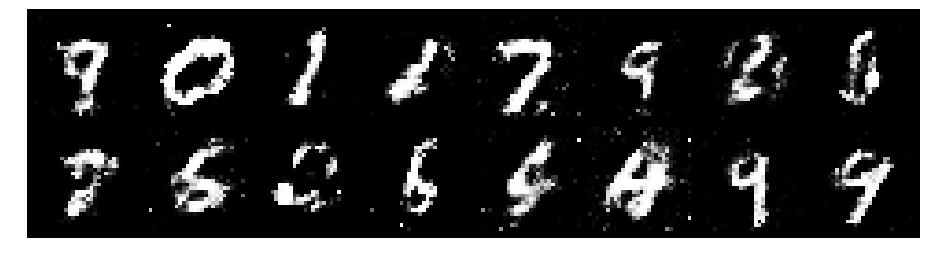

Epoch: [32/200], Batch Num: [100/600]
Discriminator Loss: 0.9121, Generator Loss: 1.5257
D(x): 0.6629, D(G(z)): 0.2987


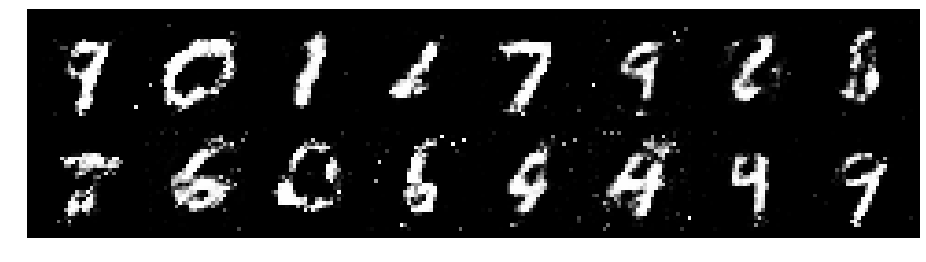

Epoch: [32/200], Batch Num: [200/600]
Discriminator Loss: 0.9739, Generator Loss: 1.2727
D(x): 0.6722, D(G(z)): 0.3492


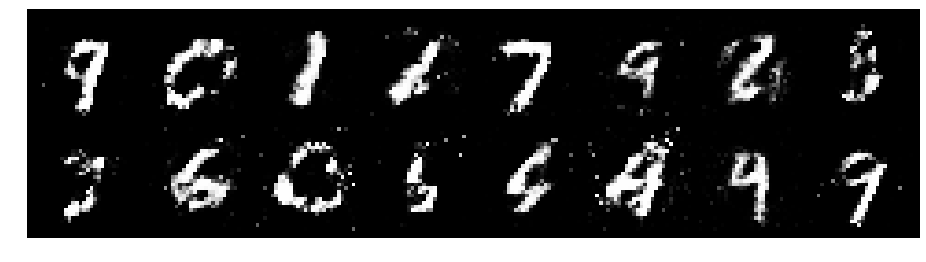

Epoch: [32/200], Batch Num: [300/600]
Discriminator Loss: 1.0174, Generator Loss: 1.2409
D(x): 0.6968, D(G(z)): 0.3645


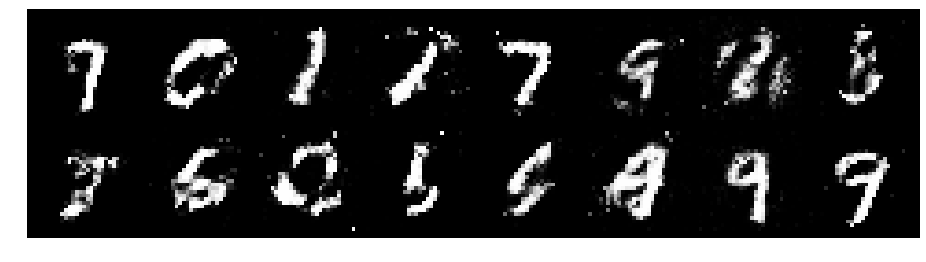

Epoch: [32/200], Batch Num: [400/600]
Discriminator Loss: 1.1537, Generator Loss: 1.2358
D(x): 0.5728, D(G(z)): 0.2992


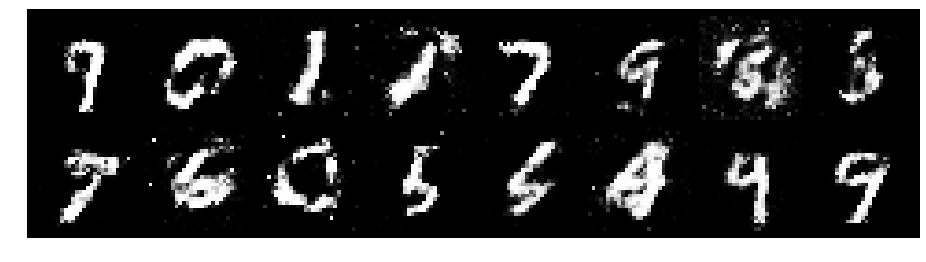

Epoch: [32/200], Batch Num: [500/600]
Discriminator Loss: 0.8775, Generator Loss: 1.5592
D(x): 0.7646, D(G(z)): 0.3490


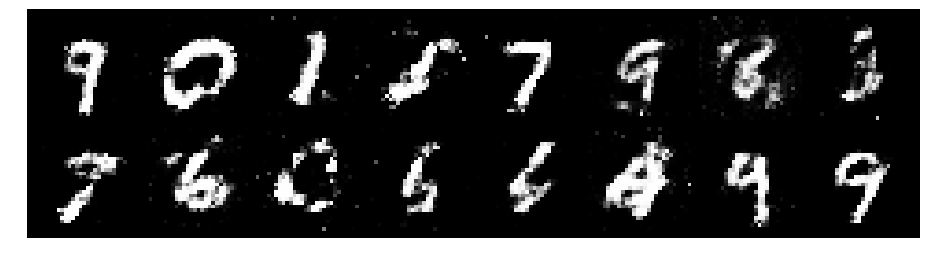

Epoch: [33/200], Batch Num: [0/600]
Discriminator Loss: 0.9968, Generator Loss: 1.3835
D(x): 0.7481, D(G(z)): 0.3846


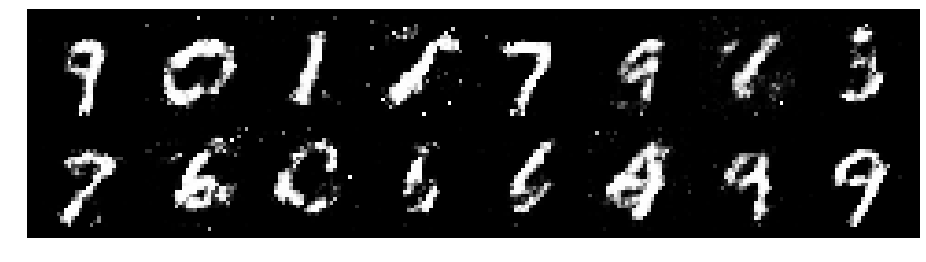

Epoch: [33/200], Batch Num: [100/600]
Discriminator Loss: 1.0361, Generator Loss: 1.0586
D(x): 0.6804, D(G(z)): 0.3394


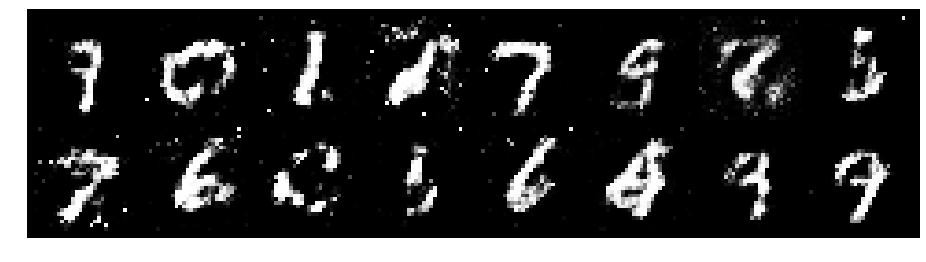

Epoch: [33/200], Batch Num: [200/600]
Discriminator Loss: 0.9864, Generator Loss: 1.3444
D(x): 0.6533, D(G(z)): 0.3065


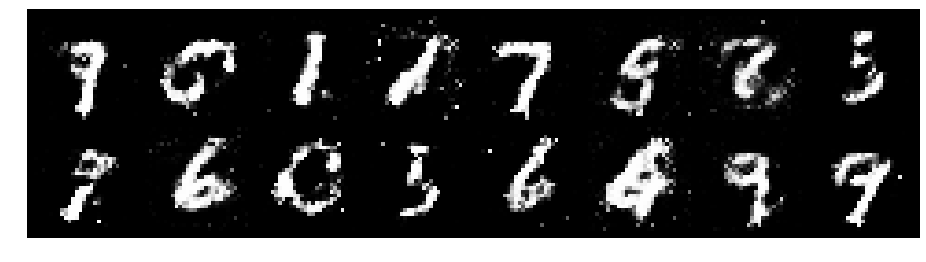

Epoch: [33/200], Batch Num: [300/600]
Discriminator Loss: 0.9366, Generator Loss: 1.3082
D(x): 0.6682, D(G(z)): 0.3104


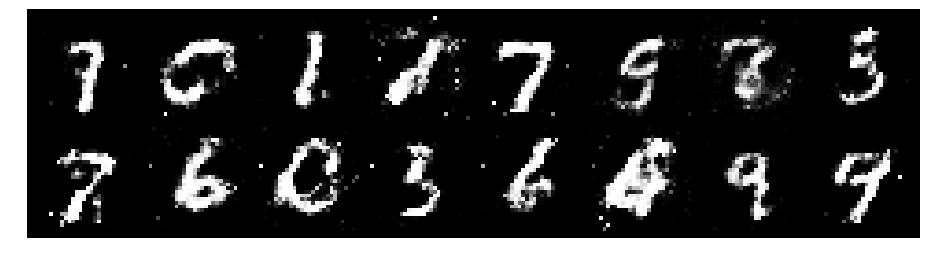

Epoch: [33/200], Batch Num: [400/600]
Discriminator Loss: 1.1517, Generator Loss: 1.4129
D(x): 0.6267, D(G(z)): 0.3570


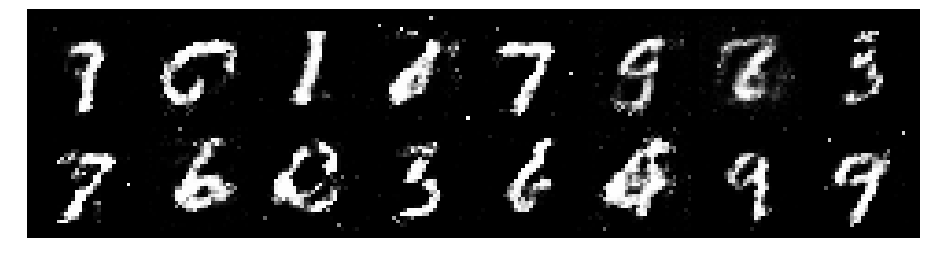

Epoch: [33/200], Batch Num: [500/600]
Discriminator Loss: 1.1777, Generator Loss: 1.0686
D(x): 0.6045, D(G(z)): 0.3889


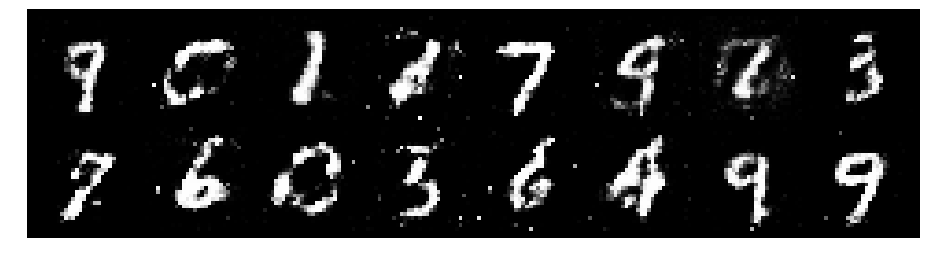

Epoch: [34/200], Batch Num: [0/600]
Discriminator Loss: 1.1799, Generator Loss: 1.4845
D(x): 0.6016, D(G(z)): 0.3731


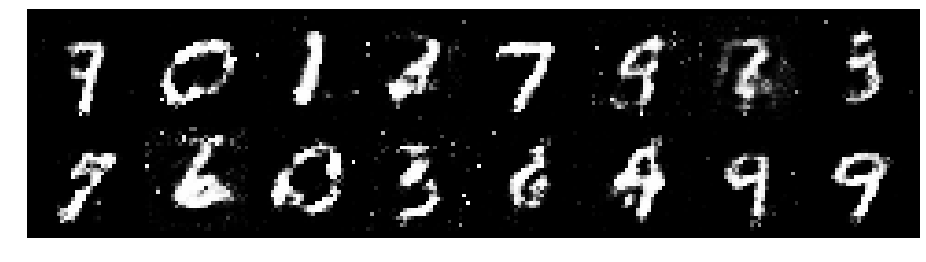

Epoch: [34/200], Batch Num: [100/600]
Discriminator Loss: 1.2572, Generator Loss: 1.3310
D(x): 0.5381, D(G(z)): 0.3502


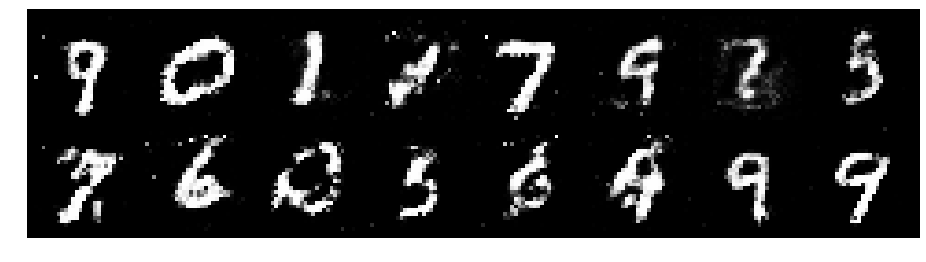

Epoch: [34/200], Batch Num: [200/600]
Discriminator Loss: 1.1274, Generator Loss: 1.0560
D(x): 0.6286, D(G(z)): 0.3697


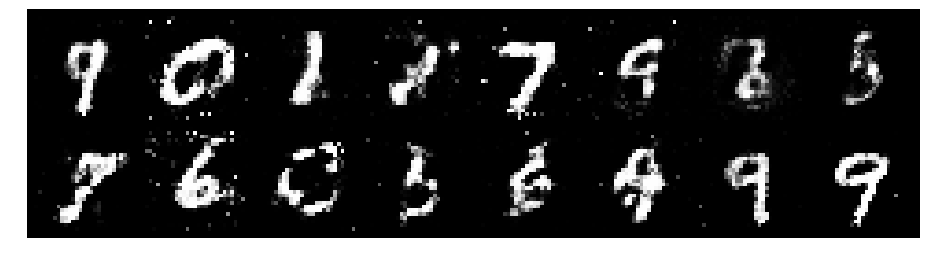

Epoch: [34/200], Batch Num: [300/600]
Discriminator Loss: 1.2103, Generator Loss: 1.3775
D(x): 0.5886, D(G(z)): 0.3568


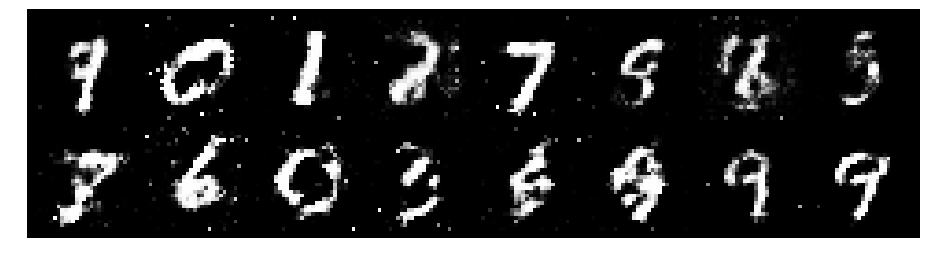

Epoch: [34/200], Batch Num: [400/600]
Discriminator Loss: 1.1164, Generator Loss: 1.0471
D(x): 0.6655, D(G(z)): 0.3491


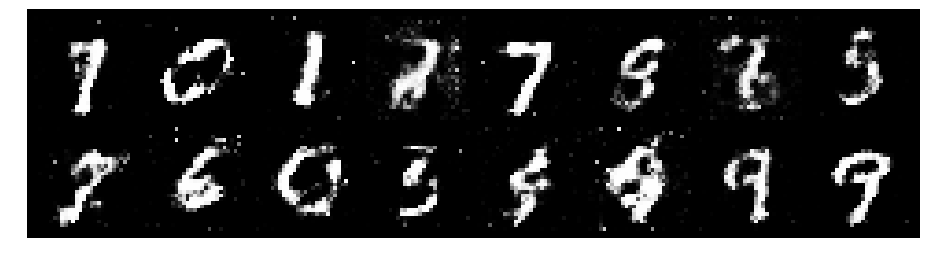

Epoch: [34/200], Batch Num: [500/600]
Discriminator Loss: 1.0015, Generator Loss: 1.2158
D(x): 0.6627, D(G(z)): 0.3540


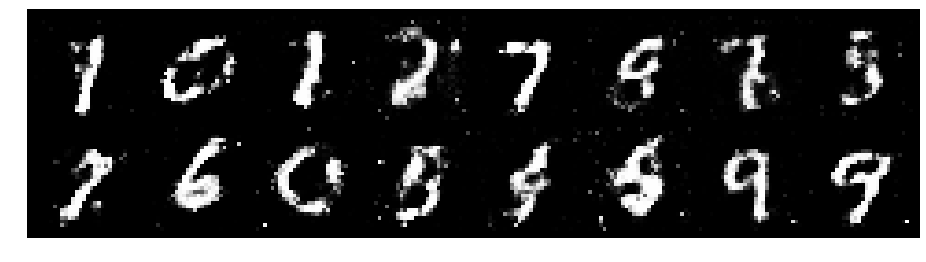

Epoch: [35/200], Batch Num: [0/600]
Discriminator Loss: 1.1688, Generator Loss: 1.1948
D(x): 0.5657, D(G(z)): 0.3379


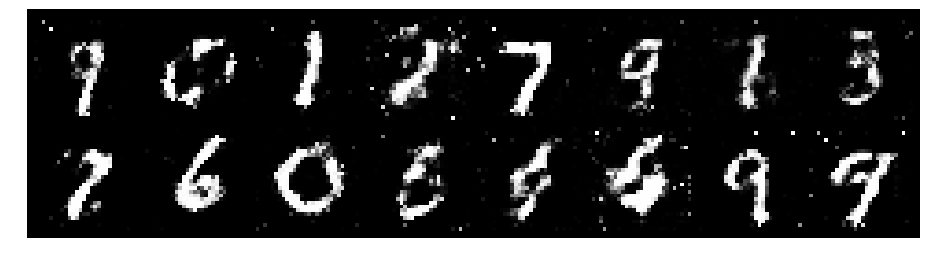

Epoch: [35/200], Batch Num: [100/600]
Discriminator Loss: 1.0522, Generator Loss: 1.1795
D(x): 0.5766, D(G(z)): 0.3285


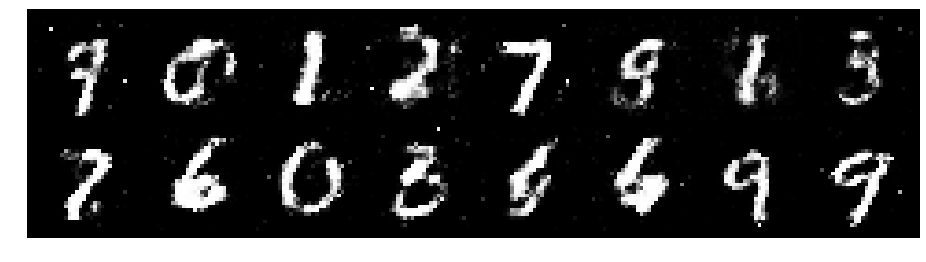

Epoch: [35/200], Batch Num: [200/600]
Discriminator Loss: 1.1561, Generator Loss: 1.2289
D(x): 0.5483, D(G(z)): 0.3334


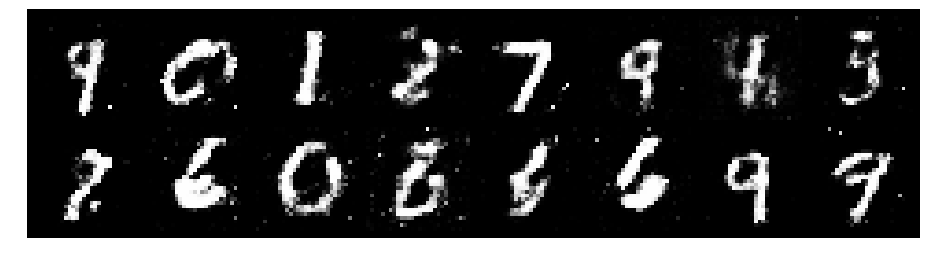

Epoch: [35/200], Batch Num: [300/600]
Discriminator Loss: 1.1471, Generator Loss: 1.1831
D(x): 0.6080, D(G(z)): 0.3824


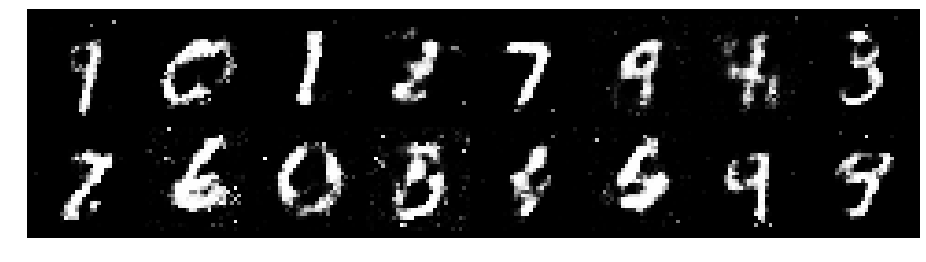

Epoch: [35/200], Batch Num: [400/600]
Discriminator Loss: 0.9669, Generator Loss: 1.2877
D(x): 0.7020, D(G(z)): 0.3535


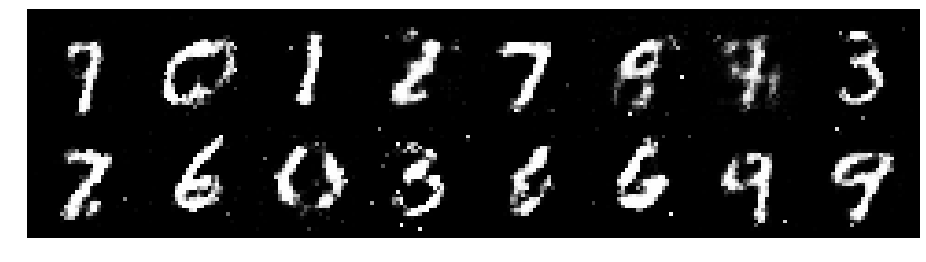

Epoch: [35/200], Batch Num: [500/600]
Discriminator Loss: 1.2087, Generator Loss: 1.3048
D(x): 0.6699, D(G(z)): 0.3994


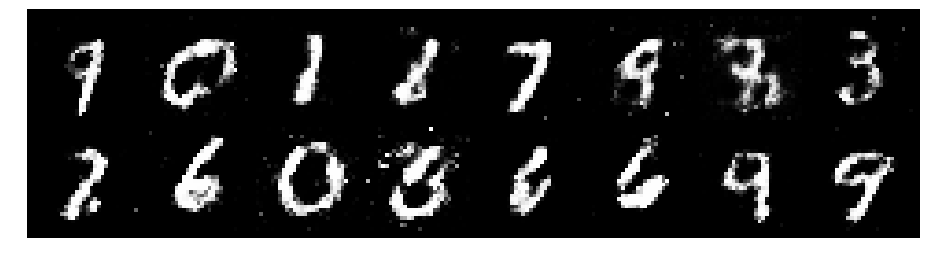

Epoch: [36/200], Batch Num: [0/600]
Discriminator Loss: 1.1086, Generator Loss: 1.1565
D(x): 0.5880, D(G(z)): 0.3631


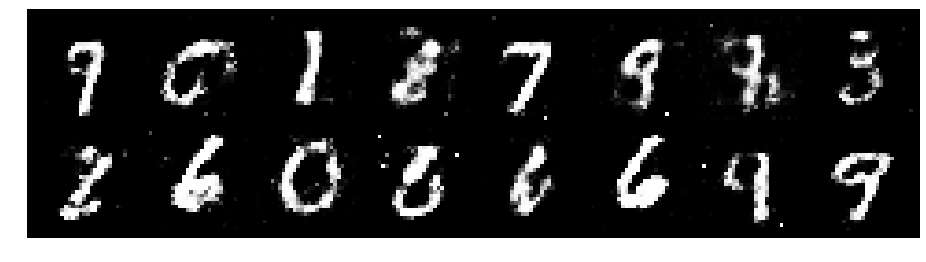

Epoch: [36/200], Batch Num: [100/600]
Discriminator Loss: 1.2411, Generator Loss: 1.3533
D(x): 0.5646, D(G(z)): 0.3806


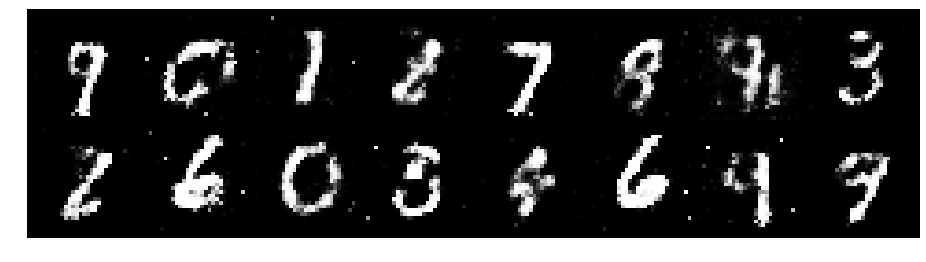

Epoch: [36/200], Batch Num: [200/600]
Discriminator Loss: 0.9674, Generator Loss: 1.3444
D(x): 0.6747, D(G(z)): 0.3076


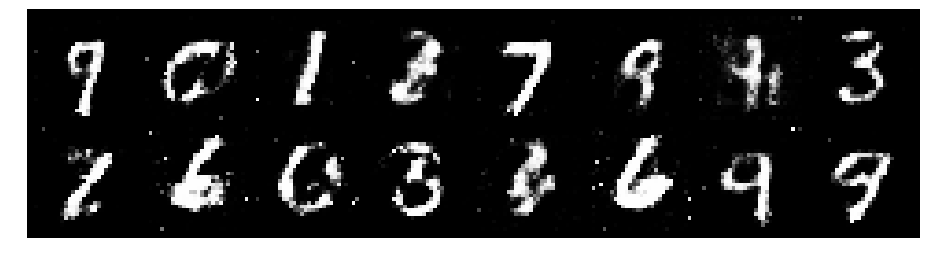

Epoch: [36/200], Batch Num: [300/600]
Discriminator Loss: 1.1219, Generator Loss: 1.1431
D(x): 0.6752, D(G(z)): 0.4171


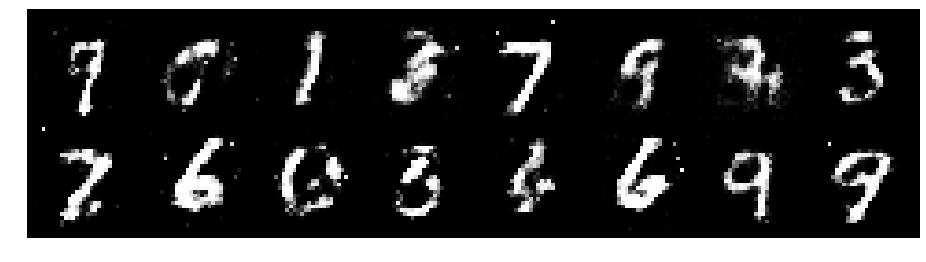

Epoch: [36/200], Batch Num: [400/600]
Discriminator Loss: 1.2631, Generator Loss: 1.0528
D(x): 0.5947, D(G(z)): 0.4267


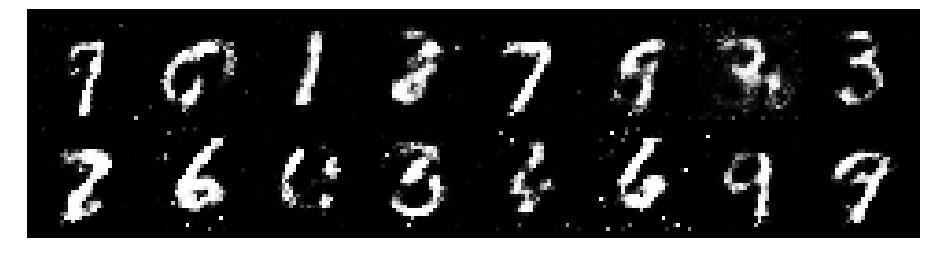

Epoch: [36/200], Batch Num: [500/600]
Discriminator Loss: 1.1824, Generator Loss: 1.1273
D(x): 0.6268, D(G(z)): 0.4033


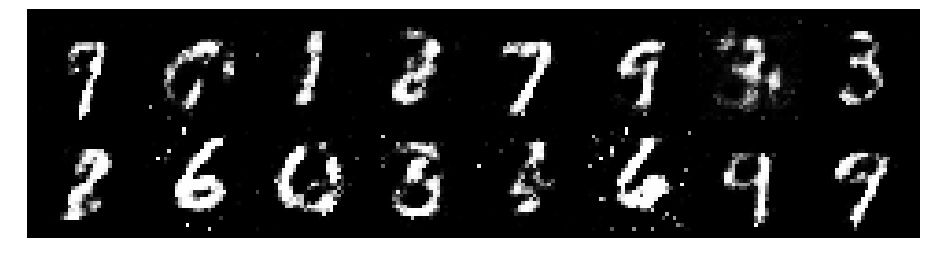

Epoch: [37/200], Batch Num: [0/600]
Discriminator Loss: 1.1338, Generator Loss: 1.0835
D(x): 0.6167, D(G(z)): 0.3578


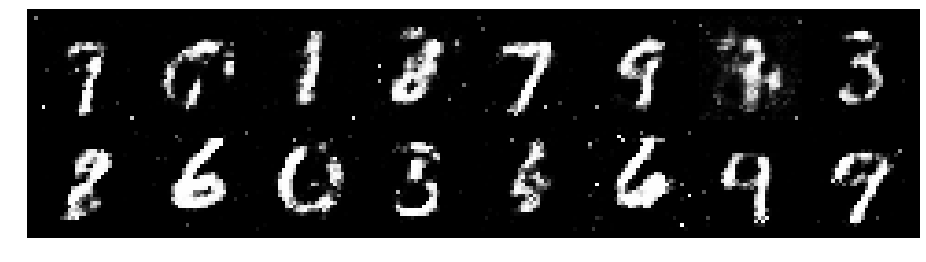

Epoch: [37/200], Batch Num: [100/600]
Discriminator Loss: 1.0823, Generator Loss: 1.3834
D(x): 0.5920, D(G(z)): 0.3165


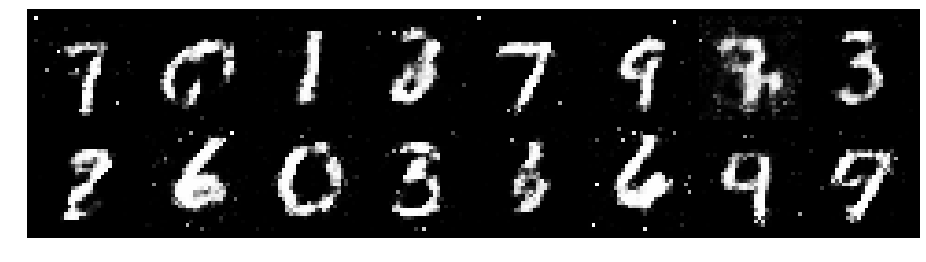

Epoch: [37/200], Batch Num: [200/600]
Discriminator Loss: 1.0973, Generator Loss: 1.2600
D(x): 0.6087, D(G(z)): 0.3538


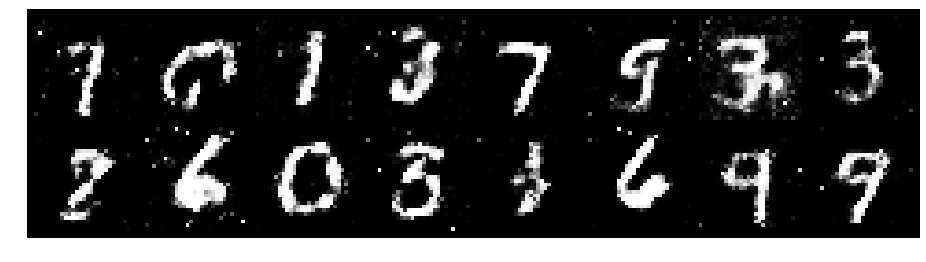

Epoch: [37/200], Batch Num: [300/600]
Discriminator Loss: 1.2006, Generator Loss: 1.1292
D(x): 0.5726, D(G(z)): 0.3556


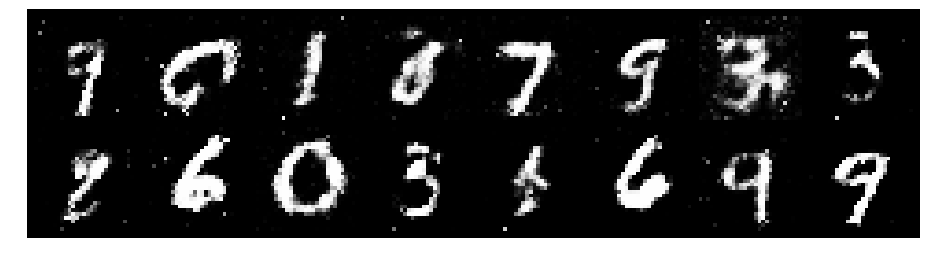

Epoch: [37/200], Batch Num: [400/600]
Discriminator Loss: 0.9369, Generator Loss: 1.3825
D(x): 0.6964, D(G(z)): 0.3301


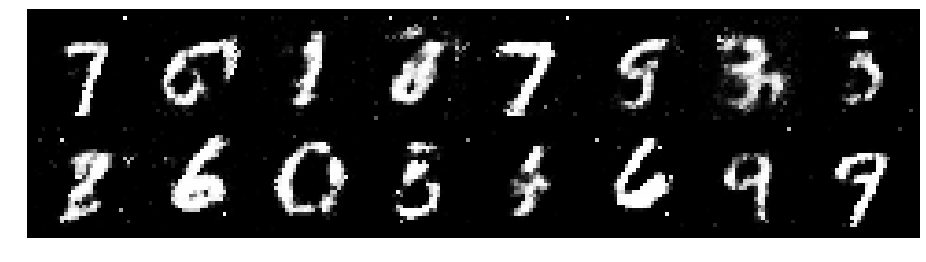

Epoch: [37/200], Batch Num: [500/600]
Discriminator Loss: 1.3293, Generator Loss: 1.1712
D(x): 0.5859, D(G(z)): 0.4200


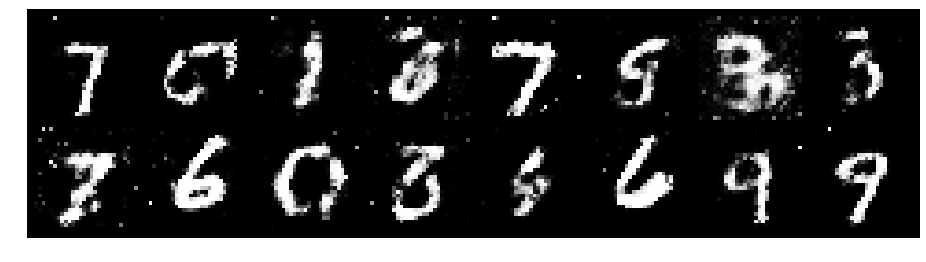

Epoch: [38/200], Batch Num: [0/600]
Discriminator Loss: 1.2484, Generator Loss: 1.4669
D(x): 0.5333, D(G(z)): 0.3183


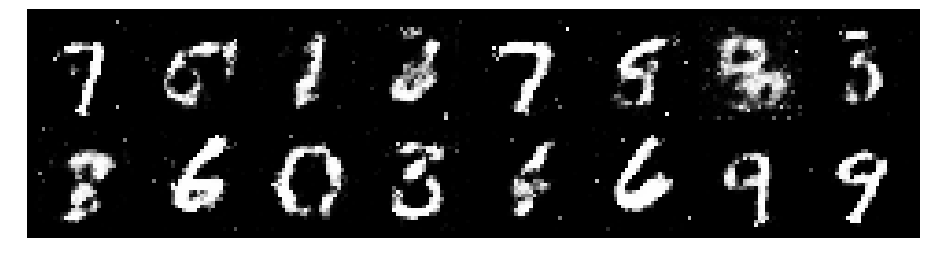

Epoch: [38/200], Batch Num: [100/600]
Discriminator Loss: 0.9885, Generator Loss: 1.5464
D(x): 0.6378, D(G(z)): 0.3052


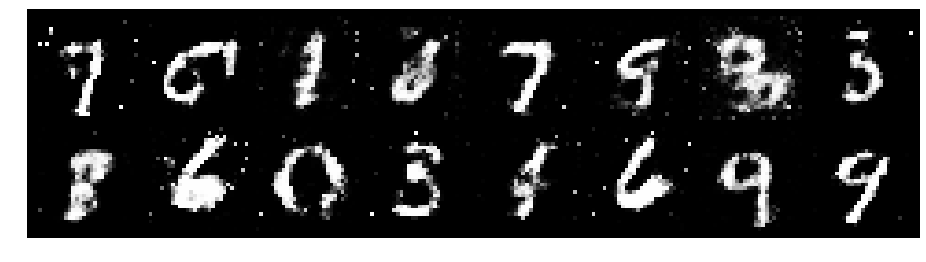

Epoch: [38/200], Batch Num: [200/600]
Discriminator Loss: 1.0825, Generator Loss: 1.1137
D(x): 0.6596, D(G(z)): 0.3815


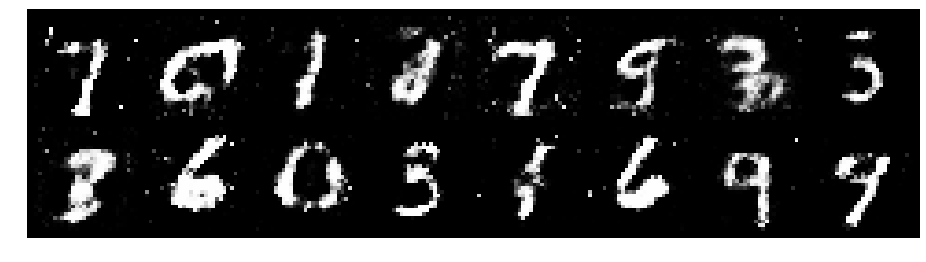

Epoch: [38/200], Batch Num: [300/600]
Discriminator Loss: 1.0602, Generator Loss: 1.3661
D(x): 0.6994, D(G(z)): 0.4051


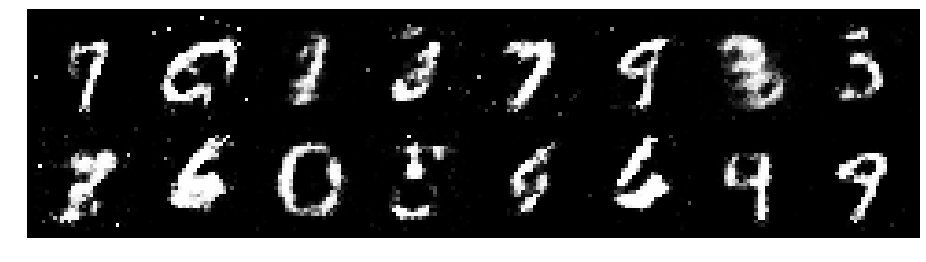

Epoch: [38/200], Batch Num: [400/600]
Discriminator Loss: 0.9865, Generator Loss: 1.6272
D(x): 0.6367, D(G(z)): 0.3343


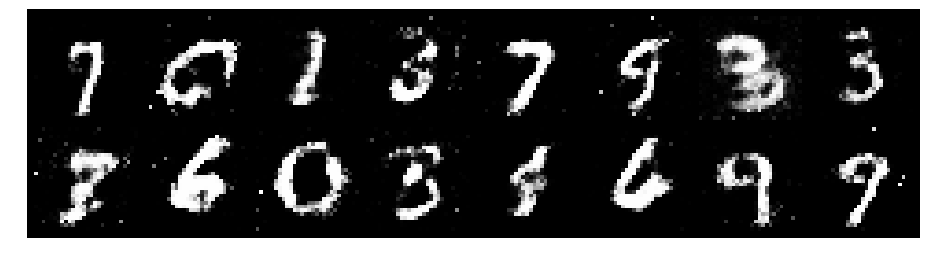

Epoch: [38/200], Batch Num: [500/600]
Discriminator Loss: 0.8825, Generator Loss: 1.3386
D(x): 0.7234, D(G(z)): 0.3257


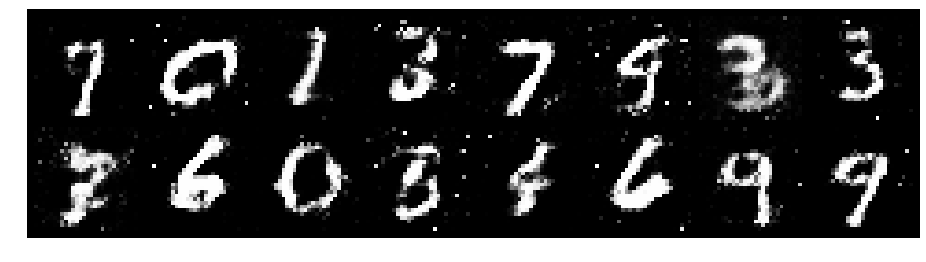

Epoch: [39/200], Batch Num: [0/600]
Discriminator Loss: 1.0250, Generator Loss: 1.4144
D(x): 0.5917, D(G(z)): 0.2884


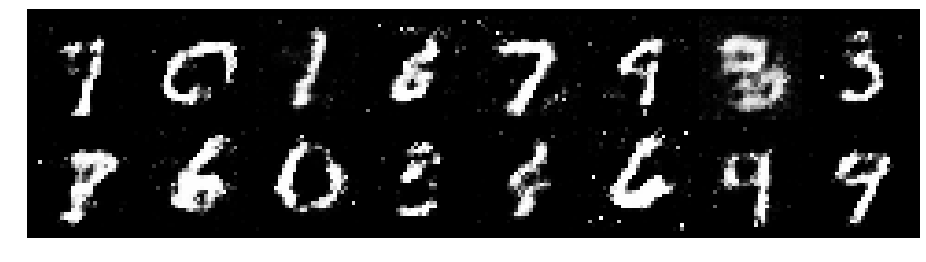

Epoch: [39/200], Batch Num: [100/600]
Discriminator Loss: 1.1418, Generator Loss: 1.0992
D(x): 0.6030, D(G(z)): 0.3350


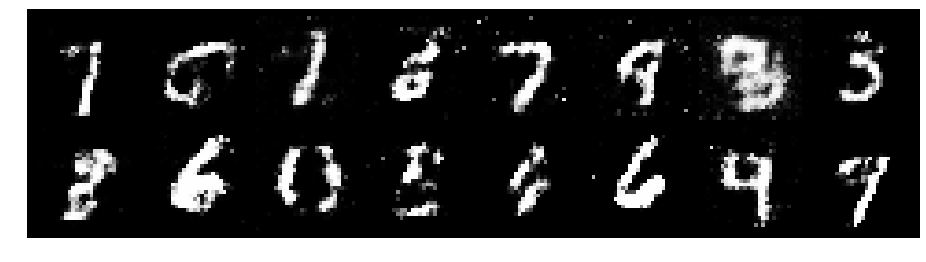

Epoch: [39/200], Batch Num: [200/600]
Discriminator Loss: 0.9352, Generator Loss: 1.1173
D(x): 0.6407, D(G(z)): 0.3281


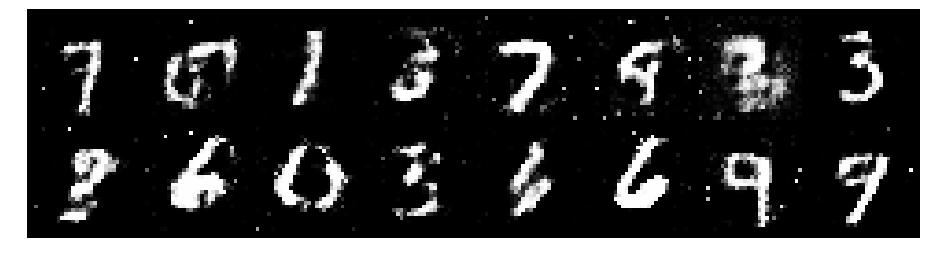

Epoch: [39/200], Batch Num: [300/600]
Discriminator Loss: 1.0366, Generator Loss: 1.1573
D(x): 0.6019, D(G(z)): 0.3217


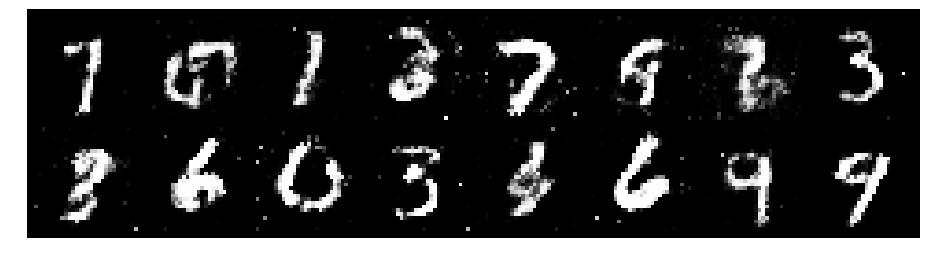

Epoch: [39/200], Batch Num: [400/600]
Discriminator Loss: 1.1539, Generator Loss: 1.1938
D(x): 0.5813, D(G(z)): 0.3440


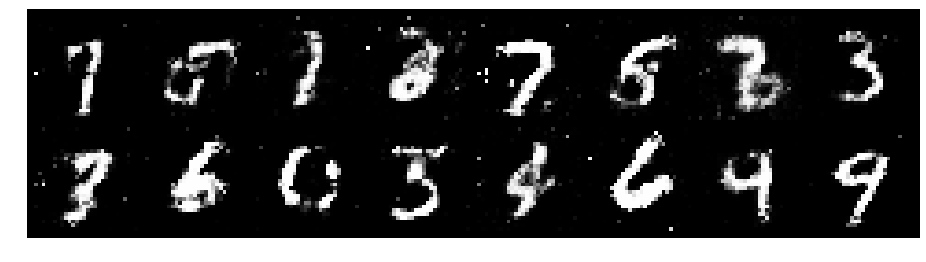

Epoch: [39/200], Batch Num: [500/600]
Discriminator Loss: 1.1244, Generator Loss: 1.2181
D(x): 0.6251, D(G(z)): 0.3793


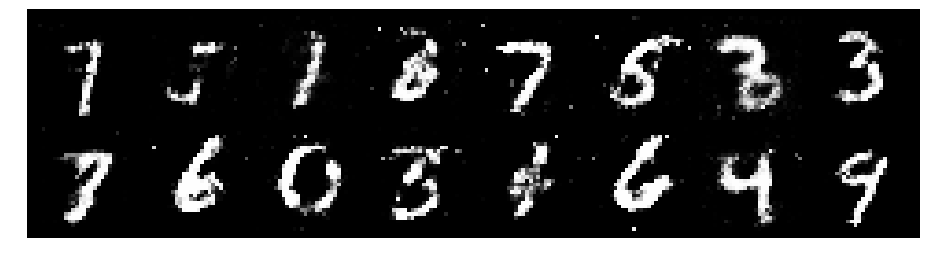

Epoch: [40/200], Batch Num: [0/600]
Discriminator Loss: 1.1177, Generator Loss: 0.8268
D(x): 0.6586, D(G(z)): 0.4455


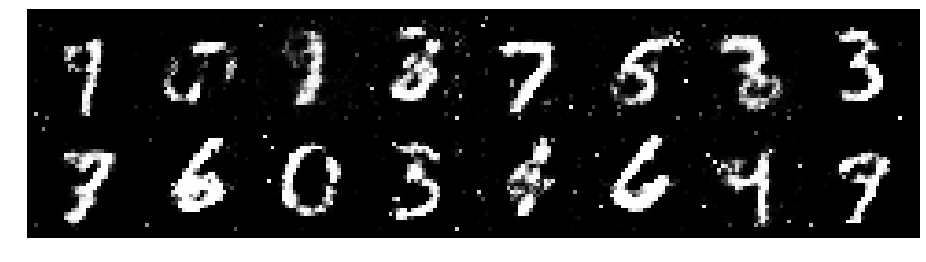

Epoch: [40/200], Batch Num: [100/600]
Discriminator Loss: 1.2208, Generator Loss: 1.1351
D(x): 0.5710, D(G(z)): 0.3851


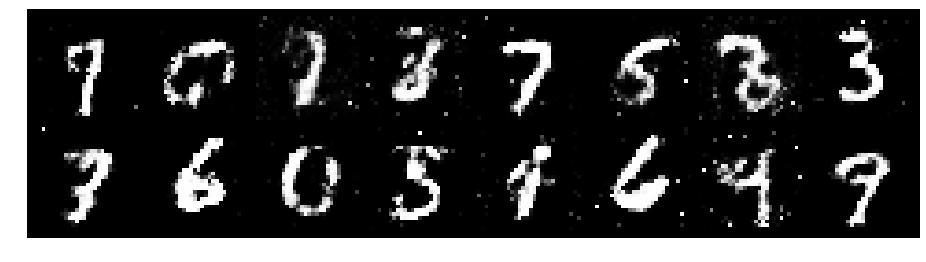

Epoch: [40/200], Batch Num: [200/600]
Discriminator Loss: 1.0130, Generator Loss: 1.2968
D(x): 0.6390, D(G(z)): 0.3383


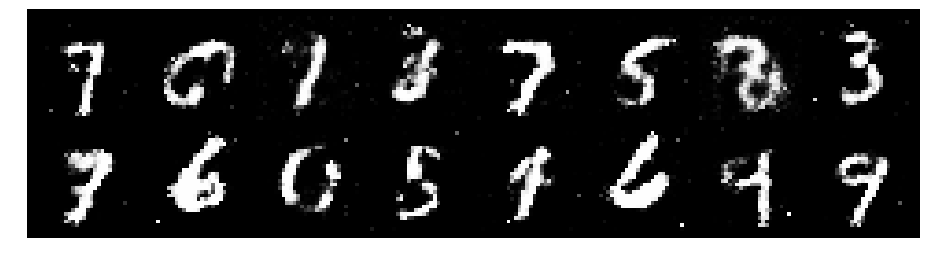

Epoch: [40/200], Batch Num: [300/600]
Discriminator Loss: 1.0200, Generator Loss: 1.5664
D(x): 0.5986, D(G(z)): 0.2916


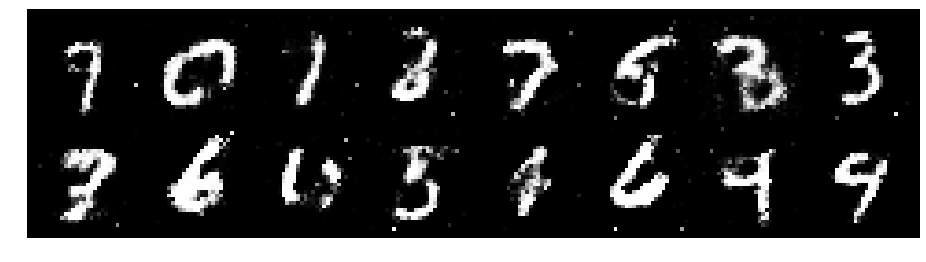

Epoch: [40/200], Batch Num: [400/600]
Discriminator Loss: 0.9255, Generator Loss: 1.3819
D(x): 0.7292, D(G(z)): 0.3685


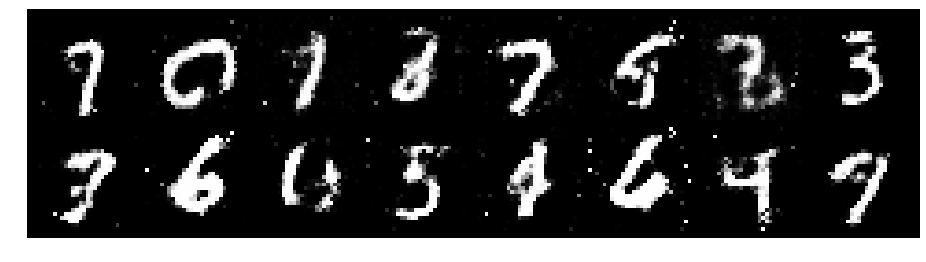

Epoch: [40/200], Batch Num: [500/600]
Discriminator Loss: 1.1797, Generator Loss: 1.0118
D(x): 0.5553, D(G(z)): 0.3555


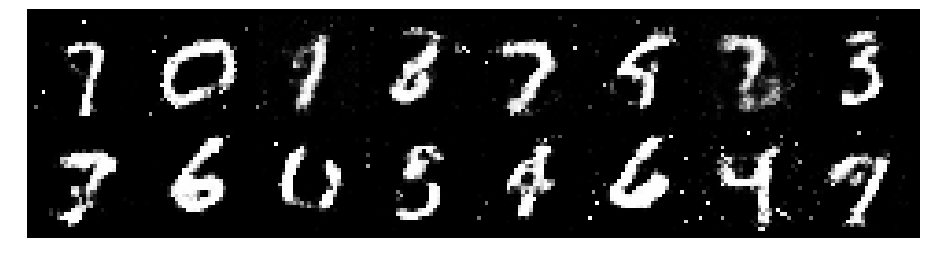

Epoch: [41/200], Batch Num: [0/600]
Discriminator Loss: 1.2217, Generator Loss: 1.3846
D(x): 0.5383, D(G(z)): 0.3246


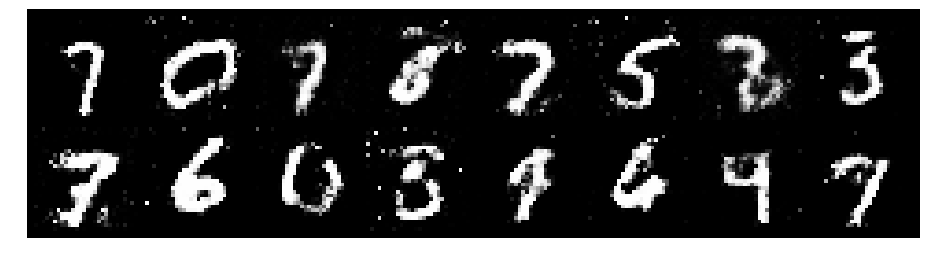

Epoch: [41/200], Batch Num: [100/600]
Discriminator Loss: 1.0956, Generator Loss: 1.3820
D(x): 0.6829, D(G(z)): 0.4079


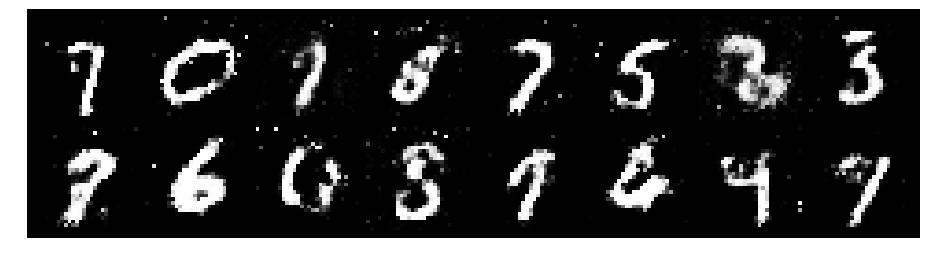

Epoch: [41/200], Batch Num: [200/600]
Discriminator Loss: 1.1633, Generator Loss: 1.1432
D(x): 0.5809, D(G(z)): 0.3683


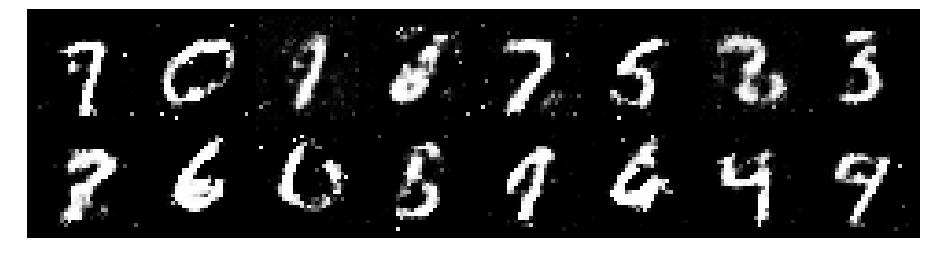

Epoch: [41/200], Batch Num: [300/600]
Discriminator Loss: 1.1134, Generator Loss: 1.2206
D(x): 0.6142, D(G(z)): 0.3591


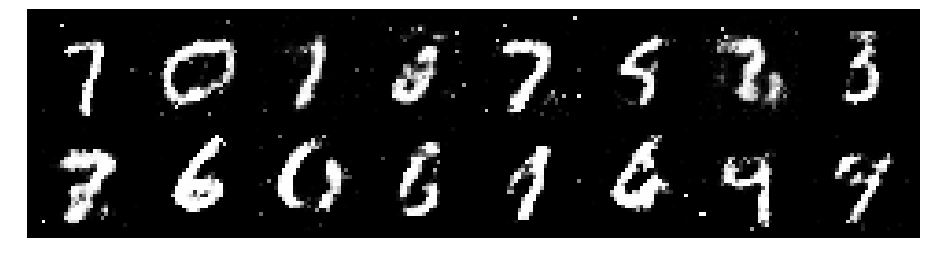

Epoch: [41/200], Batch Num: [400/600]
Discriminator Loss: 1.1547, Generator Loss: 1.3452
D(x): 0.6170, D(G(z)): 0.3539


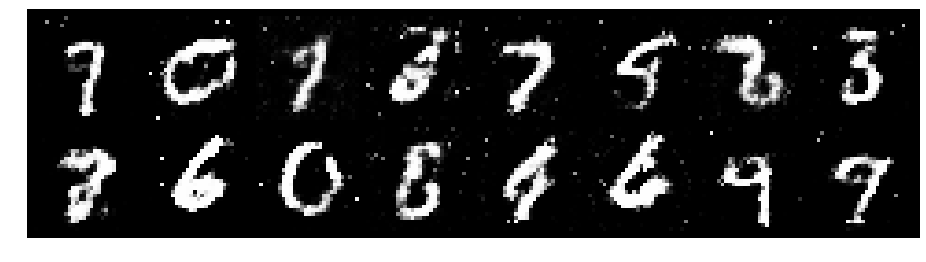

Epoch: [41/200], Batch Num: [500/600]
Discriminator Loss: 1.1450, Generator Loss: 1.2284
D(x): 0.6283, D(G(z)): 0.4033


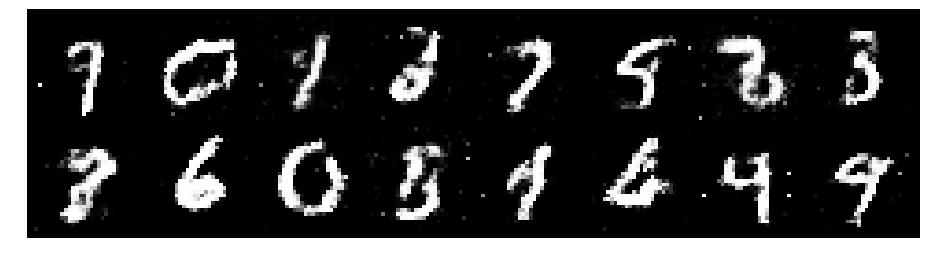

Epoch: [42/200], Batch Num: [0/600]
Discriminator Loss: 0.9336, Generator Loss: 1.3238
D(x): 0.7025, D(G(z)): 0.3401


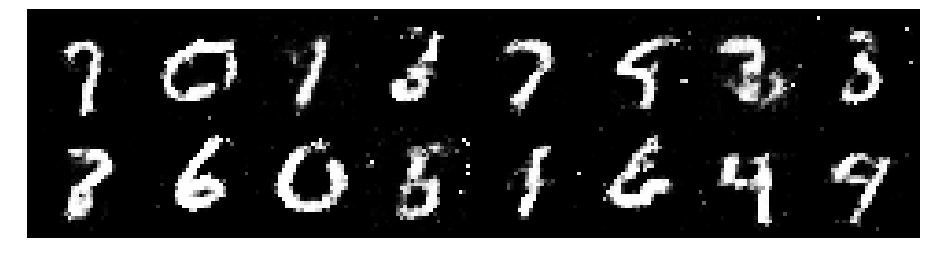

Epoch: [42/200], Batch Num: [100/600]
Discriminator Loss: 1.0689, Generator Loss: 1.2972
D(x): 0.6276, D(G(z)): 0.3733


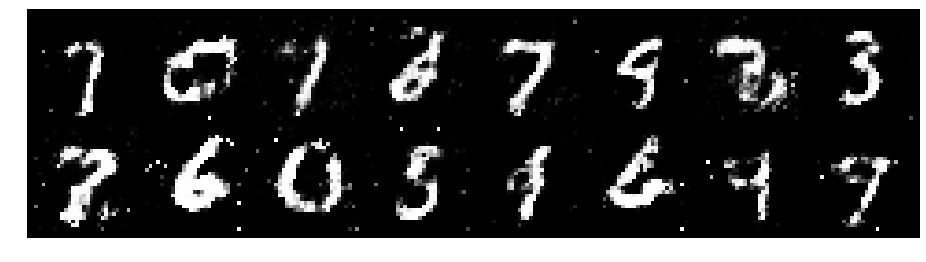

Epoch: [42/200], Batch Num: [200/600]
Discriminator Loss: 1.0143, Generator Loss: 1.3468
D(x): 0.6608, D(G(z)): 0.3548


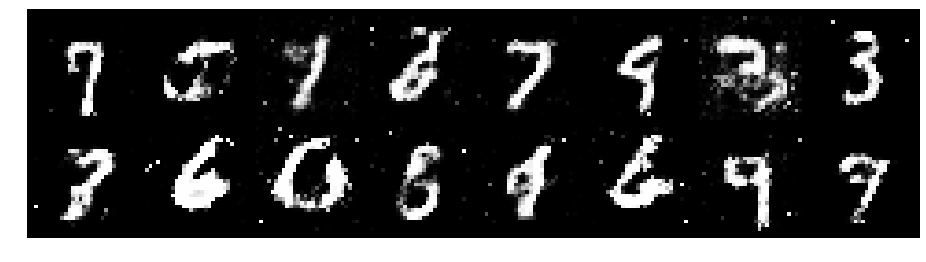

Epoch: [42/200], Batch Num: [300/600]
Discriminator Loss: 1.0464, Generator Loss: 1.0740
D(x): 0.6041, D(G(z)): 0.3507


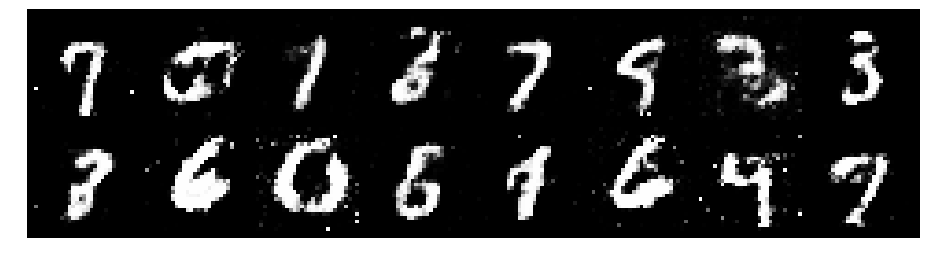

Epoch: [42/200], Batch Num: [400/600]
Discriminator Loss: 0.9240, Generator Loss: 1.4127
D(x): 0.6338, D(G(z)): 0.2824


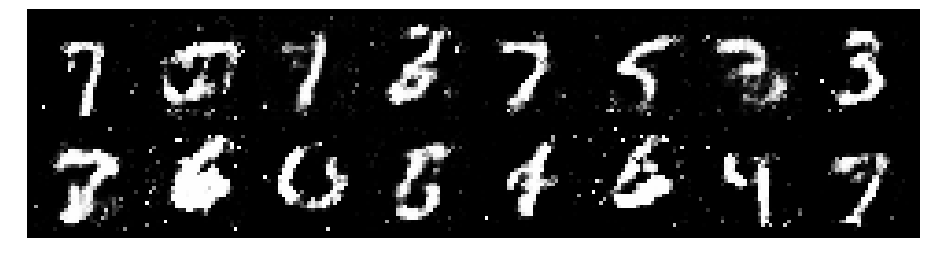

Epoch: [42/200], Batch Num: [500/600]
Discriminator Loss: 0.9246, Generator Loss: 1.2767
D(x): 0.7275, D(G(z)): 0.3644


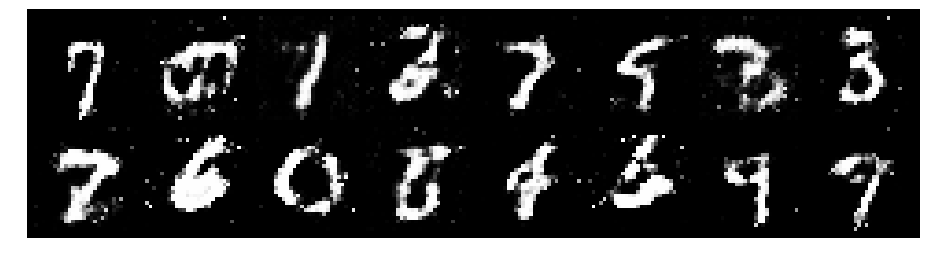

Epoch: [43/200], Batch Num: [0/600]
Discriminator Loss: 1.0123, Generator Loss: 1.1167
D(x): 0.6406, D(G(z)): 0.3310


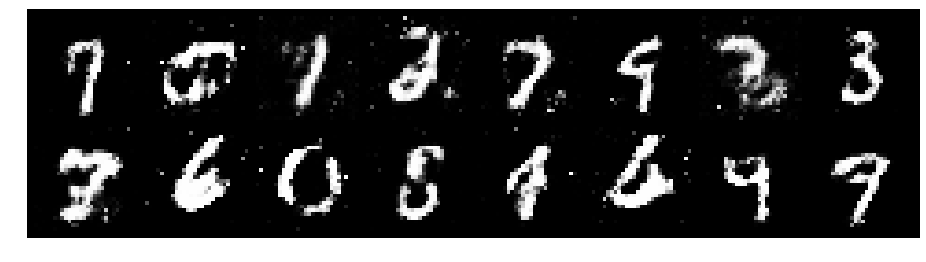

Epoch: [43/200], Batch Num: [100/600]
Discriminator Loss: 1.0172, Generator Loss: 1.2584
D(x): 0.6393, D(G(z)): 0.3288


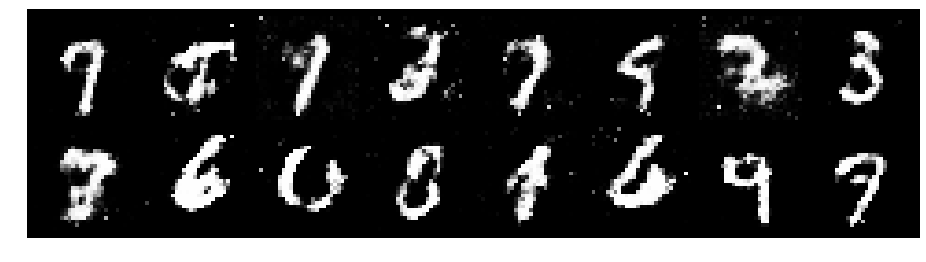

Epoch: [43/200], Batch Num: [200/600]
Discriminator Loss: 1.1060, Generator Loss: 1.2085
D(x): 0.6208, D(G(z)): 0.3762


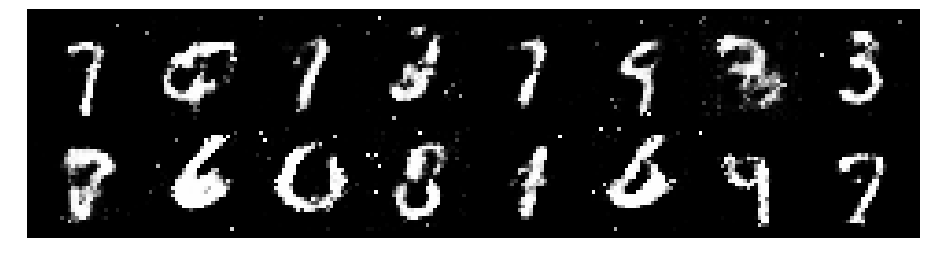

Epoch: [43/200], Batch Num: [300/600]
Discriminator Loss: 1.0033, Generator Loss: 1.2922
D(x): 0.6670, D(G(z)): 0.3726


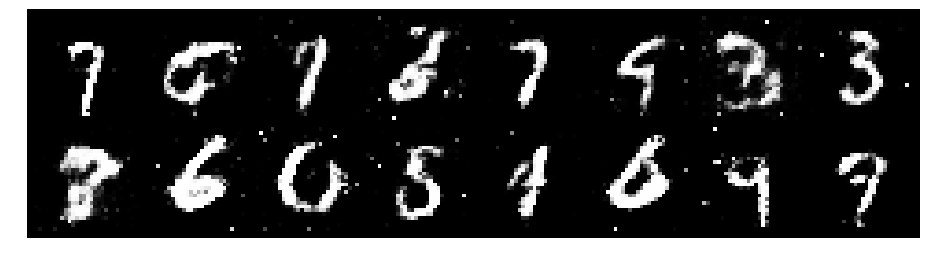

Epoch: [43/200], Batch Num: [400/600]
Discriminator Loss: 1.1923, Generator Loss: 1.0078
D(x): 0.6378, D(G(z)): 0.4207


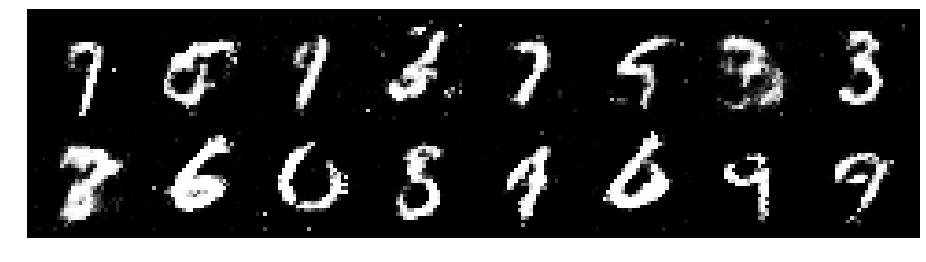

Epoch: [43/200], Batch Num: [500/600]
Discriminator Loss: 1.1977, Generator Loss: 1.0979
D(x): 0.5846, D(G(z)): 0.4048


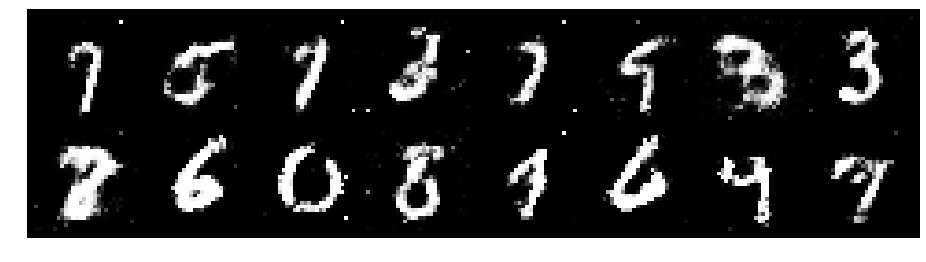

Epoch: [44/200], Batch Num: [0/600]
Discriminator Loss: 1.1127, Generator Loss: 0.8854
D(x): 0.5984, D(G(z)): 0.3960


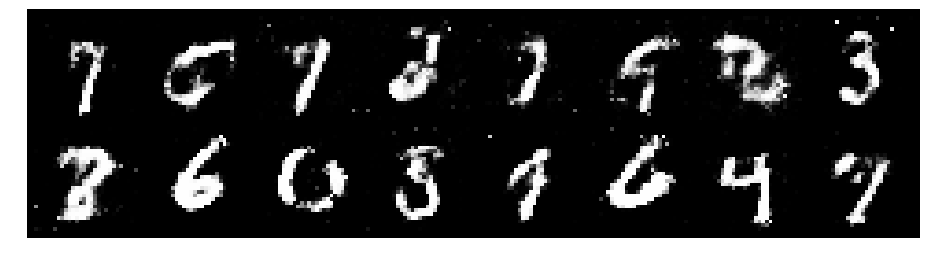

Epoch: [44/200], Batch Num: [100/600]
Discriminator Loss: 1.2013, Generator Loss: 0.9849
D(x): 0.5865, D(G(z)): 0.4117


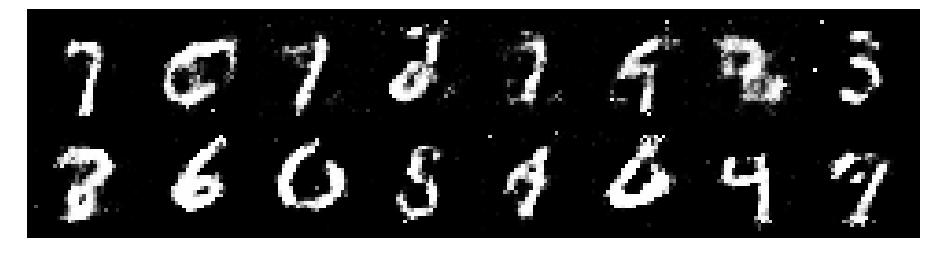

Epoch: [44/200], Batch Num: [200/600]
Discriminator Loss: 1.2309, Generator Loss: 1.0269
D(x): 0.6245, D(G(z)): 0.4617


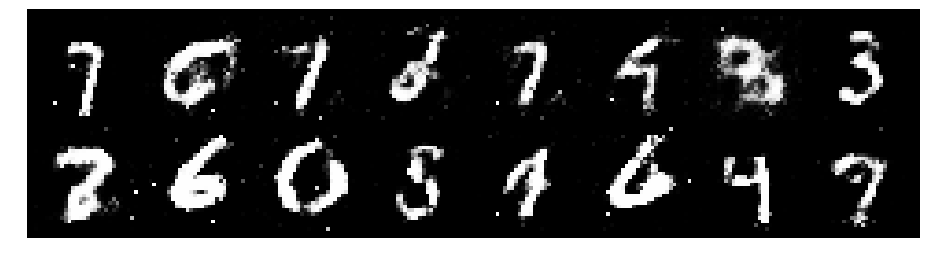

Epoch: [44/200], Batch Num: [300/600]
Discriminator Loss: 1.2467, Generator Loss: 1.2413
D(x): 0.6095, D(G(z)): 0.4175


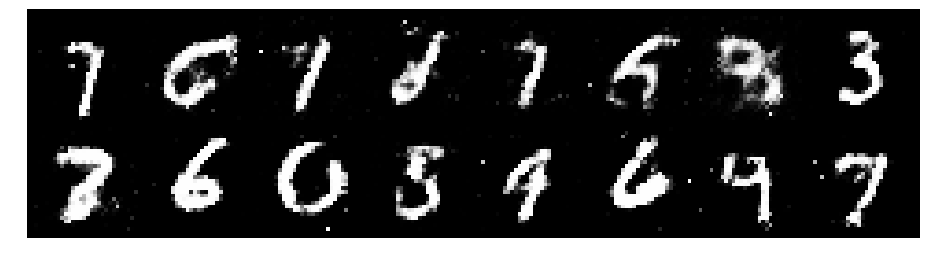

Epoch: [44/200], Batch Num: [400/600]
Discriminator Loss: 1.1389, Generator Loss: 1.1006
D(x): 0.6155, D(G(z)): 0.3355


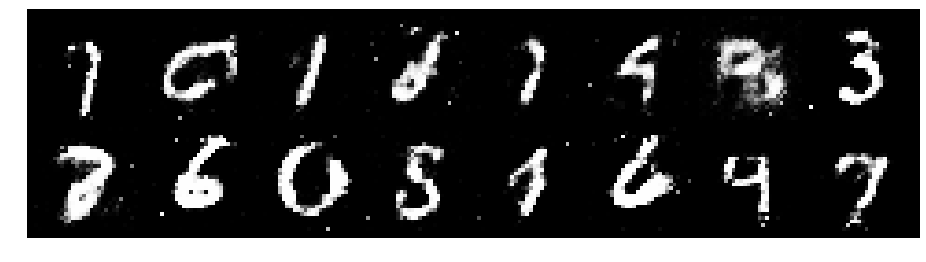

Epoch: [44/200], Batch Num: [500/600]
Discriminator Loss: 0.9493, Generator Loss: 1.4516
D(x): 0.6212, D(G(z)): 0.2924


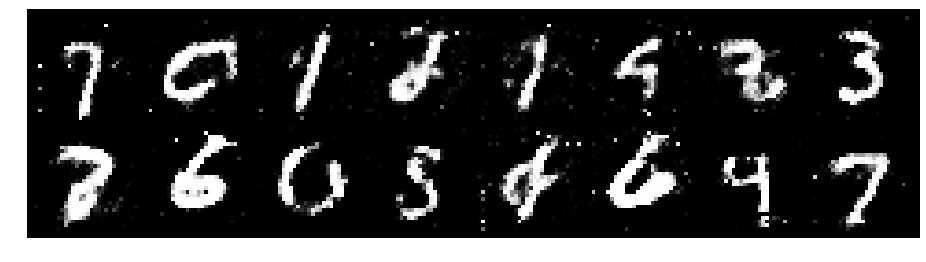

Epoch: [45/200], Batch Num: [0/600]
Discriminator Loss: 1.0414, Generator Loss: 1.1350
D(x): 0.6811, D(G(z)): 0.3990


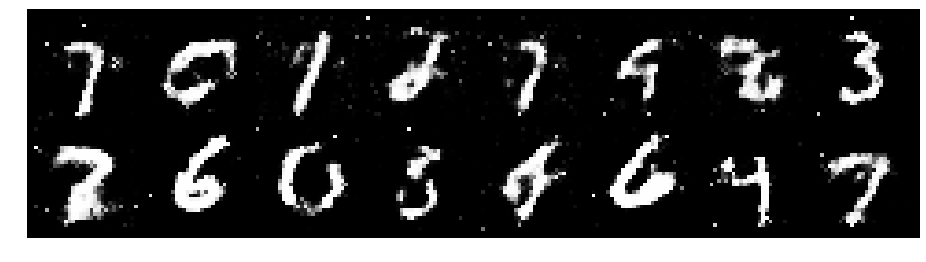

Epoch: [45/200], Batch Num: [100/600]
Discriminator Loss: 1.1932, Generator Loss: 1.0461
D(x): 0.6081, D(G(z)): 0.4065


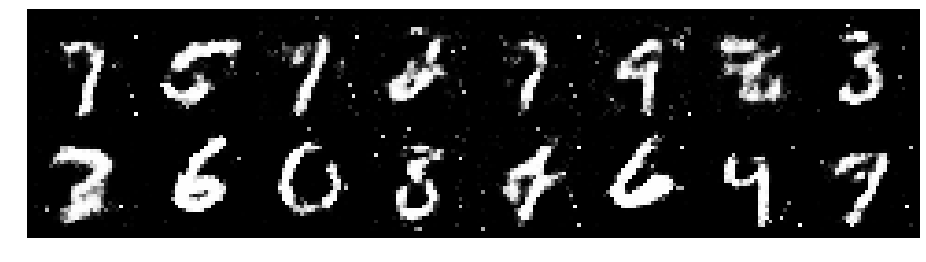

Epoch: [45/200], Batch Num: [200/600]
Discriminator Loss: 1.0850, Generator Loss: 1.1633
D(x): 0.6419, D(G(z)): 0.3855


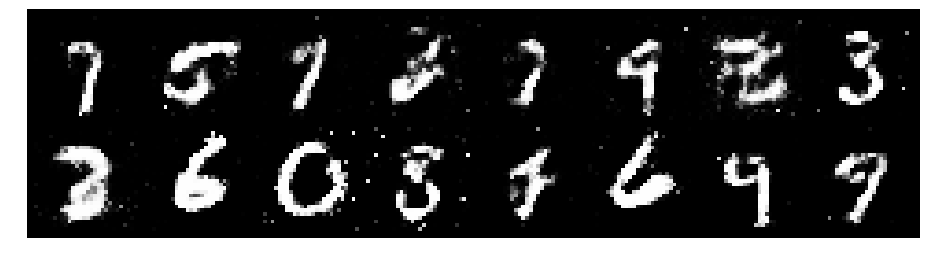

Epoch: [45/200], Batch Num: [300/600]
Discriminator Loss: 1.1807, Generator Loss: 0.8313
D(x): 0.6254, D(G(z)): 0.4507


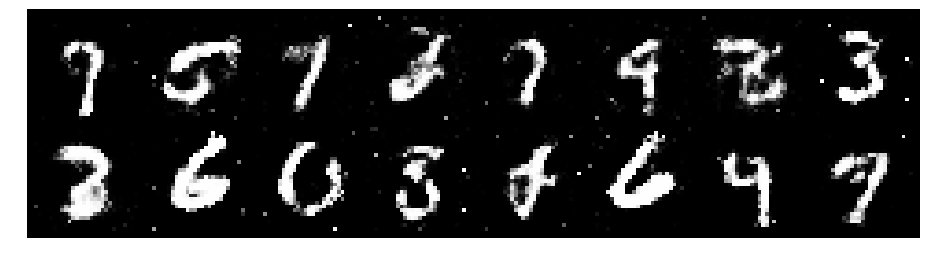

Epoch: [45/200], Batch Num: [400/600]
Discriminator Loss: 1.0809, Generator Loss: 1.0804
D(x): 0.6373, D(G(z)): 0.3963


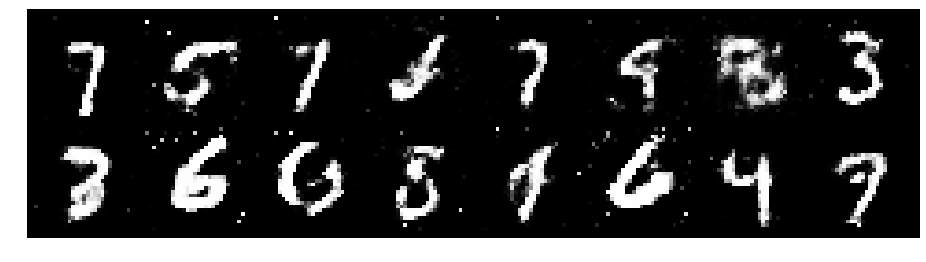

Epoch: [45/200], Batch Num: [500/600]
Discriminator Loss: 1.2447, Generator Loss: 1.4066
D(x): 0.5802, D(G(z)): 0.3740


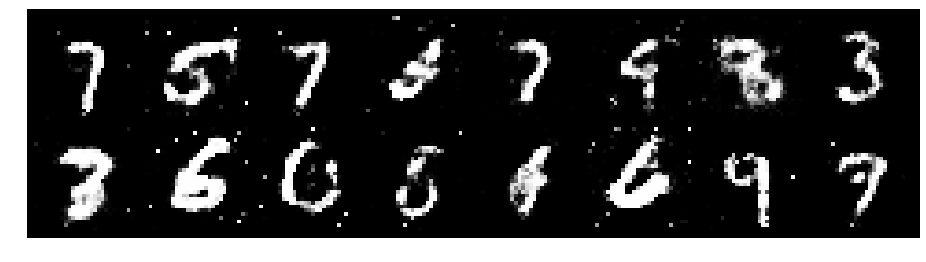

Epoch: [46/200], Batch Num: [0/600]
Discriminator Loss: 1.2239, Generator Loss: 1.4908
D(x): 0.6137, D(G(z)): 0.4054


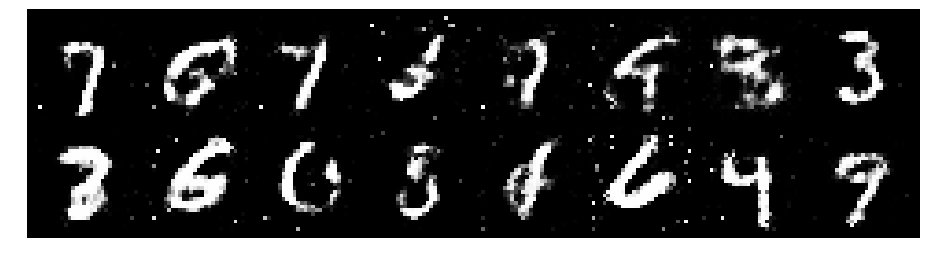

Epoch: [46/200], Batch Num: [100/600]
Discriminator Loss: 1.0100, Generator Loss: 1.0322
D(x): 0.6756, D(G(z)): 0.3769


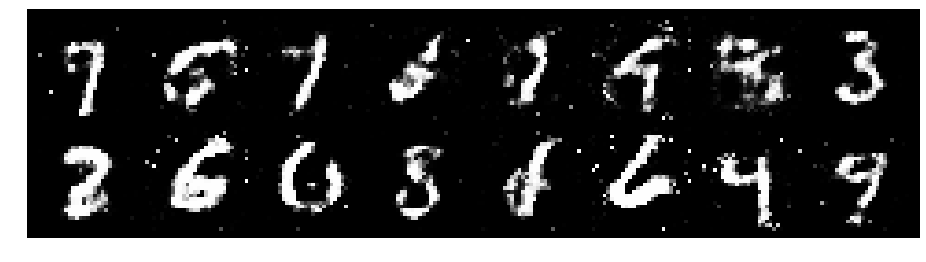

Epoch: [46/200], Batch Num: [200/600]
Discriminator Loss: 1.2630, Generator Loss: 0.8823
D(x): 0.5942, D(G(z)): 0.4268


KeyboardInterrupt: 

In [19]:
num_test_samples = 16
test_noise = noise(num_test_samples)
# Create logger instance
logger = Logger(model_name='VGAN', data_name='MNIST')
# Total number of epochs to train
num_epochs = 200
for epoch in range(num_epochs):
    for n_batch, (real_batch,_) in enumerate(data_loader):
        N = real_batch.size(0)
        # 1. Train Discriminator
        real_data = Variable(images_to_vectors(real_batch))
        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()
        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator
        # Generate fake data
        fake_data = generator(noise(N))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)
        # Display Progress every few batches
        if (n_batch) % 100 == 0: 
            test_images = vectors_to_images(generator(test_noise))
            test_images = test_images.data
            logger.log_images(
                test_images, num_test_samples, 
                epoch, n_batch, num_batches
            );
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )